# 🌍 ClimAx Phase 4 - Complete Multi-Scenario Training

**Complete notebook for training ClimAx models across multiple climate scenarios**

---

## 📋 Features
- ✅ Multi-scenario training (historical + SSP126/245/370/585)
- ✅ Stratified splitting (all scenarios in train/val/test)
- ✅ Memory-efficient for 6GB GPU
- ✅ Progress bars with tqdm
- ✅ Automatic checkpointing

## 🎯 Requirements
- PyTorch with CUDA
- 6GB+ GPU memory
- Climate data in E:/Datasets/ (or update paths)

---

## 📦 Section 1: Install & Import Dependencies

In [1]:
# =============================================================================
# 📦 SECTION 1: INSTALL & IMPORT DEPENDENCIES - FIXED
# =============================================================================

# Install required packages (uncomment if needed on Kaggle)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# !pip install xarray netcdf4 scipy scikit-learn tqdm matplotlib

import os
os.environ['PYDEVD_DISABLE_FILE_VALIDATION'] = '1'
import sys  # ✅ CRITICAL: Added for sys.stdout.flush()
import time
import json
import logging
import gc
import glob
import math
from datetime import datetime
from typing import Dict, List, Tuple, Optional, Any

import numpy as np
import xarray as xr
from scipy.ndimage import zoom
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.checkpoint import checkpoint

from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Setup logging with more detail
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s"
)
logger = logging.getLogger("phase4_training")

print("✅ All imports successful!")
print(f"🎮 PyTorch version: {torch.__version__}")
print(f"🎮 CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"🎮 GPU Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
else:
    print("⚠️ WARNING: No GPU detected - training will be VERY slow!")

# Force flush output immediately
sys.stdout.flush()

✅ All imports successful!
🎮 PyTorch version: 2.6.0+cu124
🎮 CUDA available: True
🎮 GPU: Tesla P100-PCIE-16GB
🎮 GPU Memory: 15.9 GB


## ⚙️ Section 2: Configuration

**⚠️ UPDATE THE DATA PATHS BELOW!**

In [2]:
# =============================================================================
# 🌍 CONFIGURATION - KAGGLE PATHS
# =============================================================================

# ✅ Updated for Kaggle dataset structure
INPUT_DATA_DIR = "/kaggle/input/climate-dataset/Datasets/inputs/input4mips"
OUTPUT_DATA_DIR = "/kaggle/input/climate-dataset/Datasets/outputs/CMIP6"
OUTPUT_DIR = "/kaggle/working/climax_phase4_results"

# Create all required subdirectories
subdirs = ["checkpoints", "logs", "plots", "metrics", "visualizations"]
for subdir in subdirs:
    os.makedirs(os.path.join(OUTPUT_DIR, subdir), exist_ok=True)

# Verify writability
test_file = os.path.join(OUTPUT_DIR, ".test")
try:
    with open(test_file, 'w') as f:
        f.write("test")
    os.remove(test_file)
    print(f"✅ Output directories ready: {OUTPUT_DIR}")
except Exception as e:
    print(f"❌ Cannot write to output directory!")
    raise RuntimeError(f"Output directory not writable: {e}")

# Training settings
SMOKE_TEST = True              # True = 2 institutions, 2 epochs for testing
RESUME_IF_MODEL_EXISTS = True  # Skip already trained models
SKIP_TRAINING = False          # Set True to only load results

# Memory settings
TARGET_SPATIAL_H = 9
TARGET_SPATIAL_W = 19
BATCH_SIZE = 3
USE_CHECKPOINTING = True
EPOCHS = 1 if SMOKE_TEST else 10  # Short for smoke test

# Model settings
EMBED_DIM = 64
DEPTH = 4
NUM_HEADS = 4

# All 18 institutions
ALL_INSTITUTIONS = [
    "AWI-CM-1-1-MR", "BCC-CSM2-MR", "CAS-ESM2-0", "CESM2",
    "CESM2-WACCM", "CMCC-CM2-SR5", "CMCC-ESM2", "CNRM-CM6-1-HR",
    "EC-Earth3", "EC-Earth3-Veg", "EC-Earth3-Veg-LR", "FGOALS-f3-L",
    "GFDL-ESM4", "INM-CM4-8", "INM-CM5-0", "MPI-ESM1-2-HR",
    "MRI-ESM2-0", "TaiESM1"
]

SCENARIOS = {
    'historical': 0,
    'ssp126': 1,
    'ssp245': 2,
    'ssp370': 3,
    'ssp585': 4
}

print("✅ Configuration loaded")
print(f"   📁 Input: {INPUT_DATA_DIR}")
print(f"   📁 Output: {OUTPUT_DATA_DIR}")
print(f"   💾 Results: /kaggle/working/{OUTPUT_DIR}")
print(f"   🗺️  Spatial: {TARGET_SPATIAL_H}×{TARGET_SPATIAL_W}")
print(f"   🏢 Institutions: {len(ALL_INSTITUTIONS)}")
print(f"   🌍 Scenarios: {list(SCENARIOS.keys())}")
print(f"   ⚙️  Smoke test: {SMOKE_TEST}")

# Verify paths exist
if not os.path.exists(INPUT_DATA_DIR):
    print(f"\n❌ ERROR: Input path not found!")
    print(f"   Path: {INPUT_DATA_DIR}")
    print(f"   Make sure 'climate-dataset' is attached to this notebook!")
else:
    print(f"\n✅ Input path verified")

if not os.path.exists(OUTPUT_DATA_DIR):
    print(f"\n❌ ERROR: Output path not found!")
    print(f"   Path: {OUTPUT_DATA_DIR}")
    print(f"   Make sure 'climate-dataset' is attached to this notebook!")
else:
    print(f"✅ Output path verified")

✅ Output directories ready: /kaggle/working/climax_phase4_results
✅ Configuration loaded
   📁 Input: /kaggle/input/climate-dataset/Datasets/inputs/input4mips
   📁 Output: /kaggle/input/climate-dataset/Datasets/outputs/CMIP6
   💾 Results: /kaggle/working//kaggle/working/climax_phase4_results
   🗺️  Spatial: 9×19
   🏢 Institutions: 18
   🌍 Scenarios: ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
   ⚙️  Smoke test: True

✅ Input path verified
✅ Output path verified


In [3]:
# =============================================================================
# 🔍 DEBUG: Inspect Data Structure
# =============================================================================

print("="*80)
print("🔍 DEBUGGING: Checking actual file structure")
print("="*80)

# Check inputs structure
print("\n📊 INPUT STRUCTURE:")
input_base = "/kaggle/input/climate-dataset/Datasets/inputs/input4mips"

if os.path.exists(input_base):
    scenarios = os.listdir(input_base)
    print(f"✅ Found scenarios: {scenarios}\n")
    
    # Check historical scenario as example
    hist_path = os.path.join(input_base, "historical")
    if os.path.exists(hist_path):
        print(f"📁 Contents of historical/:")
        for item in os.listdir(hist_path):
            item_path = os.path.join(hist_path, item)
            if os.path.isdir(item_path):
                # Count files in this directory
                files = []
                for root, dirs, filenames in os.walk(item_path):
                    files.extend([f for f in filenames if f.endswith('.nc')])
                print(f"   📂 {item}/ → {len(files)} .nc files")
    else:
        print("❌ historical/ not found")
else:
    print(f"❌ Path not found: {input_base}")

# Check outputs structure
print("\n🎯 OUTPUT STRUCTURE:")
output_base = "/kaggle/input/climate-dataset/Datasets/outputs/CMIP6"

if os.path.exists(output_base):
    institutions = os.listdir(output_base)
    print(f"✅ Found {len(institutions)} institutions\n")
    
    # Check first institution as example
    first_inst = institutions[0] if institutions else None
    if first_inst:
        inst_path = os.path.join(output_base, first_inst)
        print(f"📁 Contents of {first_inst}/:")
        
        if os.path.isdir(inst_path):
            items = os.listdir(inst_path)
            print(f"   Items: {items[:5]}...")  # Show first 5
            
            # Check if scenarios are inside
            for scenario in ['historical', 'ssp126', 'ssp245']:
                scenario_path = os.path.join(inst_path, scenario)
                if os.path.exists(scenario_path):
                    print(f"   ✓ {scenario}/ exists")
                    # Check for pr variable
                    pr_path = os.path.join(scenario_path, "pr")
                    if os.path.exists(pr_path):
                        files = []
                        for root, dirs, filenames in os.walk(pr_path):
                            files.extend([f for f in filenames if f.endswith('.nc')])
                        print(f"      → pr/ → {len(files)} .nc files")
                else:
                    print(f"   ✗ {scenario}/ not found")
else:
    print(f"❌ Path not found: {output_base}")

print("\n" + "="*80)

🔍 DEBUGGING: Checking actual file structure

📊 INPUT STRUCTURE:
✅ Found scenarios: ['ssp585', 'ssp370', 'historical', 'ssp126', 'ssp245']

📁 Contents of historical/:
   📂 CO2_sum/ → 165 .nc files
   📂 SO2_sum/ → 495 .nc files
   📂 BC_sum/ → 495 .nc files
   📂 CH4_sum/ → 495 .nc files

🎯 OUTPUT STRUCTURE:
✅ Found 18 institutions

📁 Contents of CMCC-CM2-SR5/:
   Items: ['ssp585', 'ssp370', 'historical', 'ssp126', 'ssp245']...
   ✓ historical/ exists
      → pr/ → 165 .nc files
   ✓ ssp126/ exists
      → pr/ → 86 .nc files
   ✓ ssp245/ exists
      → pr/ → 86 .nc files



In [4]:
class Phase4Config:
    """Minimal config for Phase 4 - FIXED for scenario channels"""
    def __init__(self):
        self.INPUT_DATA_DIR = INPUT_DATA_DIR
        self.OUTPUT_DATA_DIR = OUTPUT_DATA_DIR
        self.SPATIAL_HEIGHT = TARGET_SPATIAL_H
        self.SPATIAL_WIDTH = TARGET_SPATIAL_W
        self.SPATIAL_H = TARGET_SPATIAL_H
        self.SPATIAL_W = TARGET_SPATIAL_W
        self.PATCH_SIZE = 1
        self.EMBED_DIM = EMBED_DIM
        self.DEPTH = DEPTH
        self.NUM_HEADS = NUM_HEADS
        self.MLP_RATIO = 4.0
        self.DROPOUT_RATE = 0.1
        self.ATTENTION_DROPOUT = 0.1
        self.DROP_PATH_RATE = 0.1
        self.SEQUENCE_INPUT_LENGTH = 12
        self.SEQUENCE_OUTPUT_LENGTH = 3
        self.TEMPORAL_STRIDE = 1
        self.BATCH_SIZE = BATCH_SIZE
        self.TRAIN_RATIO = 0.7
        self.VAL_RATIO = 0.15
        self.LEARNING_RATE = 1e-4
        self.WEIGHT_DECAY = 0.05
        self.CLIP_GRAD_NORM = 1.0
        
        # Physical input variables (from files only)
        self.INPUT_VARIABLES = [
            'BC_anthro_fires', 'BC_no_fires',
            'CH4_anthro_fires', 'CH4_no_fires',
            'CO2_sum',
            'SO2_anthro_fires', 'SO2_no_fires'
        ]
        
        # ✅ FIXED: Total input channels (7 variables + 1 scenario channel)
        self.NUM_INPUT_CHANNELS = 8
        
        self.OUTPUT_VARIABLE = 'pr'

# Create directories
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "checkpoints"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "logs"), exist_ok=True)
os.makedirs(os.path.join(OUTPUT_DIR, "plots"), exist_ok=True)

print("✅ Config class created")
print("✅ Output directories created")

✅ Config class created
✅ Output directories created


## 📊 Section 3: Data Loader (Stratified Multi-Scenario)

In [5]:
# =============================================================================
# 📊 SECTION 3: DATA LOADER - FIXED VERSION (From working Python file)
# =============================================================================

class ClimateDatasetWithScenario(Dataset):
    """PyTorch dataset with scenario information"""
    
    def __init__(self, X: np.ndarray, y: np.ndarray, scenarios: np.ndarray):
        self.X = torch.from_numpy(X.astype(np.float32))
        self.y = torch.from_numpy(y.astype(np.float32))
        self.scenarios = torch.from_numpy(scenarios.astype(np.float32))
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx], self.scenarios[idx]


class Phase4MultiScenarioDataLoader:
    """
    Multi-Scenario Data Loader - FIXED VERSION from working Python file
    ✅ Robust file discovery
    ✅ Better error handling
    ✅ Memory-efficient
    """
    
    def __init__(self, config, target_h: int = 9, target_w: int = 19):
        self.input_base = config.INPUT_DATA_DIR
        self.output_base = config.OUTPUT_DATA_DIR
        self.target_h = target_h
        self.target_w = target_w
        self.scalers = {}
        
        self.scenarios = {'historical': 0, 'ssp126': 1, 'ssp245': 2, 'ssp370': 3, 'ssp585': 4}
        self.input_variables = config.INPUT_VARIABLES
        self.variable_dirs = {
            'BC_anthro_fires': 'BC_sum', 'BC_no_fires': 'BC_sum',
            'CH4_anthro_fires': 'CH4_sum', 'CH4_no_fires': 'CH4_sum',
            'CO2_sum': 'CO2_sum',
            'SO2_anthro_fires': 'SO2_sum', 'SO2_no_fires': 'SO2_sum'
        }
        self.output_variable = config.OUTPUT_VARIABLE
        logger.info(f"📊 DataLoader initialized: {target_h}×{target_w}")
    
    def _matches_variable_pattern(self, filename: str, variable: str) -> bool:
        """Pattern matching for filenames"""
        f = filename.lower()
        patterns = {
            'BC_anthro_fires': (['bc', 'anthro'], ['fire']),
            'BC_no_fires': (['bc', 'no'], ['fire']),
            'CH4_anthro_fires': (['ch4', 'anthro'], ['fire']),
            'CH4_no_fires': (['ch4', 'no'], ['fire']),
            'CO2_sum': (['co2'], []),
            'SO2_anthro_fires': (['so2', 'anthro'], ['fire']),
            'SO2_no_fires': (['so2', 'no'], ['fire'])
        }
        
        if variable in patterns:
            req, opt = patterns[variable]
            has_req = all(p in f for p in req)
            if 'no' in req:
                has_req = has_req and 'anthro' not in f
            if opt:
                return has_req and any(p in f for p in opt)
            return has_req
        return False
    
    def _is_file_readable(self, file_path: str) -> bool:
        """Check if file can be opened - CRITICAL FIX"""
        try:
            if not os.path.exists(file_path) or os.path.getsize(file_path) < 1000:
                return False
            # Quick check without fully loading
            with xr.open_dataset(file_path, decode_times=False) as ds:
                _ = list(ds.data_vars.keys())
            return True
        except:
            return False
    
    def discover_files_multi_scenario(self, institution: str):
        """Discover files for all scenarios - FIXED with better logging"""
        logger.info(f"🔍 Discovering files for {institution}...")
        all_scenario_files = {}
        
        for scenario in self.scenarios.keys():
            logger.info(f"   📁 {scenario}")
            results_inputs = {}
            results_outputs = {}
            
            # Input files
            for var in self.input_variables:
                folder = self.variable_dirs.get(var, var)
                path = os.path.join(self.input_base, scenario, folder)
                
                if not os.path.exists(path):
                    logger.warning(f"      ⚠️ Path not found: {path}")
                    continue
                
                found = []
                try:
                    for root, dirs, files in os.walk(path):
                        for fname in files:
                            if fname.endswith('.nc') and self._matches_variable_pattern(fname, var):
                                fpath = os.path.join(root, fname)
                                if self._is_file_readable(fpath):
                                    found.append(fpath)
                                    if len(found) % 10 == 0:  # Progress update
                                        logger.info(f"         Found {len(found)} {var} files...")
                except Exception as e:
                    logger.error(f"      ❌ Error walking {path}: {e}")
                    continue
                
                if found:
                    results_inputs[var] = found
                    logger.info(f"      ✓ {var}: {len(found)} files")
                else:
                    logger.warning(f"      ⚠️ {var}: No readable files found")
            
            # Output files
            out_path = os.path.join(self.output_base, institution, scenario, self.output_variable)
            if os.path.exists(out_path):
                out_files = []
                try:
                    for root, dirs, files in os.walk(out_path):
                        for fname in files:
                            if fname.endswith('.nc'):
                                fpath = os.path.join(root, fname)
                                if self._is_file_readable(fpath):
                                    out_files.append(fpath)
                                    if len(out_files) % 10 == 0:
                                        logger.info(f"         Found {len(out_files)} output files...")
                except Exception as e:
                    logger.error(f"      ❌ Error walking {out_path}: {e}")
                
                if out_files:
                    results_outputs[self.output_variable] = out_files
                    logger.info(f"      ✓ {self.output_variable}: {len(out_files)} files")
            else:
                logger.warning(f"      ⚠️ Output path not found: {out_path}")
            
            all_scenario_files[scenario] = {"inputs": results_inputs, "outputs": results_outputs}
        
        return all_scenario_files
    
    def downsample_spatial(self, arr, target_h, target_w):
        """Downsample using scipy.ndimage.zoom"""
        if arr.shape[1] == target_h and arr.shape[2] == target_w:
            return arr
        T, H, W = arr.shape
        downsampled = zoom(arr, [1.0, target_h/H, target_w/W], order=1, mode='nearest')
        return downsampled[:, :target_h, :target_w]
    
    def _load_netcdf_list(self, paths, var_hint=None):
        """Load and concatenate NetCDF files"""
        arrays = []
        for p in sorted(paths):
            try:
                ds = xr.open_dataset(p, decode_times=False)
                dvars = list(ds.data_vars.keys())
                if not dvars:
                    ds.close()
                    continue
                var = var_hint if (var_hint and var_hint in dvars) else dvars[0]
                arr = ds[var].values
                ds.close()
                if arr.ndim == 2:
                    arr = np.expand_dims(arr, 0)
                elif arr.ndim > 3:
                    arr = arr.reshape(-1, arr.shape[-2], arr.shape[-1])
                arrays.append(np.nan_to_num(arr, 0.0, 0.0, 0.0))
            except Exception as e:
                logger.warning(f"⚠️ Error reading {os.path.basename(p)}: {e}")
        
        if not arrays:
            return np.zeros((0, 0, 0), dtype=float)
        
        try:
            return np.concatenate(arrays, axis=0)
        except:
            mh = max(a.shape[1] for a in arrays)
            mw = max(a.shape[2] for a in arrays)
            padded = [np.pad(a, ((0,0), (0,mh-a.shape[1]), (0,mw-a.shape[2])), 'edge') for a in arrays]
            return np.concatenate(padded, axis=0)
    
    def align_temporal_dimensions(self, var_data):
        """Align temporal dimensions"""
        if not var_data:
            return var_data
        times = {v: a.shape[0] for v, a in var_data.items()}
        mt = min(times.values())
        if mt != max(times.values()):
            logger.warning(f"⚠️ Aligning to {mt} timesteps")
            return {v: a[:mt] for v, a in var_data.items()}
        return var_data
    
    def load_all_scenarios(self, all_files):
        """Load all scenario data"""
        logger.info("📊 Loading scenarios...")
        all_data = {}
        
        for scenario, files in all_files.items():
            logger.info(f"   📁 {scenario}")
            var_data = {}
            
            for var, paths in files.get("inputs", {}).items():
                if paths:
                    logger.info(f"      Loading {var} ({len(paths)} files)...")
                    arr = self._load_netcdf_list(paths)
                    if arr.size > 0:
                        var_data[var] = arr
                        logger.info(f"      ✓ {var}: {arr.shape}")
            
            for var, paths in files.get("outputs", {}).items():
                if paths:
                    logger.info(f"      Loading {var} ({len(paths)} files)...")
                    arr = self._load_netcdf_list(paths)
                    if arr.size > 0:
                        var_data[var] = arr
                        logger.info(f"      ✓ {var}: {arr.shape}")
            
            if var_data:
                var_data = self.align_temporal_dimensions(var_data)
                logger.info(f"      🔽 Downsampling...")
                down_data = {}
                for v, a in var_data.items():
                    d = self.downsample_spatial(a, self.target_h, self.target_w)
                    down_data[v] = d
                    logger.info(f"         {v}: {a.shape} → {d.shape}")
                all_data[scenario] = down_data
        
        logger.info(f"   ✅ Loaded {len(all_data)} scenarios")
        return all_data
    
    def normalize_data(self, arr, var_name, fit=True):
        """Normalize data"""
        arr = np.nan_to_num(arr, 0.0, 0.0, 0.0)
        flat = arr.reshape(-1, 1)
        
        if fit or var_name not in self.scalers:
            scaler = MinMaxScaler()
            try:
                scaler.fit(flat)
            except:
                scaler.min_, scaler.scale_ = np.min(flat), 1.0
            self.scalers[var_name] = scaler
        else:
            scaler = self.scalers[var_name]
        
        return np.nan_to_num(scaler.transform(flat).reshape(arr.shape), 0.0, 0.0, 0.0)
    
    def create_multi_scenario_sequences(self, all_data, seq_in=12, seq_out=3, stride=1, train_ratio=0.7, val_ratio=0.15, batch_size=1):
        """Create sequences with stratified splitting"""
        logger.info("🔄 Creating sequences...")
        X_seqs, Y_seqs, sc_ids = [], [], []
        
        for scenario, var_data in all_data.items():
            if not var_data:
                continue
            
            sc_id = self.scenarios[scenario]
            logger.info(f"   📦 {scenario} (id={sc_id})")
            
            missing = [v for v in self.input_variables if v not in var_data]
            if missing or self.output_variable not in var_data:
                logger.warning(f"      ⚠️ Skipping - missing data")
                continue
            
            # Normalize
            norm = {v: self.normalize_data(var_data[v], v, True) for v in self.input_variables if v in var_data}
            norm[self.output_variable] = self.normalize_data(var_data[self.output_variable], self.output_variable, True)
            
            # Stack
            X_sc = np.stack([norm[v] for v in self.input_variables if v in norm], axis=1)
            Y_sc = norm[self.output_variable]
            
            T = X_sc.shape[0]
            n_samp = T - seq_in - seq_out + 1
            
            if n_samp <= 0:
                logger.warning(f"      ⚠️ Not enough timesteps")
                continue
            
            for start in range(0, n_samp, stride):
                X_seqs.append(X_sc[start:start+seq_in])
                Y_seqs.append(Y_sc[start+seq_in:start+seq_in+seq_out])
                sc_ids.append(sc_id)
            
            logger.info(f"      ✓ {n_samp} sequences")
        
        if not X_seqs:
            raise RuntimeError("❌ No sequences!")
        
        X_all = np.stack(X_seqs, 0)
        Y_all = np.stack(Y_seqs, 0)
        sc_all = np.array(sc_ids)
        
        # Add scenario channel
        N, T, C, H, W = X_all.shape
        sc_ch = np.repeat(sc_all[:, None, None, None, None], T*H*W, 1).reshape(N, T, 1, H, W)
        X_all = np.concatenate([X_all, sc_ch], 2)
        Y_all = np.expand_dims(Y_all, 2)
        
        logger.info(f"   🧩 Total: X={X_all.shape}, Y={Y_all.shape}")
        
        # Stratified split
        logger.info("   📊 Stratified split...")
        X_tr, X_tmp, y_tr, y_tmp, sc_tr, sc_tmp = train_test_split(
            X_all, Y_all, sc_all, test_size=(1-train_ratio), stratify=sc_all, random_state=42
        )
        vt_ratio = val_ratio / (1 - train_ratio)
        X_val, X_te, y_val, y_te, sc_val, sc_te = train_test_split(
            X_tmp, y_tmp, sc_tmp, test_size=(1-vt_ratio), stratify=sc_tmp, random_state=42
        )
        
        splits = {
            "train": {"input": X_tr, "target": y_tr, "scenarios": sc_tr},
            "validation": {"input": X_val, "target": y_val, "scenarios": sc_val},
            "test": {"input": X_te, "target": y_te, "scenarios": sc_te}
        }
        
        # CRITICAL FIX: pin_memory=False for Kaggle
        loaders = {
            "train": DataLoader(ClimateDatasetWithScenario(X_tr, y_tr, sc_tr), batch_size, True, pin_memory=False, num_workers=0),
            "validation": DataLoader(ClimateDatasetWithScenario(X_val, y_val, sc_val), batch_size, False, pin_memory=False, num_workers=0),
            "test": DataLoader(ClimateDatasetWithScenario(X_te, y_te, sc_te), batch_size, False, pin_memory=False, num_workers=0)
        }
        
        logger.info(f"   📦 Train:{len(X_tr)} Val:{len(X_val)} Test:{len(X_te)}")
        return splits, loaders


print("✅ Fixed DataLoader loaded")

✅ Fixed DataLoader loaded


## 🧠 Section 4: ClimAx Model (Memory-Efficient)

In [6]:
class MemoryEfficientPatchEmbedding(nn.Module):
    """Memory-efficient patch embedding with conv2d."""
    
    def __init__(self, patch_size: int, in_channels: int, embed_dim: int, 
                 spatial_h: int, spatial_w: int):
        super().__init__()
        self.patch_size = patch_size
        self.in_channels = in_channels
        self.embed_dim = embed_dim
        self.spatial_h = spatial_h
        self.spatial_w = spatial_w
        
        # Projection layer
        self.proj = nn.Conv2d(in_channels, embed_dim, 
                             kernel_size=patch_size, stride=patch_size)
        
        # Calculate number of patches
        self.num_patches_h = spatial_h // patch_size
        self.num_patches_w = spatial_w // patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        logger.info(f"🔧 PatchEmbed: {spatial_h}×{spatial_w} → {self.num_patches_h}×{self.num_patches_w} = {self.num_patches} patches")
        
    def forward(self, x):
        # x: (B, T, C, H, W)
        B, T, C, H, W = x.shape
        
        # Verify dimensions
        if H != self.spatial_h or W != self.spatial_w:
            raise ValueError(f"Input spatial dims ({H}, {W}) don't match expected ({self.spatial_h}, {self.spatial_w})")
        
        # Process in chunks to save memory
        x = x.reshape(B * T, C, H, W)
        x = self.proj(x)  # (B*T, embed_dim, H', W')
        x = x.flatten(2).transpose(1, 2)  # (B*T, num_patches, embed_dim)
        x = x.reshape(B, T, self.num_patches, self.embed_dim)
        
        return x


class MemoryEfficientPositionalEmbedding(nn.Module):
    """Memory-efficient positional embeddings."""
    
    def __init__(self, num_patches: int, num_timesteps: int, embed_dim: int):
        super().__init__()
        self.num_patches = num_patches
        self.num_timesteps = num_timesteps
        self.embed_dim = embed_dim
        
        # Use smaller embeddings
        self.spatial_pos_embed = nn.Parameter(torch.zeros(1, 1, num_patches, embed_dim))
        self.temporal_pos_embed = nn.Parameter(torch.zeros(1, num_timesteps, 1, embed_dim))
        
        # Initialize with smaller std
        nn.init.trunc_normal_(self.spatial_pos_embed, std=0.01)
        nn.init.trunc_normal_(self.temporal_pos_embed, std=0.01)
    
    def forward(self, x):
        B, T, P, D = x.shape
        
        if P != self.num_patches:
            raise ValueError(f"Number of patches mismatch: got {P}, expected {self.num_patches}")
        if T > self.num_timesteps:
            raise ValueError(f"Timesteps exceed maximum: got {T}, max {self.num_timesteps}")
        
        return x + self.spatial_pos_embed + self.temporal_pos_embed[:, :T, :, :]


class MemoryEfficientTransformerBlock(nn.Module):
    """Memory-efficient Transformer block with gradient checkpointing."""
    
    def __init__(self, embed_dim: int, num_heads: int, mlp_ratio: float = 4.0,
                 dropout: float = 0.1, attention_dropout: float = 0.1):
        super().__init__()
        
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = nn.MultiheadAttention(
            embed_dim, num_heads, 
            dropout=attention_dropout, 
            batch_first=True
        )
        
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )
    
    def forward(self, x):
        # Self-attention with residual
        normed = self.norm1(x)
        attn_out, _ = self.attn(normed, normed, normed)
        x = x + attn_out
        
        # FFN with residual
        x = x + self.mlp(self.norm2(x))
        
        return x


class ClimAxMemoryEfficientModel(nn.Module):
    """
    ClimAx Model - MEMORY EFFICIENT VERSION
    
    ✅ Designed for 6GB GPU
    ✅ Uses ConvLSTM spatial dimensions (9×19)
    ✅ Gradient checkpointing enabled
    ✅ Optimized attention mechanisms
    ✅ Supports NUM_INPUT_CHANNELS for scenario embeddings
    """
    
    def __init__(self, config, spatial_h: Optional[int] = None, 
                 spatial_w: Optional[int] = None, use_checkpointing: bool = True):
        super().__init__()
        
        # Get spatial dims - prioritize 9×19 for memory efficiency
        if spatial_h is not None and spatial_w is not None:
            self.spatial_h = spatial_h
            self.spatial_w = spatial_w
        else:
            # Default to ConvLSTM's memory-efficient dimensions
            self.spatial_h = self._get_config_attr(config, 'SPATIAL_HEIGHT', 9)
            self.spatial_w = self._get_config_attr(config, 'SPATIAL_WIDTH', 19)
        
        # CRITICAL: Warn if dimensions are too large
        total_spatial = self.spatial_h * self.spatial_w
        if total_spatial > 500:
            logger.warning(f"⚠️  Large spatial dimensions ({self.spatial_h}×{self.spatial_w} = {total_spatial}) may cause OOM!")
            logger.warning(f"   Consider downsampling to 9×19 (171 pixels) like ConvLSTM")
        
        # Get model params
        self.patch_size = self._get_config_attr(config, 'PATCH_SIZE', 2)
        self.embed_dim = self._get_config_attr(config, 'EMBED_DIM', 128)
        self.depth = self._get_config_attr(config, 'DEPTH', 8)
        self.num_heads = self._get_config_attr(config, 'NUM_HEADS', 8)
        self.mlp_ratio = self._get_config_attr(config, 'MLP_RATIO', 4.0)
        self.dropout_rate = self._get_config_attr(config, 'DROPOUT_RATE', 0.1)
        self.attention_dropout = self._get_config_attr(config, 'ATTENTION_DROPOUT', 0.1)
        
        # Reduce model size if needed
        if total_spatial > 300:
            logger.warning("   → Reducing embed_dim from 128 to 64 to save memory")
            self.embed_dim = 64
            logger.warning("   → Reducing depth from 8 to 4 to save memory")
            self.depth = 4
        
        # ✅ FIXED: Input channels - prioritize NUM_INPUT_CHANNELS
        self.num_input_vars = self._get_config_attr(config, 'NUM_INPUT_CHANNELS', None)
        if self.num_input_vars is None:
            # Fall back to counting INPUT_VARIABLES
            input_vars = self._get_config_attr(config, 'INPUT_VARIABLES', [])
            self.num_input_vars = len(input_vars) if input_vars else 4
            logger.info(f"   📊 Input channels from INPUT_VARIABLES: {self.num_input_vars}")
        else:
            logger.info(f"   📊 Input channels from NUM_INPUT_CHANNELS: {self.num_input_vars}")
        
        self.seq_in_len = self._get_config_attr(config, 'SEQUENCE_INPUT_LENGTH', 12)
        self.seq_out_len = self._get_config_attr(config, 'SEQUENCE_OUTPUT_LENGTH', 3)
        
        # Calculate patches
        self.num_patches_h = self.spatial_h // self.patch_size
        self.num_patches_w = self.spatial_w // self.patch_size
        self.num_patches = self.num_patches_h * self.num_patches_w
        
        # Memory estimation
        tokens_per_batch = self.num_patches * self.seq_in_len
        attn_memory_gb = (tokens_per_batch ** 2 * 4) / (1024 ** 3)  # float32 bytes to GB
        
        logger.info(f"🔧 Memory-Efficient ClimAx initialized:")
        logger.info(f"   Spatial: {self.spatial_h}×{self.spatial_w} → {self.num_patches} patches")
        logger.info(f"   Tokens per sample: {tokens_per_batch}")
        logger.info(f"   Est. attention memory: {attn_memory_gb:.2f} GB per batch")
        logger.info(f"   Embed dim: {self.embed_dim}, Depth: {self.depth}")
        logger.info(f"   Gradient checkpointing: {use_checkpointing}")
        
        if attn_memory_gb > 4:
            logger.error(f"❌ Estimated memory ({attn_memory_gb:.2f} GB) exceeds safe limit!")
            logger.error(f"   Please reduce spatial dimensions or batch size")
            raise RuntimeError(f"Model too large for 6GB GPU! Need ~{attn_memory_gb:.1f}GB")
        
        self.use_checkpointing = use_checkpointing
        
        # Patch embedding
        self.patch_embed = MemoryEfficientPatchEmbedding(
            patch_size=self.patch_size,
            in_channels=self.num_input_vars,
            embed_dim=self.embed_dim,
            spatial_h=self.spatial_h,
            spatial_w=self.spatial_w
        )
        
        # Positional embeddings
        self.pos_embed = MemoryEfficientPositionalEmbedding(
            num_patches=self.num_patches,
            num_timesteps=self.seq_in_len,
            embed_dim=self.embed_dim
        )
        
        # Transformer blocks
        self.blocks = nn.ModuleList([
            MemoryEfficientTransformerBlock(
                embed_dim=self.embed_dim,
                num_heads=self.num_heads,
                mlp_ratio=self.mlp_ratio,
                dropout=self.dropout_rate,
                attention_dropout=self.attention_dropout
            ) for _ in range(self.depth)
        ])
        
        self.norm = nn.LayerNorm(self.embed_dim)
        
        # Lightweight prediction head
        self.head = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.GELU(),
            nn.Dropout(self.dropout_rate),
            nn.Linear(self.embed_dim, self.patch_size * self.patch_size * self.seq_out_len)
        )
        
        # Count parameters
        self.num_params = sum(p.numel() for p in self.parameters())
        logger.info(f"✅ Model ready - Parameters: {self.num_params:,}")
    
    def _get_config_attr(self, config, attr_name, default):
        """Safely get attribute from config."""
        if hasattr(config, attr_name):
            return getattr(config, attr_name)
        
        for ns in ['data', 'model', 'training']:
            if hasattr(config, ns):
                ns_obj = getattr(config, ns)
                if ns_obj is not None and hasattr(ns_obj, attr_name):
                    return getattr(ns_obj, attr_name)
        
        return default
    
    def forward(self, x):
        """
        Memory-efficient forward pass with gradient checkpointing.
        
        Args:
            x: (B, T, C, H, W) input tensor
        
        Returns:
            (B, T_out, H, W) predictions
        """
        B, T, C, H, W = x.shape
        
        # Store original spatial dims for reconstruction
        original_h, original_w = H, W
        
        # Verify dimensions match
        if H != self.spatial_h or W != self.spatial_w:
            raise ValueError(
                f"Input spatial dims ({H}, {W}) don't match model ({self.spatial_h}, {self.spatial_w}). "
                f"Please downsample your data to {self.spatial_h}×{self.spatial_w} before training."
            )
        
        # Patch embedding
        x = self.patch_embed(x)  # (B, T, num_patches, embed_dim)
        
        # Add positional embeddings
        x = self.pos_embed(x)
        
        # Flatten for transformer
        B, T, P, D = x.shape
        x = x.reshape(B, T * P, D)
        
        # Apply transformer blocks with gradient checkpointing
        for i, block in enumerate(self.blocks):
            if self.use_checkpointing and self.training:
                x = checkpoint(block, x, use_reentrant=False)
            else:
                x = block(x)
        
        x = self.norm(x)
        
        # Prediction head
        x = self.head(x)  # (B, T*P, patch_size^2 * seq_out_len)
        
        # Reshape to spatial output
        x = x.reshape(B, T, P, self.patch_size, self.patch_size, self.seq_out_len)
        
        # Reorganize patches back to spatial grid
        x = x.reshape(B, T, self.num_patches_h, self.num_patches_w, 
                     self.patch_size, self.patch_size, self.seq_out_len)
        
        # Merge patches: (B, T, seq_out_len, H_recon, W_recon)
        x = x.permute(0, 1, 6, 2, 4, 3, 5).contiguous()
        
        # Calculate reconstructed dimensions
        h_recon = self.num_patches_h * self.patch_size
        w_recon = self.num_patches_w * self.patch_size
        
        x = x.reshape(B, T, self.seq_out_len, h_recon, w_recon)
        
        # Upsample if needed to match original dimensions
        if h_recon != original_h or w_recon != original_w:
            x = x.reshape(B * T * self.seq_out_len, 1, h_recon, w_recon)
            x = F.interpolate(x, size=(original_h, original_w), mode='bilinear', align_corners=False)
            x = x.reshape(B, T, self.seq_out_len, original_h, original_w)
        
        # Average over input timesteps
        x = x.mean(dim=1)  # (B, seq_out_len, H, W)
        
        return x


print("✅ ClimAxMemoryEfficientModel class defined")

✅ ClimAxMemoryEfficientModel class defined


## 🚂 Section 5: Training Function

In [7]:
# =============================================================================
# 🚂 SECTION 5: TRAINING FUNCTION - FIXED WITH DEBUG LOGGING
# =============================================================================

def train_single_institution_multi_scenario(institution: str, config: Phase4Config) -> dict:
    """Train a single institution - FIXED with extensive debug logging"""
    
    print(f"\n{'='*80}")
    print(f"🌍 Training: {institution}")
    print(f"{'='*80}")
    
    start_time = time.time()
    
    # Check for existing model
    model_path = os.path.join(OUTPUT_DIR, "checkpoints", f"{institution}_multiscenario_best.pt")
    
    if RESUME_IF_MODEL_EXISTS and os.path.exists(model_path):
        print(f"⭐ Model exists - skipping {institution}")
        return {'success': True, 'institution': institution, 'skipped': True}
    
    try:
        # STEP 1: Create data loader
        print("📊 Step 1/8: Initializing data loader...")
        sys.stdout.flush()
        dl = Phase4MultiScenarioDataLoader(config, target_h=TARGET_SPATIAL_H, target_w=TARGET_SPATIAL_W)
        print("✅ Data loader created")
        sys.stdout.flush()
        
        # STEP 2: Discover files
        print("🔍 Step 2/8: Discovering files...")
        sys.stdout.flush()
        all_scenario_files = dl.discover_files_multi_scenario(institution)
        
        has_data = any(
            bool(files['inputs']) or bool(files['outputs'])
            for files in all_scenario_files.values()
        )
        
        if not has_data:
            print(f"⚠️ No data for {institution}")
            return {'success': False, 'institution': institution, 'error': 'No data'}
        
        print("✅ File discovery complete")
        sys.stdout.flush()
        
        # STEP 3: Load all scenarios
        print("📊 Step 3/8: Loading data...")
        sys.stdout.flush()
        all_scenario_data = dl.load_all_scenarios(all_scenario_files)
        
        if not all_scenario_data:
            print(f"⚠️ Failed to load data")
            return {'success': False, 'institution': institution, 'error': 'Load failed'}
        
        print("✅ Data loaded")
        sys.stdout.flush()
        
        # STEP 4: Create sequences
        print("🔄 Step 4/8: Creating sequences...")
        sys.stdout.flush()
        data_splits, dataloaders = dl.create_multi_scenario_sequences(all_scenario_data)
        print("✅ Sequences created")
        sys.stdout.flush()
        
        # STEP 5: Create model
        print("🧠 Step 5/8: Creating model...")
        sys.stdout.flush()
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"   Using device: {device}")
        
        model = ClimAxMemoryEfficientModel(
            config,
            spatial_h=TARGET_SPATIAL_H,
            spatial_w=TARGET_SPATIAL_W,
            use_checkpointing=USE_CHECKPOINTING
        ).to(device)
        
        print("✅ Model created")
        sys.stdout.flush()
        
        # STEP 6: Setup training
        print("⚙️ Step 6/8: Setting up optimizer...")
        sys.stdout.flush()
        optimizer = optim.AdamW(
            model.parameters(),
            lr=config.LEARNING_RATE,
            weight_decay=config.WEIGHT_DECAY
        )
        criterion = nn.MSELoss()
        
        history = {
            'train_loss': [],
            'val_loss': [],
            'scenario_losses': {}
        }
        best_val_loss = float('inf')
        
        print("✅ Optimizer ready")
        sys.stdout.flush()
        
        print(f"\n🚂 Step 7/8: Training for {EPOCHS} epochs...")
        sys.stdout.flush()
        
        # STEP 7: Training loop with progress bars
        epoch_pbar = tqdm(range(EPOCHS), desc=f"🌍 {institution}", position=0, leave=True)
        
        for ep in epoch_pbar:
            print(f"\n--- Epoch {ep+1}/{EPOCHS} ---")
            sys.stdout.flush()
            
            # === TRAINING PHASE ===
            model.train()
            train_loss = 0.0
            train_batches = 0
            
            print(f"Training: Processing {len(dataloaders['train'])} batches...")
            sys.stdout.flush()
            
            train_pbar = tqdm(
                dataloaders['train'], 
                desc=f"   Train Epoch {ep+1}/{EPOCHS}",
                position=1,
                leave=False,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
            )
            
            for batch_idx, batch in enumerate(train_pbar):
                try:
                    X, y, scenarios = batch
                    X = X.to(device)
                    y = y.to(device)
                    
                    optimizer.zero_grad()
                    preds = model(X)
                    
                    # Align shapes
                    if preds.shape != y.shape:
                        if preds.ndim == 4 and y.ndim == 5:
                            preds = preds.unsqueeze(2)
                    
                    loss = criterion(preds, y)
                    loss.backward()
                    
                    torch.nn.utils.clip_grad_norm_(model.parameters(), config.CLIP_GRAD_NORM)
                    optimizer.step()
                    
                    train_loss += loss.item()
                    train_batches += 1
                    
                    # Update progress bar
                    train_pbar.set_postfix({'loss': f'{loss.item():.6f}'})
                    
                    # Debug print every 5 batches
                    if batch_idx % 5 == 0:
                        print(f"      Batch {batch_idx}: loss={loss.item():.6f}")
                        sys.stdout.flush()
                    
                    if train_batches % 10 == 0:
                        torch.cuda.empty_cache()
                
                except Exception as e:
                    print(f"\n❌ Error in training batch {batch_idx}: {e}")
                    import traceback
                    traceback.print_exc()
                    raise
            
            avg_train_loss = train_loss / max(1, train_batches)
            history['train_loss'].append(avg_train_loss)
            
            print(f"   ✓ Train loss: {avg_train_loss:.6f}")
            sys.stdout.flush()
            
            # === VALIDATION PHASE ===
            model.eval()
            val_loss = 0.0
            val_batches = 0
            scenario_losses = {s: [] for s in SCENARIOS.keys()}
            
            print(f"Validation: Processing {len(dataloaders['validation'])} batches...")
            sys.stdout.flush()
            
            val_pbar = tqdm(
                dataloaders['validation'],
                desc=f"   Val Epoch {ep+1}/{EPOCHS}",
                position=1,
                leave=False,
                bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt}'
            )
            
            with torch.no_grad():
                for batch_idx, batch in enumerate(val_pbar):
                    try:
                        Xv, yv, scenarios_v = batch
                        Xv = Xv.to(device)
                        yv = yv.to(device)
                        
                        preds = model(Xv)
                        
                        if preds.shape != yv.shape:
                            if preds.ndim == 4 and yv.ndim == 5:
                                preds = preds.unsqueeze(2)
                        
                        batch_loss = criterion(preds, yv)
                        val_loss += batch_loss.item()
                        val_batches += 1
                        
                        # Track per-scenario losses
                        for i, scenario_id in enumerate(scenarios_v.cpu().numpy()):
                            scenario_name = [k for k, v in SCENARIOS.items() if v == scenario_id][0]
                            scenario_losses[scenario_name].append(batch_loss.item())
                        
                        val_pbar.set_postfix({'loss': f'{batch_loss.item():.6f}'})
                    
                    except Exception as e:
                        print(f"\n❌ Error in validation batch {batch_idx}: {e}")
                        import traceback
                        traceback.print_exc()
                        raise
            
            avg_val_loss = val_loss / max(1, val_batches)
            history['val_loss'].append(avg_val_loss)
            
            print(f"   ✓ Val loss: {avg_val_loss:.6f}")
            sys.stdout.flush()
            
            # Calculate per-scenario averages
            avg_scenario_losses = {
                s: np.mean(losses) if losses else 0.0
                for s, losses in scenario_losses.items()
            }
            history['scenario_losses'][f'epoch_{ep+1}'] = avg_scenario_losses
            
            # Update best model
            is_best = avg_val_loss < best_val_loss
            if is_best:
                best_val_loss = avg_val_loss
                best_indicator = "⭐ NEW BEST"
                
                # ✅ SAVE BEST MODEL NOW!
                print(f"   💾 Saving new best model (epoch {ep+1})...")
                sys.stdout.flush()
                
                torch.save({
                    'epoch': ep + 1,
                    'institution': institution,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_loss': best_val_loss,
                    'history': history,
                    'spatial_dims': [TARGET_SPATIAL_H, TARGET_SPATIAL_W],
                    'scenarios': list(SCENARIOS.keys()),
                    'timestamp': datetime.now().isoformat()
                }, model_path)
                
                if not os.path.exists(model_path):
                    raise RuntimeError(f"❌ Failed to save: {model_path}")
                
                file_size = os.path.getsize(model_path) / (1024**2)
                print(f"   ✅ Best model saved ({file_size:.1f} MB)")
                sys.stdout.flush()
            else:
                best_indicator = ""
            
            # Update main progress bar
            epoch_pbar.set_postfix({
                'train': f'{avg_train_loss:.6f}',
                'val': f'{avg_val_loss:.6f}',
                'best': f'{best_val_loss:.6f}',
                'status': best_indicator
            })
            
            # Memory cleanup
            torch.cuda.empty_cache()
            gc.collect()
        
        # Close progress bars
        epoch_pbar.close()
        
        # STEP 8: Save model
        print("💾 Step 8/8: Saving model...")
        sys.stdout.flush()
        final_path = os.path.join(OUTPUT_DIR, "checkpoints", f"{institution}_final.pt")  # Different name!
        torch.save({
            'institution': institution,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'history': history,
            'best_val_loss': best_val_loss,
            'spatial_dims': [TARGET_SPATIAL_H, TARGET_SPATIAL_W],
            'scenarios': list(SCENARIOS.keys()),
            'timestamp': datetime.now().isoformat()
        }, final_path)

        if not os.path.exists(final_path):  # ✅ Correct
            raise RuntimeError(f"❌ Save failed: {final_path}")
        print(f"✅ Final model saved: {final_path} ({os.path.getsize(final_path)/(1024**2):.1f} MB)")
        
        # print(f"✅ Saved to {model_path}")
        sys.stdout.flush()
        
        # Save results
        summary = {
            'institution': institution,
            'training_time': time.time() - start_time,
            'epochs_trained': len(history['train_loss']),
            'best_val_loss': best_val_loss,
            'spatial_dims': [TARGET_SPATIAL_H, TARGET_SPATIAL_W],
            'scenarios': list(SCENARIOS.keys()),
            'final_scenario_losses': history['scenario_losses'].get(f'epoch_{EPOCHS}', {}),
            'timestamp': datetime.now().isoformat()
        }
        
        results_path = os.path.join(OUTPUT_DIR, "logs", f"{institution}_phase4_results.json")
        with open(results_path, 'w') as f:
            json.dump(summary, f, indent=2)
        
        return {'success': True, 'institution': institution, 'results': summary}
    
    except Exception as e:
        print(f"\n❌ FATAL ERROR: {e}")
        import traceback
        traceback.print_exc()
        sys.stdout.flush()
        return {'success': False, 'institution': institution, 'error': str(e)}
    
    finally:
        torch.cuda.empty_cache()
        gc.collect()


print("✅ Fixed training function loaded")

✅ Fixed training function loaded


## 🚀 Section 6: Main Training Loop

In [8]:
# =============================================================================
# 🚀 SECTION 6: MAIN TRAINING EXECUTION - FIXED WITH DEBUG
# =============================================================================

print("="*80)
print("🌍 ClimAx Phase 4 - Multi-Scenario Training")
print("="*80)
print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
sys.stdout.flush()

# Create config
config = Phase4Config()

# Determine institutions to train
if SMOKE_TEST:
    institutions = ALL_INSTITUTIONS[:2]
    print(f"⚠️ SMOKE TEST - Training only {len(institutions)} institutions")
else:
    institutions = ALL_INSTITUTIONS
    print(f"📋 Training all {len(institutions)} institutions")

print(f"   Scenarios: {list(SCENARIOS.keys())}")
print(f"   Spatial: {TARGET_SPATIAL_H}×{TARGET_SPATIAL_W}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Epochs: {EPOCHS}")
print(f"   Patch size: {config.PATCH_SIZE}")
print(f"   Input channels: {config.NUM_INPUT_CHANNELS}")
sys.stdout.flush()

# GPU Check
if torch.cuda.is_available():
    print(f"\n🎮 GPU Status:")
    print(f"   Device: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.1f} GB")
    print(f"   Current allocation: {torch.cuda.memory_allocated() / (1024**2):.1f} MB")
else:
    print("\n⚠️ WARNING: No GPU available - will be VERY slow!")
sys.stdout.flush()

if SKIP_TRAINING:
    print("SKIP_TRAINING=True - Loading existing results...")
    summary_path = os.path.join(OUTPUT_DIR, "logs", "phase4_training_summary.json")
    if os.path.exists(summary_path):
        with open(summary_path, 'r') as f:
            summary = json.load(f)
        print("✅ Loaded existing results")
    else:
        print("⚠️ No existing results found")
        summary = {}
else:
    # Training loop with main progress bar
    print("\n" + "="*80)
    print("🚂 STARTING TRAINING")
    print("="*80)
    sys.stdout.flush()
    
    t0 = time.time()
    all_results = []
    
    main_pbar = tqdm(
        institutions,
        desc="🌍 Overall Progress",
        position=0,
        bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]'
    )
    
    for inst_idx, institution in enumerate(main_pbar):
        print(f"\n{'='*80}")
        print(f"Institution {inst_idx+1}/{len(institutions)}: {institution}")
        print(f"{'='*80}")
        sys.stdout.flush()
        
        main_pbar.set_description(f"🌍 Training {institution}")
        
        try:
            result = train_single_institution_multi_scenario(institution, config)
            all_results.append(result)
            
            # Update main progress with status
            successful = sum(1 for r in all_results if r.get('success') and not r.get('skipped'))
            skipped = sum(1 for r in all_results if r.get('skipped'))
            failed = sum(1 for r in all_results if not r.get('success'))
            
            print(f"\n📊 Progress Summary:")
            print(f"   ✅ Successful: {successful}")
            print(f"   ⭐ Skipped: {skipped}")
            print(f"   ❌ Failed: {failed}")
            sys.stdout.flush()
            
            main_pbar.set_postfix({
                'success': successful,
                'skipped': skipped,
                'failed': failed
            })
            
            # Save progress after each institution
            progress = {
                'completed': len(all_results),
                'total': len(institutions),
                'results': all_results,
                'timestamp': datetime.now().isoformat()
            }
            
            progress_path = os.path.join(OUTPUT_DIR, "logs", "phase4_progress.json")
            with open(progress_path, 'w') as f:
                json.dump(progress, f, indent=2)
            print(f"💾 Progress saved to {progress_path}")
            sys.stdout.flush()
        
        except Exception as e:
            print(f"\n❌ CRITICAL ERROR processing {institution}: {e}")
            import traceback
            traceback.print_exc()
            sys.stdout.flush()
            
            all_results.append({
                'success': False,
                'institution': institution,
                'error': str(e)
            })
    
    main_pbar.close()
    elapsed = time.time() - t0
    
    # Compile summary
    successful = [r for r in all_results if r.get('success') and not r.get('skipped')]
    skipped = [r for r in all_results if r.get('skipped')]
    failed = [r for r in all_results if not r.get('success')]
    
    summary = {
        'phase': 'phase4_multi_scenario',
        'total_institutions': len(institutions),
        'successful': len(successful),
        'skipped': len(skipped),
        'failed': len(failed),
        'total_time_hours': elapsed / 3600,
        'scenarios': list(SCENARIOS.keys()),
        'results': all_results,
        'timestamp': datetime.now().isoformat()
    }
    
    # Save summary
    summary_path = os.path.join(OUTPUT_DIR, "logs", "phase4_training_summary.json")
    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=2)
    
    print(f"\n{'='*80}")
    print("✅ Phase 4 Training Complete!")
    print(f"{'='*80}")
    print(f"Total institutions: {len(institutions)}")
    print(f"  ✅ Successful: {len(successful)}")
    print(f"  ⭐ Skipped: {len(skipped)}")
    print(f"  ❌ Failed: {len(failed)}")
    print(f"Total time: {elapsed/3600:.2f} hours")
    print(f"{'='*80}")
    sys.stdout.flush()

🌍 ClimAx Phase 4 - Multi-Scenario Training
Start time: 2025-10-23 17:58:00
⚠️ SMOKE TEST - Training only 2 institutions
   Scenarios: ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']
   Spatial: 9×19
   Batch size: 3
   Epochs: 1
   Patch size: 1
   Input channels: 8

🎮 GPU Status:
   Device: Tesla P100-PCIE-16GB
   Memory: 15.9 GB
   Current allocation: 0.0 MB

🚂 STARTING TRAINING


🌍 Overall Progress:   0%|          | 0/2 [00:00<?]


Institution 1/2: AWI-CM-1-1-MR


🌍 Training AWI-CM-1-1-MR:   0%|          | 0/2 [00:00<?]


🌍 Training: AWI-CM-1-1-MR
📊 Step 1/8: Initializing data loader...
✅ Data loader created
🔍 Step 2/8: Discovering files...
✅ File discovery complete
📊 Step 3/8: Loading data...
✅ Data loaded
🔄 Step 4/8: Creating sequences...
✅ Sequences created
🧠 Step 5/8: Creating model...
   Using device: cuda
✅ Model created
⚙️ Step 6/8: Setting up optimizer...
✅ Optimizer ready

🚂 Step 7/8: Training for 1 epochs...


🌍 AWI-CM-1-1-MR:   0%|          | 0/1 [00:00<?, ?it/s]


--- Epoch 1/1 ---
Training: Processing 4226 batches...



   Train Epoch 1/1:   0%|          | 0/4226 [00:00<?]

      Batch 0: loss=0.041849



   Train Epoch 1/1:   0%|          | 4/4226 [00:01<15:09]

      Batch 5: loss=0.008044



   Train Epoch 1/1:   0%|          | 10/4226 [00:01<05:58]

      Batch 10: loss=0.010801



   Train Epoch 1/1:   0%|          | 13/4226 [00:01<04:37]

      Batch 15: loss=0.015791



   Train Epoch 1/1:   0%|          | 19/4226 [00:01<03:23]

      Batch 20: loss=0.009114



   Train Epoch 1/1:   1%|          | 25/4226 [00:01<02:55]

      Batch 25: loss=0.008260



   Train Epoch 1/1:   1%|          | 28/4226 [00:02<02:47]

      Batch 30: loss=0.015654



   Train Epoch 1/1:   1%|          | 34/4226 [00:02<02:40]

      Batch 35: loss=0.009893



   Train Epoch 1/1:   1%|          | 40/4226 [00:02<02:37]

      Batch 40: loss=0.009864



   Train Epoch 1/1:   1%|          | 43/4226 [00:02<02:34]

      Batch 45: loss=0.008044



   Train Epoch 1/1:   1%|          | 49/4226 [00:02<02:30]

      Batch 50: loss=0.008394



   Train Epoch 1/1:   1%|▏         | 55/4226 [00:02<02:31]

      Batch 55: loss=0.008798



   Train Epoch 1/1:   1%|▏         | 58/4226 [00:03<02:32]

      Batch 60: loss=0.012277



   Train Epoch 1/1:   2%|▏         | 64/4226 [00:03<02:32]

      Batch 65: loss=0.010446



   Train Epoch 1/1:   2%|▏         | 70/4226 [00:03<02:33]

      Batch 70: loss=0.009922



   Train Epoch 1/1:   2%|▏         | 73/4226 [00:03<02:30]

      Batch 75: loss=0.011005



   Train Epoch 1/1:   2%|▏         | 79/4226 [00:03<02:27]

      Batch 80: loss=0.007930



   Train Epoch 1/1:   2%|▏         | 85/4226 [00:04<03:19]

      Batch 85: loss=0.007369



   Train Epoch 1/1:   2%|▏         | 88/4226 [00:04<03:03]

      Batch 90: loss=0.007681



   Train Epoch 1/1:   2%|▏         | 94/4226 [00:04<02:46]

      Batch 95: loss=0.008216



   Train Epoch 1/1:   2%|▏         | 100/4226 [00:04<02:39]

      Batch 100: loss=0.007866



   Train Epoch 1/1:   2%|▏         | 103/4226 [00:04<02:35]

      Batch 105: loss=0.008053



   Train Epoch 1/1:   3%|▎         | 109/4226 [00:05<02:29]

      Batch 110: loss=0.007177



   Train Epoch 1/1:   3%|▎         | 115/4226 [00:05<02:29]

      Batch 115: loss=0.010453



   Train Epoch 1/1:   3%|▎         | 118/4226 [00:05<02:27]

      Batch 120: loss=0.006517



   Train Epoch 1/1:   3%|▎         | 124/4226 [00:05<02:28]

      Batch 125: loss=0.007370



   Train Epoch 1/1:   3%|▎         | 130/4226 [00:05<02:29]

      Batch 130: loss=0.007194



   Train Epoch 1/1:   3%|▎         | 133/4226 [00:06<02:27]

      Batch 135: loss=0.007917



   Train Epoch 1/1:   3%|▎         | 139/4226 [00:06<02:25]

      Batch 140: loss=0.009209



   Train Epoch 1/1:   3%|▎         | 145/4226 [00:06<02:26]

      Batch 145: loss=0.009061



   Train Epoch 1/1:   4%|▎         | 148/4226 [00:06<02:25]

      Batch 150: loss=0.008355



   Train Epoch 1/1:   4%|▎         | 154/4226 [00:06<02:26]

      Batch 155: loss=0.008966



   Train Epoch 1/1:   4%|▍         | 160/4226 [00:06<02:29]

      Batch 160: loss=0.006584



   Train Epoch 1/1:   4%|▍         | 163/4226 [00:07<02:27]

      Batch 165: loss=0.008365



   Train Epoch 1/1:   4%|▍         | 169/4226 [00:07<02:24]

      Batch 170: loss=0.008577



   Train Epoch 1/1:   4%|▍         | 175/4226 [00:07<02:26]

      Batch 175: loss=0.008150



   Train Epoch 1/1:   4%|▍         | 178/4226 [00:07<02:25]

      Batch 180: loss=0.010334



   Train Epoch 1/1:   4%|▍         | 184/4226 [00:07<02:26]

      Batch 185: loss=0.008652



   Train Epoch 1/1:   4%|▍         | 190/4226 [00:08<02:27]

      Batch 190: loss=0.007525



   Train Epoch 1/1:   5%|▍         | 193/4226 [00:08<02:25]

      Batch 195: loss=0.008011



   Train Epoch 1/1:   5%|▍         | 199/4226 [00:08<02:23]

      Batch 200: loss=0.007040



   Train Epoch 1/1:   5%|▍         | 205/4226 [00:08<02:25]

      Batch 205: loss=0.008155



   Train Epoch 1/1:   5%|▍         | 208/4226 [00:08<02:23]

      Batch 210: loss=0.007076



   Train Epoch 1/1:   5%|▌         | 214/4226 [00:08<02:24]

      Batch 215: loss=0.008658



   Train Epoch 1/1:   5%|▌         | 220/4226 [00:09<02:26]

      Batch 220: loss=0.007391



   Train Epoch 1/1:   5%|▌         | 223/4226 [00:09<02:24]

      Batch 225: loss=0.006962



   Train Epoch 1/1:   5%|▌         | 229/4226 [00:09<02:22]

      Batch 230: loss=0.008860



   Train Epoch 1/1:   6%|▌         | 235/4226 [00:09<02:23]

      Batch 235: loss=0.010002



   Train Epoch 1/1:   6%|▌         | 238/4226 [00:09<02:22]

      Batch 240: loss=0.007902



   Train Epoch 1/1:   6%|▌         | 244/4226 [00:10<02:23]

      Batch 245: loss=0.007905



   Train Epoch 1/1:   6%|▌         | 250/4226 [00:10<02:25]

      Batch 250: loss=0.009771



   Train Epoch 1/1:   6%|▌         | 253/4226 [00:10<02:23]

      Batch 255: loss=0.008033



   Train Epoch 1/1:   6%|▌         | 259/4226 [00:10<02:20]

      Batch 260: loss=0.006542



   Train Epoch 1/1:   6%|▋         | 265/4226 [00:10<02:22]

      Batch 265: loss=0.009137



   Train Epoch 1/1:   6%|▋         | 268/4226 [00:10<02:21]

      Batch 270: loss=0.010653



   Train Epoch 1/1:   6%|▋         | 274/4226 [00:11<02:22]

      Batch 275: loss=0.008515



   Train Epoch 1/1:   7%|▋         | 280/4226 [00:11<02:24]

      Batch 280: loss=0.007655



   Train Epoch 1/1:   7%|▋         | 283/4226 [00:11<02:22]

      Batch 285: loss=0.007810



   Train Epoch 1/1:   7%|▋         | 289/4226 [00:11<02:20]

      Batch 290: loss=0.007962



   Train Epoch 1/1:   7%|▋         | 295/4226 [00:11<02:21]

      Batch 295: loss=0.007421



   Train Epoch 1/1:   7%|▋         | 298/4226 [00:12<02:20]

      Batch 300: loss=0.006711



   Train Epoch 1/1:   7%|▋         | 304/4226 [00:12<02:21]

      Batch 305: loss=0.008997



   Train Epoch 1/1:   7%|▋         | 310/4226 [00:12<02:23]

      Batch 310: loss=0.008027



   Train Epoch 1/1:   7%|▋         | 313/4226 [00:12<02:21]

      Batch 315: loss=0.008478



   Train Epoch 1/1:   8%|▊         | 319/4226 [00:12<02:18]

      Batch 320: loss=0.007908



   Train Epoch 1/1:   8%|▊         | 325/4226 [00:12<02:20]

      Batch 325: loss=0.009008



   Train Epoch 1/1:   8%|▊         | 328/4226 [00:13<02:20]

      Batch 330: loss=0.006095



   Train Epoch 1/1:   8%|▊         | 334/4226 [00:13<02:21]

      Batch 335: loss=0.007638



   Train Epoch 1/1:   8%|▊         | 340/4226 [00:13<02:22]

      Batch 340: loss=0.006926



   Train Epoch 1/1:   8%|▊         | 343/4226 [00:13<02:20]

      Batch 345: loss=0.005769



   Train Epoch 1/1:   8%|▊         | 349/4226 [00:13<02:18]

      Batch 350: loss=0.005690



   Train Epoch 1/1:   8%|▊         | 355/4226 [00:13<02:19]

      Batch 355: loss=0.006957



   Train Epoch 1/1:   8%|▊         | 358/4226 [00:14<02:18]

      Batch 360: loss=0.006682



   Train Epoch 1/1:   9%|▊         | 364/4226 [00:14<02:19]

      Batch 365: loss=0.005633



   Train Epoch 1/1:   9%|▉         | 370/4226 [00:14<02:21]

      Batch 370: loss=0.007729



   Train Epoch 1/1:   9%|▉         | 373/4226 [00:14<02:19]

      Batch 375: loss=0.006042



   Train Epoch 1/1:   9%|▉         | 379/4226 [00:14<02:16]

      Batch 380: loss=0.007256



   Train Epoch 1/1:   9%|▉         | 385/4226 [00:15<02:18]

      Batch 385: loss=0.007437



   Train Epoch 1/1:   9%|▉         | 388/4226 [00:15<02:17]

      Batch 390: loss=0.005253



   Train Epoch 1/1:   9%|▉         | 394/4226 [00:15<02:18]

      Batch 395: loss=0.008044



   Train Epoch 1/1:   9%|▉         | 400/4226 [00:15<02:19]

      Batch 400: loss=0.005255



   Train Epoch 1/1:  10%|▉         | 403/4226 [00:15<02:18]

      Batch 405: loss=0.007601



   Train Epoch 1/1:  10%|▉         | 409/4226 [00:15<02:15]

      Batch 410: loss=0.007279



   Train Epoch 1/1:  10%|▉         | 415/4226 [00:16<02:17]

      Batch 415: loss=0.006337



   Train Epoch 1/1:  10%|▉         | 418/4226 [00:16<02:16]

      Batch 420: loss=0.005366



   Train Epoch 1/1:  10%|█         | 424/4226 [00:16<02:17]

      Batch 425: loss=0.006032



   Train Epoch 1/1:  10%|█         | 430/4226 [00:16<02:18]

      Batch 430: loss=0.008607



   Train Epoch 1/1:  10%|█         | 433/4226 [00:16<02:17]

      Batch 435: loss=0.004865



   Train Epoch 1/1:  10%|█         | 439/4226 [00:17<02:15]

      Batch 440: loss=0.008368



   Train Epoch 1/1:  11%|█         | 445/4226 [00:17<02:16]

      Batch 445: loss=0.007566



   Train Epoch 1/1:  11%|█         | 448/4226 [00:17<02:15]

      Batch 450: loss=0.006181



   Train Epoch 1/1:  11%|█         | 454/4226 [00:17<02:16]

      Batch 455: loss=0.007809



   Train Epoch 1/1:  11%|█         | 460/4226 [00:17<02:17]

      Batch 460: loss=0.009541



   Train Epoch 1/1:  11%|█         | 463/4226 [00:17<02:15]

      Batch 465: loss=0.006210



   Train Epoch 1/1:  11%|█         | 469/4226 [00:18<02:13]

      Batch 470: loss=0.003877



   Train Epoch 1/1:  11%|█         | 475/4226 [00:18<02:14]

      Batch 475: loss=0.005247



   Train Epoch 1/1:  11%|█▏        | 478/4226 [00:18<02:13]

      Batch 480: loss=0.004935



   Train Epoch 1/1:  11%|█▏        | 484/4226 [00:18<02:15]

      Batch 485: loss=0.005820



   Train Epoch 1/1:  12%|█▏        | 490/4226 [00:18<02:16]

      Batch 490: loss=0.006977



   Train Epoch 1/1:  12%|█▏        | 493/4226 [00:19<02:14]

      Batch 495: loss=0.005469



   Train Epoch 1/1:  12%|█▏        | 499/4226 [00:19<02:12]

      Batch 500: loss=0.003863



   Train Epoch 1/1:  12%|█▏        | 505/4226 [00:19<02:13]

      Batch 505: loss=0.005688



   Train Epoch 1/1:  12%|█▏        | 508/4226 [00:19<02:12]

      Batch 510: loss=0.010720



   Train Epoch 1/1:  12%|█▏        | 514/4226 [00:19<02:14]

      Batch 515: loss=0.006639



   Train Epoch 1/1:  12%|█▏        | 520/4226 [00:19<02:15]

      Batch 520: loss=0.005053



   Train Epoch 1/1:  12%|█▏        | 523/4226 [00:20<02:14]

      Batch 525: loss=0.005285



   Train Epoch 1/1:  13%|█▎        | 529/4226 [00:20<02:12]

      Batch 530: loss=0.004287



   Train Epoch 1/1:  13%|█▎        | 535/4226 [00:20<02:14]

      Batch 535: loss=0.004057



   Train Epoch 1/1:  13%|█▎        | 538/4226 [00:20<02:12]

      Batch 540: loss=0.004198



   Train Epoch 1/1:  13%|█▎        | 544/4226 [00:20<02:13]

      Batch 545: loss=0.005442



   Train Epoch 1/1:  13%|█▎        | 550/4226 [00:21<02:14]

      Batch 550: loss=0.005579



   Train Epoch 1/1:  13%|█▎        | 553/4226 [00:21<02:13]

      Batch 555: loss=0.003966



   Train Epoch 1/1:  13%|█▎        | 559/4226 [00:21<02:10]

      Batch 560: loss=0.004786



   Train Epoch 1/1:  13%|█▎        | 565/4226 [00:21<02:11]

      Batch 565: loss=0.003931



   Train Epoch 1/1:  13%|█▎        | 568/4226 [00:21<02:11]

      Batch 570: loss=0.004064



   Train Epoch 1/1:  14%|█▎        | 574/4226 [00:21<02:11]

      Batch 575: loss=0.005567



   Train Epoch 1/1:  14%|█▎        | 580/4226 [00:22<02:13]

      Batch 580: loss=0.004122



   Train Epoch 1/1:  14%|█▍        | 583/4226 [00:22<02:11]

      Batch 585: loss=0.004089



   Train Epoch 1/1:  14%|█▍        | 589/4226 [00:22<02:09]

      Batch 590: loss=0.004108



   Train Epoch 1/1:  14%|█▍        | 595/4226 [00:22<02:10]

      Batch 595: loss=0.003579



   Train Epoch 1/1:  14%|█▍        | 598/4226 [00:22<02:09]

      Batch 600: loss=0.004139



   Train Epoch 1/1:  14%|█▍        | 604/4226 [00:23<02:12]

      Batch 605: loss=0.003916



   Train Epoch 1/1:  14%|█▍        | 610/4226 [00:23<02:13]

      Batch 610: loss=0.004219



   Train Epoch 1/1:  15%|█▍        | 613/4226 [00:23<02:11]

      Batch 615: loss=0.003742



   Train Epoch 1/1:  15%|█▍        | 619/4226 [00:23<02:08]

      Batch 620: loss=0.004417



   Train Epoch 1/1:  15%|█▍        | 625/4226 [00:23<02:09]

      Batch 625: loss=0.005202



   Train Epoch 1/1:  15%|█▍        | 628/4226 [00:23<02:08]

      Batch 630: loss=0.004645



   Train Epoch 1/1:  15%|█▌        | 634/4226 [00:24<02:09]

      Batch 635: loss=0.004367



   Train Epoch 1/1:  15%|█▌        | 640/4226 [00:24<02:11]

      Batch 640: loss=0.006270



   Train Epoch 1/1:  15%|█▌        | 643/4226 [00:24<02:09]

      Batch 645: loss=0.005307



   Train Epoch 1/1:  15%|█▌        | 649/4226 [00:24<02:07]

      Batch 650: loss=0.004335



   Train Epoch 1/1:  15%|█▌        | 655/4226 [00:24<02:08]

      Batch 655: loss=0.005096



   Train Epoch 1/1:  16%|█▌        | 658/4226 [00:25<02:07]

      Batch 660: loss=0.004808



   Train Epoch 1/1:  16%|█▌        | 664/4226 [00:25<02:08]

      Batch 665: loss=0.004011



   Train Epoch 1/1:  16%|█▌        | 670/4226 [00:25<02:10]

      Batch 670: loss=0.004543



   Train Epoch 1/1:  16%|█▌        | 673/4226 [00:25<02:08]

      Batch 675: loss=0.003330



   Train Epoch 1/1:  16%|█▌        | 679/4226 [00:25<02:06]

      Batch 680: loss=0.005393



   Train Epoch 1/1:  16%|█▌        | 685/4226 [00:25<02:07]

      Batch 685: loss=0.003032



   Train Epoch 1/1:  16%|█▋        | 688/4226 [00:26<02:06]

      Batch 690: loss=0.003845



   Train Epoch 1/1:  16%|█▋        | 694/4226 [00:26<02:07]

      Batch 695: loss=0.005160



   Train Epoch 1/1:  17%|█▋        | 700/4226 [00:26<02:09]

      Batch 700: loss=0.005175



   Train Epoch 1/1:  17%|█▋        | 703/4226 [00:26<02:07]

      Batch 705: loss=0.003347



   Train Epoch 1/1:  17%|█▋        | 709/4226 [00:26<02:05]

      Batch 710: loss=0.004179



   Train Epoch 1/1:  17%|█▋        | 715/4226 [00:27<02:06]

      Batch 715: loss=0.004007



   Train Epoch 1/1:  17%|█▋        | 718/4226 [00:27<02:05]

      Batch 720: loss=0.005756



   Train Epoch 1/1:  17%|█▋        | 724/4226 [00:27<02:06]

      Batch 725: loss=0.004417



   Train Epoch 1/1:  17%|█▋        | 730/4226 [00:27<02:08]

      Batch 730: loss=0.003395



   Train Epoch 1/1:  17%|█▋        | 733/4226 [00:27<02:06]

      Batch 735: loss=0.005094



   Train Epoch 1/1:  17%|█▋        | 739/4226 [00:27<02:04]

      Batch 740: loss=0.005182



   Train Epoch 1/1:  18%|█▊        | 745/4226 [00:28<02:05]

      Batch 745: loss=0.003808



   Train Epoch 1/1:  18%|█▊        | 748/4226 [00:28<02:04]

      Batch 750: loss=0.003944



   Train Epoch 1/1:  18%|█▊        | 754/4226 [00:28<02:05]

      Batch 755: loss=0.004373



   Train Epoch 1/1:  18%|█▊        | 760/4226 [00:28<02:07]

      Batch 760: loss=0.003030



   Train Epoch 1/1:  18%|█▊        | 763/4226 [00:28<02:05]

      Batch 765: loss=0.004830



   Train Epoch 1/1:  18%|█▊        | 769/4226 [00:28<02:03]

      Batch 770: loss=0.003816



   Train Epoch 1/1:  18%|█▊        | 775/4226 [00:29<02:04]

      Batch 775: loss=0.003241



   Train Epoch 1/1:  18%|█▊        | 778/4226 [00:29<02:03]

      Batch 780: loss=0.004538



   Train Epoch 1/1:  19%|█▊        | 784/4226 [00:29<02:04]

      Batch 785: loss=0.004578



   Train Epoch 1/1:  19%|█▊        | 790/4226 [00:29<02:05]

      Batch 790: loss=0.005164



   Train Epoch 1/1:  19%|█▉        | 793/4226 [00:29<02:04]

      Batch 795: loss=0.003400



   Train Epoch 1/1:  19%|█▉        | 799/4226 [00:30<02:02]

      Batch 800: loss=0.004571



   Train Epoch 1/1:  19%|█▉        | 805/4226 [00:30<02:03]

      Batch 805: loss=0.003402



   Train Epoch 1/1:  19%|█▉        | 808/4226 [00:30<02:02]

      Batch 810: loss=0.004543



   Train Epoch 1/1:  19%|█▉        | 814/4226 [00:30<02:03]

      Batch 815: loss=0.004140



   Train Epoch 1/1:  19%|█▉        | 820/4226 [00:30<02:04]

      Batch 820: loss=0.003261



   Train Epoch 1/1:  19%|█▉        | 823/4226 [00:30<02:02]

      Batch 825: loss=0.002638



   Train Epoch 1/1:  20%|█▉        | 829/4226 [00:31<02:01]

      Batch 830: loss=0.004699



   Train Epoch 1/1:  20%|█▉        | 835/4226 [00:31<02:02]

      Batch 835: loss=0.003397



   Train Epoch 1/1:  20%|█▉        | 838/4226 [00:31<02:01]

      Batch 840: loss=0.004738



   Train Epoch 1/1:  20%|█▉        | 844/4226 [00:31<02:02]

      Batch 845: loss=0.003703



   Train Epoch 1/1:  20%|██        | 850/4226 [00:31<02:03]

      Batch 850: loss=0.004173



   Train Epoch 1/1:  20%|██        | 853/4226 [00:32<02:02]

      Batch 855: loss=0.004131



   Train Epoch 1/1:  20%|██        | 859/4226 [00:32<02:00]

      Batch 860: loss=0.004531



   Train Epoch 1/1:  20%|██        | 865/4226 [00:32<02:01]

      Batch 865: loss=0.003101



   Train Epoch 1/1:  21%|██        | 868/4226 [00:32<02:00]

      Batch 870: loss=0.003152



   Train Epoch 1/1:  21%|██        | 874/4226 [00:32<02:01]

      Batch 875: loss=0.004223



   Train Epoch 1/1:  21%|██        | 880/4226 [00:32<02:03]

      Batch 880: loss=0.004013



   Train Epoch 1/1:  21%|██        | 883/4226 [00:33<02:02]

      Batch 885: loss=0.004626



   Train Epoch 1/1:  21%|██        | 889/4226 [00:33<01:59]

      Batch 890: loss=0.004191



   Train Epoch 1/1:  21%|██        | 895/4226 [00:33<02:00]

      Batch 895: loss=0.004020



   Train Epoch 1/1:  21%|██        | 898/4226 [00:33<01:59]

      Batch 900: loss=0.004838



   Train Epoch 1/1:  21%|██▏       | 904/4226 [00:33<02:00]

      Batch 905: loss=0.004118



   Train Epoch 1/1:  22%|██▏       | 910/4226 [00:34<02:01]

      Batch 910: loss=0.004302



   Train Epoch 1/1:  22%|██▏       | 913/4226 [00:34<02:00]

      Batch 915: loss=0.003478



   Train Epoch 1/1:  22%|██▏       | 919/4226 [00:34<01:57]

      Batch 920: loss=0.004259



   Train Epoch 1/1:  22%|██▏       | 925/4226 [00:34<01:59]

      Batch 925: loss=0.003230



   Train Epoch 1/1:  22%|██▏       | 928/4226 [00:34<01:58]

      Batch 930: loss=0.003654



   Train Epoch 1/1:  22%|██▏       | 934/4226 [00:34<01:59]

      Batch 935: loss=0.004049



   Train Epoch 1/1:  22%|██▏       | 940/4226 [00:35<02:00]

      Batch 940: loss=0.004361



   Train Epoch 1/1:  22%|██▏       | 943/4226 [00:35<01:59]

      Batch 945: loss=0.002437



   Train Epoch 1/1:  22%|██▏       | 949/4226 [00:35<01:57]

      Batch 950: loss=0.003197



   Train Epoch 1/1:  23%|██▎       | 955/4226 [00:35<01:57]

      Batch 955: loss=0.004206



   Train Epoch 1/1:  23%|██▎       | 958/4226 [00:35<01:56]

      Batch 960: loss=0.003916



   Train Epoch 1/1:  23%|██▎       | 964/4226 [00:36<01:57]

      Batch 965: loss=0.002858



   Train Epoch 1/1:  23%|██▎       | 970/4226 [00:36<01:58]

      Batch 970: loss=0.004334



   Train Epoch 1/1:  23%|██▎       | 973/4226 [00:36<01:57]

      Batch 975: loss=0.004577



   Train Epoch 1/1:  23%|██▎       | 979/4226 [00:36<01:55]

      Batch 980: loss=0.003905



   Train Epoch 1/1:  23%|██▎       | 985/4226 [00:36<01:56]

      Batch 985: loss=0.003430



   Train Epoch 1/1:  23%|██▎       | 988/4226 [00:36<01:55]

      Batch 990: loss=0.003115



   Train Epoch 1/1:  24%|██▎       | 994/4226 [00:37<01:56]

      Batch 995: loss=0.003582



   Train Epoch 1/1:  24%|██▎       | 1000/4226 [00:37<01:58]

      Batch 1000: loss=0.003936



   Train Epoch 1/1:  24%|██▎       | 1003/4226 [00:37<01:56]

      Batch 1005: loss=0.002987



   Train Epoch 1/1:  24%|██▍       | 1009/4226 [00:37<01:54]

      Batch 1010: loss=0.002818



   Train Epoch 1/1:  24%|██▍       | 1015/4226 [00:37<01:55]

      Batch 1015: loss=0.002619



   Train Epoch 1/1:  24%|██▍       | 1018/4226 [00:38<01:55]

      Batch 1020: loss=0.004350



   Train Epoch 1/1:  24%|██▍       | 1024/4226 [00:38<01:55]

      Batch 1025: loss=0.004761



   Train Epoch 1/1:  24%|██▍       | 1030/4226 [00:38<01:57]

      Batch 1030: loss=0.002750



   Train Epoch 1/1:  24%|██▍       | 1033/4226 [00:38<01:55]

      Batch 1035: loss=0.003058



   Train Epoch 1/1:  25%|██▍       | 1039/4226 [00:38<01:53]

      Batch 1040: loss=0.004694



   Train Epoch 1/1:  25%|██▍       | 1045/4226 [00:38<01:54]

      Batch 1045: loss=0.005189



   Train Epoch 1/1:  25%|██▍       | 1048/4226 [00:39<01:54]

      Batch 1050: loss=0.004597



   Train Epoch 1/1:  25%|██▍       | 1054/4226 [00:39<01:54]

      Batch 1055: loss=0.004087



   Train Epoch 1/1:  25%|██▌       | 1060/4226 [00:39<01:55]

      Batch 1060: loss=0.004495



   Train Epoch 1/1:  25%|██▌       | 1063/4226 [00:39<01:54]

      Batch 1065: loss=0.003381



   Train Epoch 1/1:  25%|██▌       | 1069/4226 [00:39<01:52]

      Batch 1070: loss=0.004749



   Train Epoch 1/1:  25%|██▌       | 1075/4226 [00:40<01:53]

      Batch 1075: loss=0.004625



   Train Epoch 1/1:  26%|██▌       | 1078/4226 [00:40<01:52]

      Batch 1080: loss=0.004691



   Train Epoch 1/1:  26%|██▌       | 1084/4226 [00:40<01:53]

      Batch 1085: loss=0.003367



   Train Epoch 1/1:  26%|██▌       | 1090/4226 [00:40<01:54]

      Batch 1090: loss=0.004046



   Train Epoch 1/1:  26%|██▌       | 1093/4226 [00:40<01:53]

      Batch 1095: loss=0.003950



   Train Epoch 1/1:  26%|██▌       | 1099/4226 [00:40<01:51]

      Batch 1100: loss=0.003372



   Train Epoch 1/1:  26%|██▌       | 1105/4226 [00:41<01:52]

      Batch 1105: loss=0.004617



   Train Epoch 1/1:  26%|██▌       | 1108/4226 [00:41<01:52]

      Batch 1110: loss=0.004586



   Train Epoch 1/1:  26%|██▋       | 1114/4226 [00:41<01:53]

      Batch 1115: loss=0.004626



   Train Epoch 1/1:  27%|██▋       | 1120/4226 [00:41<01:54]

      Batch 1120: loss=0.003635



   Train Epoch 1/1:  27%|██▋       | 1123/4226 [00:41<01:52]

      Batch 1125: loss=0.004184



   Train Epoch 1/1:  27%|██▋       | 1129/4226 [00:42<01:50]

      Batch 1130: loss=0.003432



   Train Epoch 1/1:  27%|██▋       | 1135/4226 [00:42<01:51]

      Batch 1135: loss=0.003858



   Train Epoch 1/1:  27%|██▋       | 1138/4226 [00:42<01:50]

      Batch 1140: loss=0.004477



   Train Epoch 1/1:  27%|██▋       | 1144/4226 [00:42<01:51]

      Batch 1145: loss=0.004188



   Train Epoch 1/1:  27%|██▋       | 1150/4226 [00:42<01:52]

      Batch 1150: loss=0.005376



   Train Epoch 1/1:  27%|██▋       | 1153/4226 [00:42<01:51]

      Batch 1155: loss=0.005005



   Train Epoch 1/1:  27%|██▋       | 1159/4226 [00:43<01:51]

      Batch 1160: loss=0.005080



   Train Epoch 1/1:  28%|██▊       | 1165/4226 [00:43<01:51]

      Batch 1165: loss=0.005851



   Train Epoch 1/1:  28%|██▊       | 1168/4226 [00:43<01:49]

      Batch 1170: loss=0.003676



   Train Epoch 1/1:  28%|██▊       | 1174/4226 [00:43<01:50]

      Batch 1175: loss=0.003571



   Train Epoch 1/1:  28%|██▊       | 1180/4226 [00:43<01:51]

      Batch 1180: loss=0.004611



   Train Epoch 1/1:  28%|██▊       | 1183/4226 [00:44<01:50]

      Batch 1185: loss=0.003606



   Train Epoch 1/1:  28%|██▊       | 1189/4226 [00:44<01:48]

      Batch 1190: loss=0.003682



   Train Epoch 1/1:  28%|██▊       | 1195/4226 [00:44<01:49]

      Batch 1195: loss=0.004052



   Train Epoch 1/1:  28%|██▊       | 1198/4226 [00:44<01:48]

      Batch 1200: loss=0.005762



   Train Epoch 1/1:  28%|██▊       | 1204/4226 [00:44<01:48]

      Batch 1205: loss=0.003320



   Train Epoch 1/1:  29%|██▊       | 1210/4226 [00:44<01:50]

      Batch 1210: loss=0.003717



   Train Epoch 1/1:  29%|██▊       | 1213/4226 [00:45<01:48]

      Batch 1215: loss=0.004035



   Train Epoch 1/1:  29%|██▉       | 1219/4226 [00:45<01:47]

      Batch 1220: loss=0.003766



   Train Epoch 1/1:  29%|██▉       | 1225/4226 [00:45<01:47]

      Batch 1225: loss=0.002983



   Train Epoch 1/1:  29%|██▉       | 1228/4226 [00:45<01:47]

      Batch 1230: loss=0.002816



   Train Epoch 1/1:  29%|██▉       | 1234/4226 [00:45<01:47]

      Batch 1235: loss=0.003146



   Train Epoch 1/1:  29%|██▉       | 1240/4226 [00:46<01:49]

      Batch 1240: loss=0.004200



   Train Epoch 1/1:  29%|██▉       | 1243/4226 [00:46<01:47]

      Batch 1245: loss=0.003092



   Train Epoch 1/1:  30%|██▉       | 1249/4226 [00:46<01:45]

      Batch 1250: loss=0.003622



   Train Epoch 1/1:  30%|██▉       | 1255/4226 [00:46<01:47]

      Batch 1255: loss=0.002997



   Train Epoch 1/1:  30%|██▉       | 1258/4226 [00:46<01:46]

      Batch 1260: loss=0.003641



   Train Epoch 1/1:  30%|██▉       | 1264/4226 [00:46<01:47]

      Batch 1265: loss=0.003370



   Train Epoch 1/1:  30%|███       | 1270/4226 [00:47<01:48]

      Batch 1270: loss=0.003668



   Train Epoch 1/1:  30%|███       | 1273/4226 [00:47<01:46]

      Batch 1275: loss=0.003963



   Train Epoch 1/1:  30%|███       | 1279/4226 [00:47<01:44]

      Batch 1280: loss=0.004005



   Train Epoch 1/1:  30%|███       | 1285/4226 [00:47<01:45]

      Batch 1285: loss=0.004322



   Train Epoch 1/1:  30%|███       | 1288/4226 [00:47<01:45]

      Batch 1290: loss=0.003777



   Train Epoch 1/1:  31%|███       | 1294/4226 [00:47<01:46]

      Batch 1295: loss=0.002887



   Train Epoch 1/1:  31%|███       | 1300/4226 [00:48<01:47]

      Batch 1300: loss=0.004244



   Train Epoch 1/1:  31%|███       | 1303/4226 [00:48<01:45]

      Batch 1305: loss=0.004420



   Train Epoch 1/1:  31%|███       | 1309/4226 [00:48<01:43]

      Batch 1310: loss=0.004132



   Train Epoch 1/1:  31%|███       | 1315/4226 [00:48<01:44]

      Batch 1315: loss=0.004157



   Train Epoch 1/1:  31%|███       | 1318/4226 [00:48<01:44]

      Batch 1320: loss=0.004929



   Train Epoch 1/1:  31%|███▏      | 1324/4226 [00:49<01:44]

      Batch 1325: loss=0.003446



   Train Epoch 1/1:  31%|███▏      | 1330/4226 [00:49<01:46]

      Batch 1330: loss=0.005206



   Train Epoch 1/1:  32%|███▏      | 1333/4226 [00:49<01:44]

      Batch 1335: loss=0.004969



   Train Epoch 1/1:  32%|███▏      | 1339/4226 [00:49<01:42]

      Batch 1340: loss=0.003282



   Train Epoch 1/1:  32%|███▏      | 1345/4226 [00:49<01:43]

      Batch 1345: loss=0.005333



   Train Epoch 1/1:  32%|███▏      | 1348/4226 [00:49<01:43]

      Batch 1350: loss=0.003658



   Train Epoch 1/1:  32%|███▏      | 1354/4226 [00:50<01:44]

      Batch 1355: loss=0.002697



   Train Epoch 1/1:  32%|███▏      | 1360/4226 [00:50<01:45]

      Batch 1360: loss=0.003324



   Train Epoch 1/1:  32%|███▏      | 1363/4226 [00:50<01:43]

      Batch 1365: loss=0.003846



   Train Epoch 1/1:  32%|███▏      | 1369/4226 [00:50<01:41]

      Batch 1370: loss=0.005837



   Train Epoch 1/1:  33%|███▎      | 1375/4226 [00:50<01:42]

      Batch 1375: loss=0.004213



   Train Epoch 1/1:  33%|███▎      | 1378/4226 [00:51<01:41]

      Batch 1380: loss=0.002715



   Train Epoch 1/1:  33%|███▎      | 1384/4226 [00:51<01:42]

      Batch 1385: loss=0.004071



   Train Epoch 1/1:  33%|███▎      | 1390/4226 [00:51<01:43]

      Batch 1390: loss=0.004739



   Train Epoch 1/1:  33%|███▎      | 1393/4226 [00:51<01:42]

      Batch 1395: loss=0.004704



   Train Epoch 1/1:  33%|███▎      | 1399/4226 [00:51<01:40]

      Batch 1400: loss=0.003641



   Train Epoch 1/1:  33%|███▎      | 1405/4226 [00:51<01:41]

      Batch 1405: loss=0.003801



   Train Epoch 1/1:  33%|███▎      | 1408/4226 [00:52<01:40]

      Batch 1410: loss=0.003513



   Train Epoch 1/1:  33%|███▎      | 1414/4226 [00:52<01:41]

      Batch 1415: loss=0.002947



   Train Epoch 1/1:  34%|███▎      | 1420/4226 [00:52<01:42]

      Batch 1420: loss=0.002713



   Train Epoch 1/1:  34%|███▎      | 1423/4226 [00:52<01:41]

      Batch 1425: loss=0.003513



   Train Epoch 1/1:  34%|███▍      | 1429/4226 [00:52<01:39]

      Batch 1430: loss=0.004421



   Train Epoch 1/1:  34%|███▍      | 1435/4226 [00:53<01:41]

      Batch 1435: loss=0.003020



   Train Epoch 1/1:  34%|███▍      | 1438/4226 [00:53<01:40]

      Batch 1440: loss=0.003718



   Train Epoch 1/1:  34%|███▍      | 1444/4226 [00:53<01:40]

      Batch 1445: loss=0.003552



   Train Epoch 1/1:  34%|███▍      | 1450/4226 [00:53<01:41]

      Batch 1450: loss=0.005024



   Train Epoch 1/1:  34%|███▍      | 1453/4226 [00:53<01:40]

      Batch 1455: loss=0.003838



   Train Epoch 1/1:  35%|███▍      | 1459/4226 [00:53<01:38]

      Batch 1460: loss=0.003234



   Train Epoch 1/1:  35%|███▍      | 1465/4226 [00:54<01:39]

      Batch 1465: loss=0.004408



   Train Epoch 1/1:  35%|███▍      | 1468/4226 [00:54<01:38]

      Batch 1470: loss=0.003656



   Train Epoch 1/1:  35%|███▍      | 1474/4226 [00:54<01:39]

      Batch 1475: loss=0.002731



   Train Epoch 1/1:  35%|███▌      | 1480/4226 [00:54<01:40]

      Batch 1480: loss=0.003122



   Train Epoch 1/1:  35%|███▌      | 1483/4226 [00:54<01:39]

      Batch 1485: loss=0.003683



   Train Epoch 1/1:  35%|███▌      | 1489/4226 [00:55<01:37]

      Batch 1490: loss=0.004492



   Train Epoch 1/1:  35%|███▌      | 1495/4226 [00:55<01:39]

      Batch 1495: loss=0.004174



   Train Epoch 1/1:  35%|███▌      | 1498/4226 [00:55<01:38]

      Batch 1500: loss=0.005203



   Train Epoch 1/1:  36%|███▌      | 1504/4226 [00:55<01:38]

      Batch 1505: loss=0.004734



   Train Epoch 1/1:  36%|███▌      | 1510/4226 [00:55<01:39]

      Batch 1510: loss=0.003512



   Train Epoch 1/1:  36%|███▌      | 1513/4226 [00:55<01:38]

      Batch 1515: loss=0.002578



   Train Epoch 1/1:  36%|███▌      | 1519/4226 [00:56<01:36]

      Batch 1520: loss=0.006029



   Train Epoch 1/1:  36%|███▌      | 1525/4226 [00:56<01:37]

      Batch 1525: loss=0.003235



   Train Epoch 1/1:  36%|███▌      | 1528/4226 [00:56<01:36]

      Batch 1530: loss=0.004228



   Train Epoch 1/1:  36%|███▋      | 1534/4226 [00:56<01:37]

      Batch 1535: loss=0.004317



   Train Epoch 1/1:  36%|███▋      | 1540/4226 [00:56<01:38]

      Batch 1540: loss=0.004273



   Train Epoch 1/1:  37%|███▋      | 1543/4226 [00:57<01:36]

      Batch 1545: loss=0.005859



   Train Epoch 1/1:  37%|███▋      | 1549/4226 [00:57<01:35]

      Batch 1550: loss=0.003876



   Train Epoch 1/1:  37%|███▋      | 1555/4226 [00:57<01:36]

      Batch 1555: loss=0.003678



   Train Epoch 1/1:  37%|███▋      | 1558/4226 [00:57<01:35]

      Batch 1560: loss=0.003170



   Train Epoch 1/1:  37%|███▋      | 1564/4226 [00:57<01:36]

      Batch 1565: loss=0.004992



   Train Epoch 1/1:  37%|███▋      | 1570/4226 [00:57<01:37]

      Batch 1570: loss=0.003837



   Train Epoch 1/1:  37%|███▋      | 1573/4226 [00:58<01:36]

      Batch 1575: loss=0.004168



   Train Epoch 1/1:  37%|███▋      | 1579/4226 [00:58<01:34]

      Batch 1580: loss=0.004360



   Train Epoch 1/1:  38%|███▊      | 1585/4226 [00:58<01:35]

      Batch 1585: loss=0.003028



   Train Epoch 1/1:  38%|███▊      | 1588/4226 [00:58<01:34]

      Batch 1590: loss=0.003123



   Train Epoch 1/1:  38%|███▊      | 1594/4226 [00:58<01:35]

      Batch 1595: loss=0.004385



   Train Epoch 1/1:  38%|███▊      | 1600/4226 [00:59<01:36]

      Batch 1600: loss=0.004384



   Train Epoch 1/1:  38%|███▊      | 1603/4226 [00:59<01:34]

      Batch 1605: loss=0.003919



   Train Epoch 1/1:  38%|███▊      | 1609/4226 [00:59<01:33]

      Batch 1610: loss=0.003316



   Train Epoch 1/1:  38%|███▊      | 1615/4226 [00:59<01:34]

      Batch 1615: loss=0.004098



   Train Epoch 1/1:  38%|███▊      | 1618/4226 [00:59<01:33]

      Batch 1620: loss=0.003894



   Train Epoch 1/1:  38%|███▊      | 1624/4226 [00:59<01:33]

      Batch 1625: loss=0.004578



   Train Epoch 1/1:  39%|███▊      | 1630/4226 [01:00<01:34]

      Batch 1630: loss=0.003685



   Train Epoch 1/1:  39%|███▊      | 1633/4226 [01:00<01:33]

      Batch 1635: loss=0.003790



   Train Epoch 1/1:  39%|███▉      | 1639/4226 [01:00<01:32]

      Batch 1640: loss=0.003296



   Train Epoch 1/1:  39%|███▉      | 1645/4226 [01:00<01:32]

      Batch 1645: loss=0.003927



   Train Epoch 1/1:  39%|███▉      | 1648/4226 [01:00<01:32]

      Batch 1650: loss=0.003997



   Train Epoch 1/1:  39%|███▉      | 1654/4226 [01:00<01:32]

      Batch 1655: loss=0.004578



   Train Epoch 1/1:  39%|███▉      | 1660/4226 [01:01<01:34]

      Batch 1660: loss=0.003065



   Train Epoch 1/1:  39%|███▉      | 1663/4226 [01:01<01:32]

      Batch 1665: loss=0.010779



   Train Epoch 1/1:  39%|███▉      | 1669/4226 [01:01<01:31]

      Batch 1670: loss=0.004549



   Train Epoch 1/1:  40%|███▉      | 1675/4226 [01:01<01:32]

      Batch 1675: loss=0.004833



   Train Epoch 1/1:  40%|███▉      | 1678/4226 [01:01<01:31]

      Batch 1680: loss=0.003376



   Train Epoch 1/1:  40%|███▉      | 1684/4226 [01:02<01:31]

      Batch 1685: loss=0.003389



   Train Epoch 1/1:  40%|███▉      | 1690/4226 [01:02<01:33]

      Batch 1690: loss=0.003332



   Train Epoch 1/1:  40%|████      | 1693/4226 [01:02<01:31]

      Batch 1695: loss=0.004930



   Train Epoch 1/1:  40%|████      | 1699/4226 [01:02<01:30]

      Batch 1700: loss=0.004489



   Train Epoch 1/1:  40%|████      | 1705/4226 [01:02<01:30]

      Batch 1705: loss=0.004127



   Train Epoch 1/1:  40%|████      | 1708/4226 [01:02<01:30]

      Batch 1710: loss=0.003911



   Train Epoch 1/1:  41%|████      | 1714/4226 [01:03<01:32]

      Batch 1715: loss=0.003268



   Train Epoch 1/1:  41%|████      | 1720/4226 [01:03<01:32]

      Batch 1720: loss=0.004135



   Train Epoch 1/1:  41%|████      | 1723/4226 [01:03<01:30]

      Batch 1725: loss=0.003828



   Train Epoch 1/1:  41%|████      | 1729/4226 [01:03<02:11]

      Batch 1730: loss=0.004812



   Train Epoch 1/1:  41%|████      | 1735/4226 [01:04<01:50]

      Batch 1735: loss=0.003488



   Train Epoch 1/1:  41%|████      | 1738/4226 [01:04<01:43]

      Batch 1740: loss=0.003311



   Train Epoch 1/1:  41%|████▏     | 1744/4226 [01:04<01:36]

      Batch 1745: loss=0.003952



   Train Epoch 1/1:  41%|████▏     | 1750/4226 [01:04<01:33]

      Batch 1750: loss=0.003796



   Train Epoch 1/1:  41%|████▏     | 1753/4226 [01:04<01:31]

      Batch 1755: loss=0.004320



   Train Epoch 1/1:  42%|████▏     | 1759/4226 [01:04<01:28]

      Batch 1760: loss=0.003047



   Train Epoch 1/1:  42%|████▏     | 1765/4226 [01:05<01:29]

      Batch 1765: loss=0.003296



   Train Epoch 1/1:  42%|████▏     | 1768/4226 [01:05<01:28]

      Batch 1770: loss=0.003382



   Train Epoch 1/1:  42%|████▏     | 1774/4226 [01:05<01:28]

      Batch 1775: loss=0.005577



   Train Epoch 1/1:  42%|████▏     | 1780/4226 [01:05<01:29]

      Batch 1780: loss=0.004313



   Train Epoch 1/1:  42%|████▏     | 1783/4226 [01:05<01:28]

      Batch 1785: loss=0.002843



   Train Epoch 1/1:  42%|████▏     | 1789/4226 [01:06<01:26]

      Batch 1790: loss=0.003717



   Train Epoch 1/1:  42%|████▏     | 1795/4226 [01:06<01:27]

      Batch 1795: loss=0.004088



   Train Epoch 1/1:  43%|████▎     | 1798/4226 [01:06<01:26]

      Batch 1800: loss=0.003921



   Train Epoch 1/1:  43%|████▎     | 1804/4226 [01:06<01:27]

      Batch 1805: loss=0.004268



   Train Epoch 1/1:  43%|████▎     | 1810/4226 [01:06<01:28]

      Batch 1810: loss=0.003623



   Train Epoch 1/1:  43%|████▎     | 1813/4226 [01:06<01:27]

      Batch 1815: loss=0.004240



   Train Epoch 1/1:  43%|████▎     | 1819/4226 [01:07<01:25]

      Batch 1820: loss=0.003572



   Train Epoch 1/1:  43%|████▎     | 1825/4226 [01:07<01:26]

      Batch 1825: loss=0.003269



   Train Epoch 1/1:  43%|████▎     | 1828/4226 [01:07<01:25]

      Batch 1830: loss=0.003006



   Train Epoch 1/1:  43%|████▎     | 1834/4226 [01:07<01:26]

      Batch 1835: loss=0.003499



   Train Epoch 1/1:  44%|████▎     | 1840/4226 [01:07<01:27]

      Batch 1840: loss=0.002841



   Train Epoch 1/1:  44%|████▎     | 1843/4226 [01:08<01:26]

      Batch 1845: loss=0.003063



   Train Epoch 1/1:  44%|████▍     | 1849/4226 [01:08<01:24]

      Batch 1850: loss=0.003338



   Train Epoch 1/1:  44%|████▍     | 1855/4226 [01:08<01:25]

      Batch 1855: loss=0.003162



   Train Epoch 1/1:  44%|████▍     | 1858/4226 [01:08<01:24]

      Batch 1860: loss=0.003653



   Train Epoch 1/1:  44%|████▍     | 1864/4226 [01:08<01:25]

      Batch 1865: loss=0.003027



   Train Epoch 1/1:  44%|████▍     | 1870/4226 [01:08<01:26]

      Batch 1870: loss=0.003290



   Train Epoch 1/1:  44%|████▍     | 1873/4226 [01:09<01:25]

      Batch 1875: loss=0.003793



   Train Epoch 1/1:  44%|████▍     | 1879/4226 [01:09<01:23]

      Batch 1880: loss=0.004221



   Train Epoch 1/1:  45%|████▍     | 1885/4226 [01:09<01:24]

      Batch 1885: loss=0.003587



   Train Epoch 1/1:  45%|████▍     | 1888/4226 [01:09<01:23]

      Batch 1890: loss=0.005639



   Train Epoch 1/1:  45%|████▍     | 1894/4226 [01:09<01:24]

      Batch 1895: loss=0.004212



   Train Epoch 1/1:  45%|████▍     | 1900/4226 [01:10<01:25]

      Batch 1900: loss=0.006686



   Train Epoch 1/1:  45%|████▌     | 1903/4226 [01:10<01:24]

      Batch 1905: loss=0.003636



   Train Epoch 1/1:  45%|████▌     | 1909/4226 [01:10<01:22]

      Batch 1910: loss=0.004222



   Train Epoch 1/1:  45%|████▌     | 1915/4226 [01:10<01:23]

      Batch 1915: loss=0.002507



   Train Epoch 1/1:  45%|████▌     | 1918/4226 [01:10<01:22]

      Batch 1920: loss=0.002937



   Train Epoch 1/1:  46%|████▌     | 1924/4226 [01:10<01:23]

      Batch 1925: loss=0.003154



   Train Epoch 1/1:  46%|████▌     | 1930/4226 [01:11<01:23]

      Batch 1930: loss=0.003335



   Train Epoch 1/1:  46%|████▌     | 1933/4226 [01:11<01:22]

      Batch 1935: loss=0.002481



   Train Epoch 1/1:  46%|████▌     | 1939/4226 [01:11<01:21]

      Batch 1940: loss=0.004226



   Train Epoch 1/1:  46%|████▌     | 1945/4226 [01:11<01:21]

      Batch 1945: loss=0.003437



   Train Epoch 1/1:  46%|████▌     | 1948/4226 [01:11<01:21]

      Batch 1950: loss=0.003629



   Train Epoch 1/1:  46%|████▌     | 1954/4226 [01:11<01:22]

      Batch 1955: loss=0.004074



   Train Epoch 1/1:  46%|████▋     | 1960/4226 [01:12<01:22]

      Batch 1960: loss=0.002797



   Train Epoch 1/1:  46%|████▋     | 1963/4226 [01:12<01:21]

      Batch 1965: loss=0.003899



   Train Epoch 1/1:  47%|████▋     | 1969/4226 [01:12<01:20]

      Batch 1970: loss=0.003752



   Train Epoch 1/1:  47%|████▋     | 1975/4226 [01:12<01:21]

      Batch 1975: loss=0.002767



   Train Epoch 1/1:  47%|████▋     | 1978/4226 [01:12<01:20]

      Batch 1980: loss=0.003674



   Train Epoch 1/1:  47%|████▋     | 1984/4226 [01:13<01:21]

      Batch 1985: loss=0.005029



   Train Epoch 1/1:  47%|████▋     | 1990/4226 [01:13<01:22]

      Batch 1990: loss=0.003414



   Train Epoch 1/1:  47%|████▋     | 1993/4226 [01:13<01:20]

      Batch 1995: loss=0.003196



   Train Epoch 1/1:  47%|████▋     | 1999/4226 [01:13<01:19]

      Batch 2000: loss=0.003524



   Train Epoch 1/1:  47%|████▋     | 2005/4226 [01:13<01:19]

      Batch 2005: loss=0.003947



   Train Epoch 1/1:  48%|████▊     | 2008/4226 [01:13<01:19]

      Batch 2010: loss=0.002857



   Train Epoch 1/1:  48%|████▊     | 2014/4226 [01:14<01:19]

      Batch 2015: loss=0.002982



   Train Epoch 1/1:  48%|████▊     | 2020/4226 [01:14<01:20]

      Batch 2020: loss=0.003480



   Train Epoch 1/1:  48%|████▊     | 2023/4226 [01:14<01:19]

      Batch 2025: loss=0.004446



   Train Epoch 1/1:  48%|████▊     | 2029/4226 [01:14<01:18]

      Batch 2030: loss=0.003148



   Train Epoch 1/1:  48%|████▊     | 2035/4226 [01:14<01:18]

      Batch 2035: loss=0.003112



   Train Epoch 1/1:  48%|████▊     | 2038/4226 [01:15<01:18]

      Batch 2040: loss=0.003836



   Train Epoch 1/1:  48%|████▊     | 2044/4226 [01:15<01:18]

      Batch 2045: loss=0.002789



   Train Epoch 1/1:  49%|████▊     | 2050/4226 [01:15<01:19]

      Batch 2050: loss=0.003888



   Train Epoch 1/1:  49%|████▊     | 2053/4226 [01:15<01:18]

      Batch 2055: loss=0.004159



   Train Epoch 1/1:  49%|████▊     | 2059/4226 [01:15<01:16]

      Batch 2060: loss=0.003337



   Train Epoch 1/1:  49%|████▉     | 2065/4226 [01:15<01:17]

      Batch 2065: loss=0.005145



   Train Epoch 1/1:  49%|████▉     | 2068/4226 [01:16<01:17]

      Batch 2070: loss=0.003002



   Train Epoch 1/1:  49%|████▉     | 2074/4226 [01:16<01:18]

      Batch 2075: loss=0.008704



   Train Epoch 1/1:  49%|████▉     | 2080/4226 [01:16<01:18]

      Batch 2080: loss=0.003207



   Train Epoch 1/1:  49%|████▉     | 2083/4226 [01:16<01:17]

      Batch 2085: loss=0.004112



   Train Epoch 1/1:  49%|████▉     | 2089/4226 [01:16<01:16]

      Batch 2090: loss=0.003231



   Train Epoch 1/1:  50%|████▉     | 2095/4226 [01:17<01:16]

      Batch 2095: loss=0.004381



   Train Epoch 1/1:  50%|████▉     | 2098/4226 [01:17<01:16]

      Batch 2100: loss=0.003188



   Train Epoch 1/1:  50%|████▉     | 2104/4226 [01:17<01:16]

      Batch 2105: loss=0.003757



   Train Epoch 1/1:  50%|████▉     | 2110/4226 [01:17<01:17]

      Batch 2110: loss=0.003022



   Train Epoch 1/1:  50%|█████     | 2113/4226 [01:17<01:16]

      Batch 2115: loss=0.003383



   Train Epoch 1/1:  50%|█████     | 2119/4226 [01:17<01:15]

      Batch 2120: loss=0.005079



   Train Epoch 1/1:  50%|█████     | 2125/4226 [01:18<01:15]

      Batch 2125: loss=0.004896



   Train Epoch 1/1:  50%|█████     | 2128/4226 [01:18<01:15]

      Batch 2130: loss=0.002790



   Train Epoch 1/1:  50%|█████     | 2134/4226 [01:18<01:15]

      Batch 2135: loss=0.004400



   Train Epoch 1/1:  51%|█████     | 2140/4226 [01:18<01:16]

      Batch 2140: loss=0.003657



   Train Epoch 1/1:  51%|█████     | 2143/4226 [01:18<01:15]

      Batch 2145: loss=0.003400



   Train Epoch 1/1:  51%|█████     | 2149/4226 [01:19<01:13]

      Batch 2150: loss=0.003768



   Train Epoch 1/1:  51%|█████     | 2155/4226 [01:19<01:14]

      Batch 2155: loss=0.004404



   Train Epoch 1/1:  51%|█████     | 2158/4226 [01:19<01:14]

      Batch 2160: loss=0.003850



   Train Epoch 1/1:  51%|█████     | 2164/4226 [01:19<01:14]

      Batch 2165: loss=0.003568



   Train Epoch 1/1:  51%|█████▏    | 2170/4226 [01:19<01:15]

      Batch 2170: loss=0.003502



   Train Epoch 1/1:  51%|█████▏    | 2173/4226 [01:19<01:14]

      Batch 2175: loss=0.003705



   Train Epoch 1/1:  52%|█████▏    | 2179/4226 [01:20<01:12]

      Batch 2180: loss=0.004185



   Train Epoch 1/1:  52%|█████▏    | 2185/4226 [01:20<01:13]

      Batch 2185: loss=0.003598



   Train Epoch 1/1:  52%|█████▏    | 2188/4226 [01:20<01:12]

      Batch 2190: loss=0.003151



   Train Epoch 1/1:  52%|█████▏    | 2194/4226 [01:20<01:13]

      Batch 2195: loss=0.003841



   Train Epoch 1/1:  52%|█████▏    | 2200/4226 [01:20<01:14]

      Batch 2200: loss=0.004126



   Train Epoch 1/1:  52%|█████▏    | 2203/4226 [01:21<01:13]

      Batch 2205: loss=0.004806



   Train Epoch 1/1:  52%|█████▏    | 2209/4226 [01:21<01:11]

      Batch 2210: loss=0.004513



   Train Epoch 1/1:  52%|█████▏    | 2215/4226 [01:21<01:12]

      Batch 2215: loss=0.003009



   Train Epoch 1/1:  52%|█████▏    | 2218/4226 [01:21<01:11]

      Batch 2220: loss=0.003450



   Train Epoch 1/1:  53%|█████▎    | 2224/4226 [01:21<01:12]

      Batch 2225: loss=0.002447



   Train Epoch 1/1:  53%|█████▎    | 2230/4226 [01:21<01:13]

      Batch 2230: loss=0.003533



   Train Epoch 1/1:  53%|█████▎    | 2233/4226 [01:22<01:12]

      Batch 2235: loss=0.005412



   Train Epoch 1/1:  53%|█████▎    | 2239/4226 [01:22<01:10]

      Batch 2240: loss=0.004332



   Train Epoch 1/1:  53%|█████▎    | 2245/4226 [01:22<01:11]

      Batch 2245: loss=0.004656



   Train Epoch 1/1:  53%|█████▎    | 2248/4226 [01:22<01:10]

      Batch 2250: loss=0.002955



   Train Epoch 1/1:  53%|█████▎    | 2254/4226 [01:22<01:11]

      Batch 2255: loss=0.005097



   Train Epoch 1/1:  53%|█████▎    | 2260/4226 [01:23<01:13]

      Batch 2260: loss=0.003315



   Train Epoch 1/1:  54%|█████▎    | 2263/4226 [01:23<01:11]

      Batch 2265: loss=0.004800



   Train Epoch 1/1:  54%|█████▎    | 2269/4226 [01:23<01:10]

      Batch 2270: loss=0.003140



   Train Epoch 1/1:  54%|█████▍    | 2275/4226 [01:23<01:10]

      Batch 2275: loss=0.003866



   Train Epoch 1/1:  54%|█████▍    | 2278/4226 [01:23<01:10]

      Batch 2280: loss=0.003423



   Train Epoch 1/1:  54%|█████▍    | 2284/4226 [01:23<01:10]

      Batch 2285: loss=0.004357



   Train Epoch 1/1:  54%|█████▍    | 2290/4226 [01:24<01:11]

      Batch 2290: loss=0.003634



   Train Epoch 1/1:  54%|█████▍    | 2293/4226 [01:24<01:10]

      Batch 2295: loss=0.003672



   Train Epoch 1/1:  54%|█████▍    | 2299/4226 [01:24<01:08]

      Batch 2300: loss=0.003847



   Train Epoch 1/1:  55%|█████▍    | 2305/4226 [01:24<01:09]

      Batch 2305: loss=0.004117



   Train Epoch 1/1:  55%|█████▍    | 2308/4226 [01:24<01:08]

      Batch 2310: loss=0.003050



   Train Epoch 1/1:  55%|█████▍    | 2314/4226 [01:25<01:09]

      Batch 2315: loss=0.004908



   Train Epoch 1/1:  55%|█████▍    | 2320/4226 [01:25<01:09]

      Batch 2320: loss=0.003401



   Train Epoch 1/1:  55%|█████▍    | 2323/4226 [01:25<01:08]

      Batch 2325: loss=0.002505



   Train Epoch 1/1:  55%|█████▌    | 2329/4226 [01:25<01:07]

      Batch 2330: loss=0.003096



   Train Epoch 1/1:  55%|█████▌    | 2335/4226 [01:25<01:08]

      Batch 2335: loss=0.005434



   Train Epoch 1/1:  55%|█████▌    | 2338/4226 [01:25<01:07]

      Batch 2340: loss=0.004120



   Train Epoch 1/1:  55%|█████▌    | 2344/4226 [01:26<01:07]

      Batch 2345: loss=0.002687



   Train Epoch 1/1:  56%|█████▌    | 2350/4226 [01:26<01:08]

      Batch 2350: loss=0.003938



   Train Epoch 1/1:  56%|█████▌    | 2353/4226 [01:26<01:07]

      Batch 2355: loss=0.003649



   Train Epoch 1/1:  56%|█████▌    | 2359/4226 [01:26<01:06]

      Batch 2360: loss=0.003229



   Train Epoch 1/1:  56%|█████▌    | 2365/4226 [01:26<01:06]

      Batch 2365: loss=0.003600



   Train Epoch 1/1:  56%|█████▌    | 2368/4226 [01:27<01:06]

      Batch 2370: loss=0.005083



   Train Epoch 1/1:  56%|█████▌    | 2374/4226 [01:27<01:06]

      Batch 2375: loss=0.003292



   Train Epoch 1/1:  56%|█████▋    | 2380/4226 [01:27<01:07]

      Batch 2380: loss=0.003361



   Train Epoch 1/1:  56%|█████▋    | 2383/4226 [01:27<01:06]

      Batch 2385: loss=0.003110



   Train Epoch 1/1:  57%|█████▋    | 2389/4226 [01:27<01:05]

      Batch 2390: loss=0.003030



   Train Epoch 1/1:  57%|█████▋    | 2395/4226 [01:27<01:06]

      Batch 2395: loss=0.003841



   Train Epoch 1/1:  57%|█████▋    | 2398/4226 [01:28<01:05]

      Batch 2400: loss=0.003083



   Train Epoch 1/1:  57%|█████▋    | 2404/4226 [01:28<01:06]

      Batch 2405: loss=0.003896



   Train Epoch 1/1:  57%|█████▋    | 2410/4226 [01:28<01:06]

      Batch 2410: loss=0.004038



   Train Epoch 1/1:  57%|█████▋    | 2413/4226 [01:28<01:05]

      Batch 2415: loss=0.005443



   Train Epoch 1/1:  57%|█████▋    | 2419/4226 [01:28<01:04]

      Batch 2420: loss=0.004055



   Train Epoch 1/1:  57%|█████▋    | 2425/4226 [01:28<01:04]

      Batch 2425: loss=0.004013



   Train Epoch 1/1:  57%|█████▋    | 2428/4226 [01:29<01:04]

      Batch 2430: loss=0.003411



   Train Epoch 1/1:  58%|█████▊    | 2434/4226 [01:29<01:04]

      Batch 2435: loss=0.003144



   Train Epoch 1/1:  58%|█████▊    | 2440/4226 [01:29<01:05]

      Batch 2440: loss=0.005265



   Train Epoch 1/1:  58%|█████▊    | 2443/4226 [01:29<01:04]

      Batch 2445: loss=0.002712



   Train Epoch 1/1:  58%|█████▊    | 2449/4226 [01:29<01:03]

      Batch 2450: loss=0.005798



   Train Epoch 1/1:  58%|█████▊    | 2455/4226 [01:30<01:03]

      Batch 2455: loss=0.003470



   Train Epoch 1/1:  58%|█████▊    | 2458/4226 [01:30<01:03]

      Batch 2460: loss=0.004962



   Train Epoch 1/1:  58%|█████▊    | 2464/4226 [01:30<01:03]

      Batch 2465: loss=0.003740



   Train Epoch 1/1:  58%|█████▊    | 2470/4226 [01:30<01:04]

      Batch 2470: loss=0.005057



   Train Epoch 1/1:  59%|█████▊    | 2473/4226 [01:30<01:03]

      Batch 2475: loss=0.003448



   Train Epoch 1/1:  59%|█████▊    | 2479/4226 [01:30<01:02]

      Batch 2480: loss=0.003771



   Train Epoch 1/1:  59%|█████▉    | 2485/4226 [01:31<01:02]

      Batch 2485: loss=0.004559



   Train Epoch 1/1:  59%|█████▉    | 2488/4226 [01:31<01:02]

      Batch 2490: loss=0.006247



   Train Epoch 1/1:  59%|█████▉    | 2494/4226 [01:31<01:02]

      Batch 2495: loss=0.003470



   Train Epoch 1/1:  59%|█████▉    | 2500/4226 [01:31<01:03]

      Batch 2500: loss=0.004461



   Train Epoch 1/1:  59%|█████▉    | 2503/4226 [01:31<01:02]

      Batch 2505: loss=0.003950



   Train Epoch 1/1:  59%|█████▉    | 2509/4226 [01:32<01:01]

      Batch 2510: loss=0.004101



   Train Epoch 1/1:  60%|█████▉    | 2515/4226 [01:32<01:01]

      Batch 2515: loss=0.005222



   Train Epoch 1/1:  60%|█████▉    | 2518/4226 [01:32<01:01]

      Batch 2520: loss=0.003564



   Train Epoch 1/1:  60%|█████▉    | 2524/4226 [01:32<01:01]

      Batch 2525: loss=0.003501



   Train Epoch 1/1:  60%|█████▉    | 2530/4226 [01:32<01:02]

      Batch 2530: loss=0.003440



   Train Epoch 1/1:  60%|█████▉    | 2533/4226 [01:32<01:01]

      Batch 2535: loss=0.004241



   Train Epoch 1/1:  60%|██████    | 2539/4226 [01:33<01:00]

      Batch 2540: loss=0.004679



   Train Epoch 1/1:  60%|██████    | 2545/4226 [01:33<01:00]

      Batch 2545: loss=0.002952



   Train Epoch 1/1:  60%|██████    | 2548/4226 [01:33<01:00]

      Batch 2550: loss=0.003245



   Train Epoch 1/1:  60%|██████    | 2554/4226 [01:33<01:00]

      Batch 2555: loss=0.004258



   Train Epoch 1/1:  61%|██████    | 2560/4226 [01:33<01:01]

      Batch 2560: loss=0.004057



   Train Epoch 1/1:  61%|██████    | 2563/4226 [01:34<01:00]

      Batch 2565: loss=0.004345



   Train Epoch 1/1:  61%|██████    | 2569/4226 [01:34<00:58]

      Batch 2570: loss=0.003796



   Train Epoch 1/1:  61%|██████    | 2575/4226 [01:34<00:59]

      Batch 2575: loss=0.004173



   Train Epoch 1/1:  61%|██████    | 2578/4226 [01:34<00:58]

      Batch 2580: loss=0.003712



   Train Epoch 1/1:  61%|██████    | 2584/4226 [01:34<00:59]

      Batch 2585: loss=0.002644



   Train Epoch 1/1:  61%|██████▏   | 2590/4226 [01:34<00:59]

      Batch 2590: loss=0.005550



   Train Epoch 1/1:  61%|██████▏   | 2593/4226 [01:35<00:59]

      Batch 2595: loss=0.005842



   Train Epoch 1/1:  62%|██████▏   | 2599/4226 [01:35<00:57]

      Batch 2600: loss=0.007520



   Train Epoch 1/1:  62%|██████▏   | 2605/4226 [01:35<00:58]

      Batch 2605: loss=0.004654



   Train Epoch 1/1:  62%|██████▏   | 2608/4226 [01:35<00:58]

      Batch 2610: loss=0.003220



   Train Epoch 1/1:  62%|██████▏   | 2614/4226 [01:35<00:58]

      Batch 2615: loss=0.004231



   Train Epoch 1/1:  62%|██████▏   | 2620/4226 [01:36<00:58]

      Batch 2620: loss=0.004212



   Train Epoch 1/1:  62%|██████▏   | 2623/4226 [01:36<00:58]

      Batch 2625: loss=0.003646



   Train Epoch 1/1:  62%|██████▏   | 2629/4226 [01:36<00:56]

      Batch 2630: loss=0.002759



   Train Epoch 1/1:  62%|██████▏   | 2635/4226 [01:36<00:57]

      Batch 2635: loss=0.003104



   Train Epoch 1/1:  62%|██████▏   | 2638/4226 [01:36<00:56]

      Batch 2640: loss=0.003746



   Train Epoch 1/1:  63%|██████▎   | 2644/4226 [01:36<00:57]

      Batch 2645: loss=0.002832



   Train Epoch 1/1:  63%|██████▎   | 2650/4226 [01:37<00:57]

      Batch 2650: loss=0.004027



   Train Epoch 1/1:  63%|██████▎   | 2653/4226 [01:37<00:56]

      Batch 2655: loss=0.004092



   Train Epoch 1/1:  63%|██████▎   | 2659/4226 [01:37<00:55]

      Batch 2660: loss=0.004034



   Train Epoch 1/1:  63%|██████▎   | 2665/4226 [01:37<00:56]

      Batch 2665: loss=0.003350



   Train Epoch 1/1:  63%|██████▎   | 2668/4226 [01:37<00:55]

      Batch 2670: loss=0.004230



   Train Epoch 1/1:  63%|██████▎   | 2674/4226 [01:38<00:55]

      Batch 2675: loss=0.002626



   Train Epoch 1/1:  63%|██████▎   | 2680/4226 [01:38<00:56]

      Batch 2680: loss=0.003242



   Train Epoch 1/1:  63%|██████▎   | 2683/4226 [01:38<00:55]

      Batch 2685: loss=0.003152



   Train Epoch 1/1:  64%|██████▎   | 2689/4226 [01:38<00:54]

      Batch 2690: loss=0.004283



   Train Epoch 1/1:  64%|██████▍   | 2695/4226 [01:38<00:55]

      Batch 2695: loss=0.003155



   Train Epoch 1/1:  64%|██████▍   | 2698/4226 [01:38<00:54]

      Batch 2700: loss=0.002259



   Train Epoch 1/1:  64%|██████▍   | 2704/4226 [01:39<00:54]

      Batch 2705: loss=0.003700



   Train Epoch 1/1:  64%|██████▍   | 2710/4226 [01:39<00:55]

      Batch 2710: loss=0.003439



   Train Epoch 1/1:  64%|██████▍   | 2713/4226 [01:39<00:54]

      Batch 2715: loss=0.005617



   Train Epoch 1/1:  64%|██████▍   | 2719/4226 [01:39<00:53]

      Batch 2720: loss=0.002657



   Train Epoch 1/1:  64%|██████▍   | 2725/4226 [01:39<00:54]

      Batch 2725: loss=0.004569



   Train Epoch 1/1:  65%|██████▍   | 2728/4226 [01:40<00:53]

      Batch 2730: loss=0.002806



   Train Epoch 1/1:  65%|██████▍   | 2734/4226 [01:40<00:53]

      Batch 2735: loss=0.005707



   Train Epoch 1/1:  65%|██████▍   | 2740/4226 [01:40<00:54]

      Batch 2740: loss=0.004334



   Train Epoch 1/1:  65%|██████▍   | 2743/4226 [01:40<00:53]

      Batch 2745: loss=0.004578



   Train Epoch 1/1:  65%|██████▌   | 2749/4226 [01:40<00:52]

      Batch 2750: loss=0.003107



   Train Epoch 1/1:  65%|██████▌   | 2755/4226 [01:40<00:52]

      Batch 2755: loss=0.003309



   Train Epoch 1/1:  65%|██████▌   | 2758/4226 [01:41<00:52]

      Batch 2760: loss=0.004222



   Train Epoch 1/1:  65%|██████▌   | 2764/4226 [01:41<00:52]

      Batch 2765: loss=0.004590



   Train Epoch 1/1:  66%|██████▌   | 2770/4226 [01:41<00:53]

      Batch 2770: loss=0.003673



   Train Epoch 1/1:  66%|██████▌   | 2773/4226 [01:41<00:52]

      Batch 2775: loss=0.003714



   Train Epoch 1/1:  66%|██████▌   | 2779/4226 [01:41<00:51]

      Batch 2780: loss=0.002669



   Train Epoch 1/1:  66%|██████▌   | 2785/4226 [01:41<00:51]

      Batch 2785: loss=0.002648



   Train Epoch 1/1:  66%|██████▌   | 2788/4226 [01:42<00:51]

      Batch 2790: loss=0.004793



   Train Epoch 1/1:  66%|██████▌   | 2794/4226 [01:42<00:51]

      Batch 2795: loss=0.003401



   Train Epoch 1/1:  66%|██████▋   | 2800/4226 [01:42<00:52]

      Batch 2800: loss=0.003847



   Train Epoch 1/1:  66%|██████▋   | 2803/4226 [01:42<00:51]

      Batch 2805: loss=0.003665



   Train Epoch 1/1:  66%|██████▋   | 2809/4226 [01:42<00:50]

      Batch 2810: loss=0.004186



   Train Epoch 1/1:  67%|██████▋   | 2815/4226 [01:43<00:51]

      Batch 2815: loss=0.004665



   Train Epoch 1/1:  67%|██████▋   | 2818/4226 [01:43<00:50]

      Batch 2820: loss=0.003673



   Train Epoch 1/1:  67%|██████▋   | 2824/4226 [01:43<00:50]

      Batch 2825: loss=0.003124



   Train Epoch 1/1:  67%|██████▋   | 2830/4226 [01:43<00:51]

      Batch 2830: loss=0.003778



   Train Epoch 1/1:  67%|██████▋   | 2833/4226 [01:43<00:50]

      Batch 2835: loss=0.003785



   Train Epoch 1/1:  67%|██████▋   | 2839/4226 [01:43<00:49]

      Batch 2840: loss=0.004758



   Train Epoch 1/1:  67%|██████▋   | 2845/4226 [01:44<00:49]

      Batch 2845: loss=0.004411



   Train Epoch 1/1:  67%|██████▋   | 2848/4226 [01:44<00:49]

      Batch 2850: loss=0.003949



   Train Epoch 1/1:  68%|██████▊   | 2854/4226 [01:44<00:49]

      Batch 2855: loss=0.002664



   Train Epoch 1/1:  68%|██████▊   | 2860/4226 [01:44<00:50]

      Batch 2860: loss=0.005816



   Train Epoch 1/1:  68%|██████▊   | 2863/4226 [01:44<00:49]

      Batch 2865: loss=0.003250



   Train Epoch 1/1:  68%|██████▊   | 2869/4226 [01:45<00:48]

      Batch 2870: loss=0.003596



   Train Epoch 1/1:  68%|██████▊   | 2875/4226 [01:45<00:48]

      Batch 2875: loss=0.004162



   Train Epoch 1/1:  68%|██████▊   | 2878/4226 [01:45<00:48]

      Batch 2880: loss=0.003318



   Train Epoch 1/1:  68%|██████▊   | 2884/4226 [01:45<00:48]

      Batch 2885: loss=0.002409



   Train Epoch 1/1:  68%|██████▊   | 2890/4226 [01:45<00:48]

      Batch 2890: loss=0.003670



   Train Epoch 1/1:  68%|██████▊   | 2893/4226 [01:45<00:48]

      Batch 2895: loss=0.002933



   Train Epoch 1/1:  69%|██████▊   | 2899/4226 [01:46<00:47]

      Batch 2900: loss=0.003664



   Train Epoch 1/1:  69%|██████▊   | 2905/4226 [01:46<00:47]

      Batch 2905: loss=0.004220



   Train Epoch 1/1:  69%|██████▉   | 2908/4226 [01:46<00:47]

      Batch 2910: loss=0.004665



   Train Epoch 1/1:  69%|██████▉   | 2914/4226 [01:46<00:47]

      Batch 2915: loss=0.005766



   Train Epoch 1/1:  69%|██████▉   | 2920/4226 [01:46<00:47]

      Batch 2920: loss=0.005194



   Train Epoch 1/1:  69%|██████▉   | 2923/4226 [01:47<00:47]

      Batch 2925: loss=0.003424



   Train Epoch 1/1:  69%|██████▉   | 2929/4226 [01:47<00:46]

      Batch 2930: loss=0.003817



   Train Epoch 1/1:  69%|██████▉   | 2935/4226 [01:47<00:46]

      Batch 2935: loss=0.003034



   Train Epoch 1/1:  70%|██████▉   | 2938/4226 [01:47<00:45]

      Batch 2940: loss=0.002684



   Train Epoch 1/1:  70%|██████▉   | 2944/4226 [01:47<00:46]

      Batch 2945: loss=0.003827



   Train Epoch 1/1:  70%|██████▉   | 2950/4226 [01:47<00:46]

      Batch 2950: loss=0.004550



   Train Epoch 1/1:  70%|██████▉   | 2953/4226 [01:48<00:46]

      Batch 2955: loss=0.004560



   Train Epoch 1/1:  70%|███████   | 2959/4226 [01:48<00:45]

      Batch 2960: loss=0.003702



   Train Epoch 1/1:  70%|███████   | 2965/4226 [01:48<00:45]

      Batch 2965: loss=0.004364



   Train Epoch 1/1:  70%|███████   | 2968/4226 [01:48<00:45]

      Batch 2970: loss=0.002322



   Train Epoch 1/1:  70%|███████   | 2974/4226 [01:48<00:45]

      Batch 2975: loss=0.003734



   Train Epoch 1/1:  71%|███████   | 2980/4226 [01:49<00:45]

      Batch 2980: loss=0.003123



   Train Epoch 1/1:  71%|███████   | 2983/4226 [01:49<00:44]

      Batch 2985: loss=0.004018



   Train Epoch 1/1:  71%|███████   | 2989/4226 [01:49<00:44]

      Batch 2990: loss=0.002900



   Train Epoch 1/1:  71%|███████   | 2995/4226 [01:49<00:44]

      Batch 2995: loss=0.004254



   Train Epoch 1/1:  71%|███████   | 2998/4226 [01:49<00:43]

      Batch 3000: loss=0.002605



   Train Epoch 1/1:  71%|███████   | 3004/4226 [01:49<00:44]

      Batch 3005: loss=0.003690



   Train Epoch 1/1:  71%|███████   | 3010/4226 [01:50<00:44]

      Batch 3010: loss=0.003185



   Train Epoch 1/1:  71%|███████▏  | 3013/4226 [01:50<00:43]

      Batch 3015: loss=0.006004



   Train Epoch 1/1:  71%|███████▏  | 3019/4226 [01:50<00:43]

      Batch 3020: loss=0.002294



   Train Epoch 1/1:  72%|███████▏  | 3025/4226 [01:50<00:43]

      Batch 3025: loss=0.003459



   Train Epoch 1/1:  72%|███████▏  | 3028/4226 [01:50<00:42]

      Batch 3030: loss=0.004875



   Train Epoch 1/1:  72%|███████▏  | 3034/4226 [01:51<00:42]

      Batch 3035: loss=0.005388



   Train Epoch 1/1:  72%|███████▏  | 3040/4226 [01:51<00:43]

      Batch 3040: loss=0.003237



   Train Epoch 1/1:  72%|███████▏  | 3043/4226 [01:51<00:42]

      Batch 3045: loss=0.003624



   Train Epoch 1/1:  72%|███████▏  | 3049/4226 [01:51<00:41]

      Batch 3050: loss=0.003731



   Train Epoch 1/1:  72%|███████▏  | 3055/4226 [01:51<00:42]

      Batch 3055: loss=0.004067



   Train Epoch 1/1:  72%|███████▏  | 3058/4226 [01:51<00:41]

      Batch 3060: loss=0.002938



   Train Epoch 1/1:  73%|███████▎  | 3064/4226 [01:52<00:41]

      Batch 3065: loss=0.003693



   Train Epoch 1/1:  73%|███████▎  | 3070/4226 [01:52<00:42]

      Batch 3070: loss=0.004285



   Train Epoch 1/1:  73%|███████▎  | 3073/4226 [01:52<00:41]

      Batch 3075: loss=0.004301



   Train Epoch 1/1:  73%|███████▎  | 3079/4226 [01:52<00:40]

      Batch 3080: loss=0.003607



   Train Epoch 1/1:  73%|███████▎  | 3085/4226 [01:52<00:41]

      Batch 3085: loss=0.003451



   Train Epoch 1/1:  73%|███████▎  | 3088/4226 [01:53<00:40]

      Batch 3090: loss=0.002969



   Train Epoch 1/1:  73%|███████▎  | 3094/4226 [01:53<00:41]

      Batch 3095: loss=0.003344



   Train Epoch 1/1:  73%|███████▎  | 3100/4226 [01:53<00:41]

      Batch 3100: loss=0.005137



   Train Epoch 1/1:  73%|███████▎  | 3103/4226 [01:53<00:40]

      Batch 3105: loss=0.004198



   Train Epoch 1/1:  74%|███████▎  | 3109/4226 [01:53<00:39]

      Batch 3110: loss=0.002528



   Train Epoch 1/1:  74%|███████▎  | 3115/4226 [01:53<00:40]

      Batch 3115: loss=0.003906



   Train Epoch 1/1:  74%|███████▍  | 3118/4226 [01:54<00:39]

      Batch 3120: loss=0.003294



   Train Epoch 1/1:  74%|███████▍  | 3124/4226 [01:54<00:39]

      Batch 3125: loss=0.003511



   Train Epoch 1/1:  74%|███████▍  | 3130/4226 [01:54<00:40]

      Batch 3130: loss=0.004685



   Train Epoch 1/1:  74%|███████▍  | 3133/4226 [01:54<00:39]

      Batch 3135: loss=0.004193



   Train Epoch 1/1:  74%|███████▍  | 3139/4226 [01:54<00:39]

      Batch 3140: loss=0.002910



   Train Epoch 1/1:  74%|███████▍  | 3145/4226 [01:55<00:39]

      Batch 3145: loss=0.003071



   Train Epoch 1/1:  74%|███████▍  | 3148/4226 [01:55<00:38]

      Batch 3150: loss=0.002962



   Train Epoch 1/1:  75%|███████▍  | 3154/4226 [01:55<00:38]

      Batch 3155: loss=0.003855



   Train Epoch 1/1:  75%|███████▍  | 3160/4226 [01:55<00:39]

      Batch 3160: loss=0.004586



   Train Epoch 1/1:  75%|███████▍  | 3163/4226 [01:55<00:38]

      Batch 3165: loss=0.004124



   Train Epoch 1/1:  75%|███████▍  | 3169/4226 [01:55<00:37]

      Batch 3170: loss=0.003058



   Train Epoch 1/1:  75%|███████▌  | 3175/4226 [01:56<00:37]

      Batch 3175: loss=0.003359



   Train Epoch 1/1:  75%|███████▌  | 3178/4226 [01:56<00:37]

      Batch 3180: loss=0.003724



   Train Epoch 1/1:  75%|███████▌  | 3184/4226 [01:56<00:37]

      Batch 3185: loss=0.003685



   Train Epoch 1/1:  75%|███████▌  | 3190/4226 [01:56<00:37]

      Batch 3190: loss=0.004301



   Train Epoch 1/1:  76%|███████▌  | 3193/4226 [01:56<00:37]

      Batch 3195: loss=0.004099



   Train Epoch 1/1:  76%|███████▌  | 3199/4226 [01:57<00:36]

      Batch 3200: loss=0.004868



   Train Epoch 1/1:  76%|███████▌  | 3205/4226 [01:57<00:36]

      Batch 3205: loss=0.003165



   Train Epoch 1/1:  76%|███████▌  | 3208/4226 [01:57<00:36]

      Batch 3210: loss=0.003285



   Train Epoch 1/1:  76%|███████▌  | 3214/4226 [01:57<00:36]

      Batch 3215: loss=0.003339



   Train Epoch 1/1:  76%|███████▌  | 3220/4226 [01:57<00:36]

      Batch 3220: loss=0.004593



   Train Epoch 1/1:  76%|███████▋  | 3223/4226 [01:57<00:36]

      Batch 3225: loss=0.003407



   Train Epoch 1/1:  76%|███████▋  | 3229/4226 [01:58<00:35]

      Batch 3230: loss=0.002762



   Train Epoch 1/1:  77%|███████▋  | 3235/4226 [01:58<00:35]

      Batch 3235: loss=0.002409



   Train Epoch 1/1:  77%|███████▋  | 3238/4226 [01:58<00:35]

      Batch 3240: loss=0.003255



   Train Epoch 1/1:  77%|███████▋  | 3244/4226 [01:58<00:35]

      Batch 3245: loss=0.003411



   Train Epoch 1/1:  77%|███████▋  | 3250/4226 [01:58<00:35]

      Batch 3250: loss=0.003334



   Train Epoch 1/1:  77%|███████▋  | 3253/4226 [01:58<00:35]

      Batch 3255: loss=0.003904



   Train Epoch 1/1:  77%|███████▋  | 3259/4226 [01:59<00:34]

      Batch 3260: loss=0.004369



   Train Epoch 1/1:  77%|███████▋  | 3265/4226 [01:59<00:34]

      Batch 3265: loss=0.003372



   Train Epoch 1/1:  77%|███████▋  | 3268/4226 [01:59<00:34]

      Batch 3270: loss=0.003574



   Train Epoch 1/1:  77%|███████▋  | 3274/4226 [01:59<00:34]

      Batch 3275: loss=0.003398



   Train Epoch 1/1:  78%|███████▊  | 3280/4226 [01:59<00:34]

      Batch 3280: loss=0.004098



   Train Epoch 1/1:  78%|███████▊  | 3283/4226 [02:00<00:34]

      Batch 3285: loss=0.004717



   Train Epoch 1/1:  78%|███████▊  | 3289/4226 [02:00<00:33]

      Batch 3290: loss=0.004694



   Train Epoch 1/1:  78%|███████▊  | 3295/4226 [02:00<00:33]

      Batch 3295: loss=0.003622



   Train Epoch 1/1:  78%|███████▊  | 3298/4226 [02:00<00:33]

      Batch 3300: loss=0.003793



   Train Epoch 1/1:  78%|███████▊  | 3304/4226 [02:00<00:33]

      Batch 3305: loss=0.002909



   Train Epoch 1/1:  78%|███████▊  | 3310/4226 [02:00<00:33]

      Batch 3310: loss=0.003844



   Train Epoch 1/1:  78%|███████▊  | 3313/4226 [02:01<00:33]

      Batch 3315: loss=0.004097



   Train Epoch 1/1:  79%|███████▊  | 3319/4226 [02:01<00:32]

      Batch 3320: loss=0.002347



   Train Epoch 1/1:  79%|███████▊  | 3325/4226 [02:01<00:32]

      Batch 3325: loss=0.002634



   Train Epoch 1/1:  79%|███████▉  | 3328/4226 [02:01<00:32]

      Batch 3330: loss=0.003553



   Train Epoch 1/1:  79%|███████▉  | 3334/4226 [02:01<00:32]

      Batch 3335: loss=0.004935



   Train Epoch 1/1:  79%|███████▉  | 3340/4226 [02:02<00:32]

      Batch 3340: loss=0.003455



   Train Epoch 1/1:  79%|███████▉  | 3343/4226 [02:02<00:31]

      Batch 3345: loss=0.003349



   Train Epoch 1/1:  79%|███████▉  | 3349/4226 [02:02<00:31]

      Batch 3350: loss=0.004668



   Train Epoch 1/1:  79%|███████▉  | 3355/4226 [02:02<00:31]

      Batch 3355: loss=0.003577



   Train Epoch 1/1:  79%|███████▉  | 3358/4226 [02:02<00:31]

      Batch 3360: loss=0.003237



   Train Epoch 1/1:  80%|███████▉  | 3364/4226 [02:02<00:31]

      Batch 3365: loss=0.004041



   Train Epoch 1/1:  80%|███████▉  | 3370/4226 [02:03<00:31]

      Batch 3370: loss=0.003862



   Train Epoch 1/1:  80%|███████▉  | 3373/4226 [02:03<00:31]

      Batch 3375: loss=0.004532



   Train Epoch 1/1:  80%|███████▉  | 3379/4226 [02:03<00:30]

      Batch 3380: loss=0.005100



   Train Epoch 1/1:  80%|████████  | 3385/4226 [02:03<00:44]

      Batch 3385: loss=0.002677



   Train Epoch 1/1:  80%|████████  | 3388/4226 [02:04<00:40]

      Batch 3390: loss=0.004619



   Train Epoch 1/1:  80%|████████  | 3394/4226 [02:04<00:34]

      Batch 3395: loss=0.003790



   Train Epoch 1/1:  80%|████████  | 3400/4226 [02:04<00:32]

      Batch 3400: loss=0.004622



   Train Epoch 1/1:  81%|████████  | 3403/4226 [02:04<00:31]

      Batch 3405: loss=0.002594



   Train Epoch 1/1:  81%|████████  | 3409/4226 [02:04<00:29]

      Batch 3410: loss=0.003937



   Train Epoch 1/1:  81%|████████  | 3415/4226 [02:04<00:29]

      Batch 3415: loss=0.008391



   Train Epoch 1/1:  81%|████████  | 3418/4226 [02:05<00:29]

      Batch 3420: loss=0.005132



   Train Epoch 1/1:  81%|████████  | 3424/4226 [02:05<00:29]

      Batch 3425: loss=0.003763



   Train Epoch 1/1:  81%|████████  | 3430/4226 [02:05<00:29]

      Batch 3430: loss=0.005431



   Train Epoch 1/1:  81%|████████  | 3433/4226 [02:05<00:28]

      Batch 3435: loss=0.003323



   Train Epoch 1/1:  81%|████████▏ | 3439/4226 [02:05<00:28]

      Batch 3440: loss=0.004600



   Train Epoch 1/1:  82%|████████▏ | 3445/4226 [02:06<00:28]

      Batch 3445: loss=0.004586



   Train Epoch 1/1:  82%|████████▏ | 3448/4226 [02:06<00:27]

      Batch 3450: loss=0.003690



   Train Epoch 1/1:  82%|████████▏ | 3454/4226 [02:06<00:27]

      Batch 3455: loss=0.003918



   Train Epoch 1/1:  82%|████████▏ | 3460/4226 [02:06<00:28]

      Batch 3460: loss=0.002683



   Train Epoch 1/1:  82%|████████▏ | 3463/4226 [02:06<00:27]

      Batch 3465: loss=0.002706



   Train Epoch 1/1:  82%|████████▏ | 3469/4226 [02:06<00:26]

      Batch 3470: loss=0.002543



   Train Epoch 1/1:  82%|████████▏ | 3475/4226 [02:07<00:27]

      Batch 3475: loss=0.004671



   Train Epoch 1/1:  82%|████████▏ | 3478/4226 [02:07<00:26]

      Batch 3480: loss=0.002939



   Train Epoch 1/1:  82%|████████▏ | 3484/4226 [02:07<00:26]

      Batch 3485: loss=0.003440



   Train Epoch 1/1:  83%|████████▎ | 3490/4226 [02:07<00:26]

      Batch 3490: loss=0.004968



   Train Epoch 1/1:  83%|████████▎ | 3493/4226 [02:07<00:26]

      Batch 3495: loss=0.002818



   Train Epoch 1/1:  83%|████████▎ | 3499/4226 [02:08<00:25]

      Batch 3500: loss=0.004392



   Train Epoch 1/1:  83%|████████▎ | 3505/4226 [02:08<00:25]

      Batch 3505: loss=0.004696



   Train Epoch 1/1:  83%|████████▎ | 3508/4226 [02:08<00:25]

      Batch 3510: loss=0.003795



   Train Epoch 1/1:  83%|████████▎ | 3514/4226 [02:08<00:25]

      Batch 3515: loss=0.003338



   Train Epoch 1/1:  83%|████████▎ | 3520/4226 [02:08<00:25]

      Batch 3520: loss=0.003788



   Train Epoch 1/1:  83%|████████▎ | 3523/4226 [02:08<00:25]

      Batch 3525: loss=0.003349



   Train Epoch 1/1:  84%|████████▎ | 3529/4226 [02:09<00:24]

      Batch 3530: loss=0.003498



   Train Epoch 1/1:  84%|████████▎ | 3535/4226 [02:09<00:24]

      Batch 3535: loss=0.003459



   Train Epoch 1/1:  84%|████████▎ | 3538/4226 [02:09<00:24]

      Batch 3540: loss=0.002354



   Train Epoch 1/1:  84%|████████▍ | 3544/4226 [02:09<00:24]

      Batch 3545: loss=0.002312



   Train Epoch 1/1:  84%|████████▍ | 3550/4226 [02:09<00:24]

      Batch 3550: loss=0.004552



   Train Epoch 1/1:  84%|████████▍ | 3553/4226 [02:10<00:24]

      Batch 3555: loss=0.003458



   Train Epoch 1/1:  84%|████████▍ | 3559/4226 [02:10<00:23]

      Batch 3560: loss=0.003224



   Train Epoch 1/1:  84%|████████▍ | 3565/4226 [02:10<00:23]

      Batch 3565: loss=0.003526



   Train Epoch 1/1:  84%|████████▍ | 3568/4226 [02:10<00:23]

      Batch 3570: loss=0.003622



   Train Epoch 1/1:  85%|████████▍ | 3574/4226 [02:10<00:23]

      Batch 3575: loss=0.003315



   Train Epoch 1/1:  85%|████████▍ | 3580/4226 [02:10<00:23]

      Batch 3580: loss=0.003474



   Train Epoch 1/1:  85%|████████▍ | 3583/4226 [02:11<00:23]

      Batch 3585: loss=0.003728



   Train Epoch 1/1:  85%|████████▍ | 3589/4226 [02:11<00:22]

      Batch 3590: loss=0.003406



   Train Epoch 1/1:  85%|████████▌ | 3595/4226 [02:11<00:22]

      Batch 3595: loss=0.005842



   Train Epoch 1/1:  85%|████████▌ | 3598/4226 [02:11<00:22]

      Batch 3600: loss=0.002901



   Train Epoch 1/1:  85%|████████▌ | 3604/4226 [02:11<00:22]

      Batch 3605: loss=0.004216



   Train Epoch 1/1:  85%|████████▌ | 3610/4226 [02:12<00:22]

      Batch 3610: loss=0.004050



   Train Epoch 1/1:  85%|████████▌ | 3613/4226 [02:12<00:22]

      Batch 3615: loss=0.003123



   Train Epoch 1/1:  86%|████████▌ | 3619/4226 [02:12<00:21]

      Batch 3620: loss=0.004126



   Train Epoch 1/1:  86%|████████▌ | 3625/4226 [02:12<00:21]

      Batch 3625: loss=0.004506



   Train Epoch 1/1:  86%|████████▌ | 3628/4226 [02:12<00:21]

      Batch 3630: loss=0.005783



   Train Epoch 1/1:  86%|████████▌ | 3634/4226 [02:12<00:21]

      Batch 3635: loss=0.003898



   Train Epoch 1/1:  86%|████████▌ | 3640/4226 [02:13<00:21]

      Batch 3640: loss=0.002907



   Train Epoch 1/1:  86%|████████▌ | 3643/4226 [02:13<00:21]

      Batch 3645: loss=0.003788



   Train Epoch 1/1:  86%|████████▋ | 3649/4226 [02:13<00:20]

      Batch 3650: loss=0.005694



   Train Epoch 1/1:  86%|████████▋ | 3655/4226 [02:13<00:20]

      Batch 3655: loss=0.002859



   Train Epoch 1/1:  87%|████████▋ | 3658/4226 [02:13<00:20]

      Batch 3660: loss=0.003325



   Train Epoch 1/1:  87%|████████▋ | 3664/4226 [02:13<00:20]

      Batch 3665: loss=0.002521



   Train Epoch 1/1:  87%|████████▋ | 3670/4226 [02:14<00:20]

      Batch 3670: loss=0.004257



   Train Epoch 1/1:  87%|████████▋ | 3673/4226 [02:14<00:20]

      Batch 3675: loss=0.003518



   Train Epoch 1/1:  87%|████████▋ | 3679/4226 [02:14<00:19]

      Batch 3680: loss=0.004622



   Train Epoch 1/1:  87%|████████▋ | 3685/4226 [02:14<00:19]

      Batch 3685: loss=0.002942



   Train Epoch 1/1:  87%|████████▋ | 3688/4226 [02:14<00:19]

      Batch 3690: loss=0.002681



   Train Epoch 1/1:  87%|████████▋ | 3694/4226 [02:15<00:19]

      Batch 3695: loss=0.003040



   Train Epoch 1/1:  88%|████████▊ | 3700/4226 [02:15<00:19]

      Batch 3700: loss=0.003817



   Train Epoch 1/1:  88%|████████▊ | 3703/4226 [02:15<00:18]

      Batch 3705: loss=0.003569



   Train Epoch 1/1:  88%|████████▊ | 3709/4226 [02:15<00:18]

      Batch 3710: loss=0.003958



   Train Epoch 1/1:  88%|████████▊ | 3715/4226 [02:15<00:18]

      Batch 3715: loss=0.003831



   Train Epoch 1/1:  88%|████████▊ | 3718/4226 [02:15<00:18]

      Batch 3720: loss=0.004713



   Train Epoch 1/1:  88%|████████▊ | 3724/4226 [02:16<00:18]

      Batch 3725: loss=0.002893



   Train Epoch 1/1:  88%|████████▊ | 3730/4226 [02:16<00:18]

      Batch 3730: loss=0.003089



   Train Epoch 1/1:  88%|████████▊ | 3733/4226 [02:16<00:18]

      Batch 3735: loss=0.003607



   Train Epoch 1/1:  88%|████████▊ | 3739/4226 [02:16<00:17]

      Batch 3740: loss=0.002800



   Train Epoch 1/1:  89%|████████▊ | 3745/4226 [02:16<00:17]

      Batch 3745: loss=0.003833



   Train Epoch 1/1:  89%|████████▊ | 3748/4226 [02:17<00:17]

      Batch 3750: loss=0.004041



   Train Epoch 1/1:  89%|████████▉ | 3754/4226 [02:17<00:17]

      Batch 3755: loss=0.002972



   Train Epoch 1/1:  89%|████████▉ | 3760/4226 [02:17<00:17]

      Batch 3760: loss=0.002679



   Train Epoch 1/1:  89%|████████▉ | 3763/4226 [02:17<00:16]

      Batch 3765: loss=0.003130



   Train Epoch 1/1:  89%|████████▉ | 3769/4226 [02:17<00:16]

      Batch 3770: loss=0.003276



   Train Epoch 1/1:  89%|████████▉ | 3775/4226 [02:17<00:16]

      Batch 3775: loss=0.003878



   Train Epoch 1/1:  89%|████████▉ | 3778/4226 [02:18<00:16]

      Batch 3780: loss=0.004763



   Train Epoch 1/1:  90%|████████▉ | 3784/4226 [02:18<00:15]

      Batch 3785: loss=0.003881



   Train Epoch 1/1:  90%|████████▉ | 3790/4226 [02:18<00:15]

      Batch 3790: loss=0.003175



   Train Epoch 1/1:  90%|████████▉ | 3793/4226 [02:18<00:15]

      Batch 3795: loss=0.003743



   Train Epoch 1/1:  90%|████████▉ | 3799/4226 [02:18<00:15]

      Batch 3800: loss=0.003985



   Train Epoch 1/1:  90%|█████████ | 3805/4226 [02:19<00:15]

      Batch 3805: loss=0.004417



   Train Epoch 1/1:  90%|█████████ | 3808/4226 [02:19<00:14]

      Batch 3810: loss=0.003961



   Train Epoch 1/1:  90%|█████████ | 3814/4226 [02:19<00:14]

      Batch 3815: loss=0.003833



   Train Epoch 1/1:  90%|█████████ | 3820/4226 [02:19<00:14]

      Batch 3820: loss=0.003094



   Train Epoch 1/1:  90%|█████████ | 3823/4226 [02:19<00:14]

      Batch 3825: loss=0.003259



   Train Epoch 1/1:  91%|█████████ | 3829/4226 [02:19<00:14]

      Batch 3830: loss=0.004179



   Train Epoch 1/1:  91%|█████████ | 3835/4226 [02:20<00:14]

      Batch 3835: loss=0.003159



   Train Epoch 1/1:  91%|█████████ | 3838/4226 [02:20<00:13]

      Batch 3840: loss=0.002626



   Train Epoch 1/1:  91%|█████████ | 3844/4226 [02:20<00:13]

      Batch 3845: loss=0.003213



   Train Epoch 1/1:  91%|█████████ | 3850/4226 [02:20<00:13]

      Batch 3850: loss=0.003426



   Train Epoch 1/1:  91%|█████████ | 3853/4226 [02:20<00:13]

      Batch 3855: loss=0.002982



   Train Epoch 1/1:  91%|█████████▏| 3859/4226 [02:21<00:13]

      Batch 3860: loss=0.005655



   Train Epoch 1/1:  91%|█████████▏| 3865/4226 [02:21<00:13]

      Batch 3865: loss=0.003146



   Train Epoch 1/1:  92%|█████████▏| 3868/4226 [02:21<00:12]

      Batch 3870: loss=0.004771



   Train Epoch 1/1:  92%|█████████▏| 3874/4226 [02:21<00:12]

      Batch 3875: loss=0.003864



   Train Epoch 1/1:  92%|█████████▏| 3880/4226 [02:21<00:12]

      Batch 3880: loss=0.002548



   Train Epoch 1/1:  92%|█████████▏| 3883/4226 [02:21<00:12]

      Batch 3885: loss=0.004030



   Train Epoch 1/1:  92%|█████████▏| 3889/4226 [02:22<00:12]

      Batch 3890: loss=0.003583



   Train Epoch 1/1:  92%|█████████▏| 3895/4226 [02:22<00:11]

      Batch 3895: loss=0.003685



   Train Epoch 1/1:  92%|█████████▏| 3898/4226 [02:22<00:11]

      Batch 3900: loss=0.002997



   Train Epoch 1/1:  92%|█████████▏| 3904/4226 [02:22<00:11]

      Batch 3905: loss=0.002676



   Train Epoch 1/1:  93%|█████████▎| 3910/4226 [02:22<00:11]

      Batch 3910: loss=0.003632



   Train Epoch 1/1:  93%|█████████▎| 3913/4226 [02:23<00:11]

      Batch 3915: loss=0.002132



   Train Epoch 1/1:  93%|█████████▎| 3919/4226 [02:23<00:11]

      Batch 3920: loss=0.003413



   Train Epoch 1/1:  93%|█████████▎| 3925/4226 [02:23<00:10]

      Batch 3925: loss=0.003844



   Train Epoch 1/1:  93%|█████████▎| 3928/4226 [02:23<00:10]

      Batch 3930: loss=0.004269



   Train Epoch 1/1:  93%|█████████▎| 3934/4226 [02:23<00:10]

      Batch 3935: loss=0.002822



   Train Epoch 1/1:  93%|█████████▎| 3940/4226 [02:23<00:10]

      Batch 3940: loss=0.003841



   Train Epoch 1/1:  93%|█████████▎| 3943/4226 [02:24<00:10]

      Batch 3945: loss=0.003973



   Train Epoch 1/1:  93%|█████████▎| 3949/4226 [02:24<00:09]

      Batch 3950: loss=0.003639



   Train Epoch 1/1:  94%|█████████▎| 3955/4226 [02:24<00:09]

      Batch 3955: loss=0.004068



   Train Epoch 1/1:  94%|█████████▎| 3958/4226 [02:24<00:09]

      Batch 3960: loss=0.005079



   Train Epoch 1/1:  94%|█████████▍| 3964/4226 [02:24<00:09]

      Batch 3965: loss=0.003391



   Train Epoch 1/1:  94%|█████████▍| 3970/4226 [02:25<00:09]

      Batch 3970: loss=0.003578



   Train Epoch 1/1:  94%|█████████▍| 3973/4226 [02:25<00:09]

      Batch 3975: loss=0.003262



   Train Epoch 1/1:  94%|█████████▍| 3979/4226 [02:25<00:08]

      Batch 3980: loss=0.002862



   Train Epoch 1/1:  94%|█████████▍| 3985/4226 [02:25<00:08]

      Batch 3985: loss=0.004891



   Train Epoch 1/1:  94%|█████████▍| 3988/4226 [02:25<00:08]

      Batch 3990: loss=0.002805



   Train Epoch 1/1:  95%|█████████▍| 3994/4226 [02:25<00:08]

      Batch 3995: loss=0.003744



   Train Epoch 1/1:  95%|█████████▍| 4000/4226 [02:26<00:08]

      Batch 4000: loss=0.002552



   Train Epoch 1/1:  95%|█████████▍| 4003/4226 [02:26<00:08]

      Batch 4005: loss=0.003548



   Train Epoch 1/1:  95%|█████████▍| 4009/4226 [02:26<00:07]

      Batch 4010: loss=0.002958



   Train Epoch 1/1:  95%|█████████▌| 4015/4226 [02:26<00:07]

      Batch 4015: loss=0.003908



   Train Epoch 1/1:  95%|█████████▌| 4018/4226 [02:26<00:07]

      Batch 4020: loss=0.003192



   Train Epoch 1/1:  95%|█████████▌| 4024/4226 [02:27<00:07]

      Batch 4025: loss=0.004250



   Train Epoch 1/1:  95%|█████████▌| 4030/4226 [02:27<00:07]

      Batch 4030: loss=0.003943



   Train Epoch 1/1:  95%|█████████▌| 4033/4226 [02:27<00:06]

      Batch 4035: loss=0.003566



   Train Epoch 1/1:  96%|█████████▌| 4039/4226 [02:27<00:06]

      Batch 4040: loss=0.003544



   Train Epoch 1/1:  96%|█████████▌| 4045/4226 [02:27<00:06]

      Batch 4045: loss=0.004342



   Train Epoch 1/1:  96%|█████████▌| 4048/4226 [02:27<00:06]

      Batch 4050: loss=0.004246



   Train Epoch 1/1:  96%|█████████▌| 4054/4226 [02:28<00:06]

      Batch 4055: loss=0.004148



   Train Epoch 1/1:  96%|█████████▌| 4060/4226 [02:28<00:06]

      Batch 4060: loss=0.003828



   Train Epoch 1/1:  96%|█████████▌| 4063/4226 [02:28<00:05]

      Batch 4065: loss=0.003217



   Train Epoch 1/1:  96%|█████████▋| 4069/4226 [02:28<00:05]

      Batch 4070: loss=0.003473



   Train Epoch 1/1:  96%|█████████▋| 4075/4226 [02:28<00:05]

      Batch 4075: loss=0.003418



   Train Epoch 1/1:  96%|█████████▋| 4078/4226 [02:29<00:05]

      Batch 4080: loss=0.003406



   Train Epoch 1/1:  97%|█████████▋| 4084/4226 [02:29<00:05]

      Batch 4085: loss=0.004103



   Train Epoch 1/1:  97%|█████████▋| 4090/4226 [02:29<00:04]

      Batch 4090: loss=0.002798



   Train Epoch 1/1:  97%|█████████▋| 4093/4226 [02:29<00:04]

      Batch 4095: loss=0.003845



   Train Epoch 1/1:  97%|█████████▋| 4099/4226 [02:29<00:04]

      Batch 4100: loss=0.003364



   Train Epoch 1/1:  97%|█████████▋| 4105/4226 [02:29<00:04]

      Batch 4105: loss=0.003188



   Train Epoch 1/1:  97%|█████████▋| 4108/4226 [02:30<00:04]

      Batch 4110: loss=0.003925



   Train Epoch 1/1:  97%|█████████▋| 4114/4226 [02:30<00:04]

      Batch 4115: loss=0.004094



   Train Epoch 1/1:  97%|█████████▋| 4120/4226 [02:30<00:03]

      Batch 4120: loss=0.004437



   Train Epoch 1/1:  98%|█████████▊| 4123/4226 [02:30<00:03]

      Batch 4125: loss=0.003602



   Train Epoch 1/1:  98%|█████████▊| 4129/4226 [02:30<00:03]

      Batch 4130: loss=0.002881



   Train Epoch 1/1:  98%|█████████▊| 4135/4226 [02:30<00:03]

      Batch 4135: loss=0.002895



   Train Epoch 1/1:  98%|█████████▊| 4138/4226 [02:31<00:03]

      Batch 4140: loss=0.002947



   Train Epoch 1/1:  98%|█████████▊| 4144/4226 [02:31<00:02]

      Batch 4145: loss=0.003751



   Train Epoch 1/1:  98%|█████████▊| 4150/4226 [02:31<00:02]

      Batch 4150: loss=0.003163



   Train Epoch 1/1:  98%|█████████▊| 4153/4226 [02:31<00:02]

      Batch 4155: loss=0.003723



   Train Epoch 1/1:  98%|█████████▊| 4159/4226 [02:31<00:02]

      Batch 4160: loss=0.003537



   Train Epoch 1/1:  99%|█████████▊| 4165/4226 [02:32<00:02]

      Batch 4165: loss=0.004376



   Train Epoch 1/1:  99%|█████████▊| 4168/4226 [02:32<00:02]

      Batch 4170: loss=0.004822



   Train Epoch 1/1:  99%|█████████▉| 4174/4226 [02:32<00:01]

      Batch 4175: loss=0.003776



   Train Epoch 1/1:  99%|█████████▉| 4180/4226 [02:32<00:01]

      Batch 4180: loss=0.003817



   Train Epoch 1/1:  99%|█████████▉| 4183/4226 [02:32<00:01]

      Batch 4185: loss=0.003917



   Train Epoch 1/1:  99%|█████████▉| 4189/4226 [02:32<00:01]

      Batch 4190: loss=0.005297



   Train Epoch 1/1:  99%|█████████▉| 4195/4226 [02:33<00:01]

      Batch 4195: loss=0.002925



   Train Epoch 1/1:  99%|█████████▉| 4198/4226 [02:33<00:01]

      Batch 4200: loss=0.003120



   Train Epoch 1/1:  99%|█████████▉| 4204/4226 [02:33<00:00]

      Batch 4205: loss=0.004704



   Train Epoch 1/1: 100%|█████████▉| 4210/4226 [02:33<00:00]

      Batch 4210: loss=0.003650



   Train Epoch 1/1: 100%|█████████▉| 4213/4226 [02:33<00:00]

      Batch 4215: loss=0.003850



   Train Epoch 1/1: 100%|█████████▉| 4219/4226 [02:34<00:00]

      Batch 4220: loss=0.002808



   Train Epoch 1/1: 100%|█████████▉| 4225/4226 [02:34<00:00]

      Batch 4225: loss=0.003266


   ✓ Train loss: 0.004428
Validation: Processing 905 batches...



   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   1%|          | 10/905
   Val Epoch 1/1:   2%|▏         | 21/905
  

   ✓ Val loss: 0.003735
   💾 Saving new best model (epoch 1)...
   ✅ Best model saved (2.6 MB)


🌍 AWI-CM-1-1-MR: 100%|██████████| 1/1 [02:43<00:00, 163.45s/it, train=0.004428, val=0.003735, best=0.003735, status=⭐ NEW BEST]

💾 Step 8/8: Saving model...


✅ Final model saved: /kaggle/working/climax_phase4_results/checkpoints/AWI-CM-1-1-MR_final.pt (2.5 MB)

📊 Progress Summary:
   ✅ Successful: 1
   ⭐ Skipped: 0
   ❌ Failed: 0


🌍 Training AWI-CM-1-1-MR:   0%|          | 0/2 [09:58<?]

💾 Progress saved to /kaggle/working/climax_phase4_results/logs/phase4_progress.json


🌍 Training AWI-CM-1-1-MR:  50%|█████     | 1/2 [09:58<09:58]


Institution 2/2: BCC-CSM2-MR


🌍 Training BCC-CSM2-MR:  50%|█████     | 1/2 [09:58<09:58]  


🌍 Training: BCC-CSM2-MR
📊 Step 1/8: Initializing data loader...
✅ Data loader created
🔍 Step 2/8: Discovering files...
✅ File discovery complete
📊 Step 3/8: Loading data...
✅ Data loaded
🔄 Step 4/8: Creating sequences...
✅ Sequences created
🧠 Step 5/8: Creating model...
   Using device: cuda
✅ Model created
⚙️ Step 6/8: Setting up optimizer...
✅ Optimizer ready

🚂 Step 7/8: Training for 1 epochs...


🌍 BCC-CSM2-MR:   0%|          | 0/1 [00:00<?, ?it/s]


--- Epoch 1/1 ---
Training: Processing 4226 batches...



   Train Epoch 1/1:   0%|          | 0/4226 [00:00<?]

      Batch 0: loss=0.021988



   Train Epoch 1/1:   0%|          | 3/4226 [00:00<02:38]

      Batch 5: loss=0.093766



   Train Epoch 1/1:   0%|          | 9/4226 [00:00<02:31]

      Batch 10: loss=0.019967



   Train Epoch 1/1:   0%|          | 15/4226 [00:00<02:32]

      Batch 15: loss=0.004155



   Train Epoch 1/1:   0%|          | 18/4226 [00:00<02:30]

      Batch 20: loss=0.008523



   Train Epoch 1/1:   1%|          | 24/4226 [00:00<02:31]

      Batch 25: loss=0.005671



   Train Epoch 1/1:   1%|          | 30/4226 [00:01<02:34]

      Batch 30: loss=0.004973



   Train Epoch 1/1:   1%|          | 33/4226 [00:01<02:32]

      Batch 35: loss=0.006060



   Train Epoch 1/1:   1%|          | 39/4226 [00:01<02:31]

      Batch 40: loss=0.005438



   Train Epoch 1/1:   1%|          | 45/4226 [00:01<02:31]

      Batch 45: loss=0.004070



   Train Epoch 1/1:   1%|          | 48/4226 [00:01<02:30]

      Batch 50: loss=0.003956



   Train Epoch 1/1:   1%|▏         | 54/4226 [00:02<02:30]

      Batch 55: loss=0.003190



   Train Epoch 1/1:   1%|▏         | 60/4226 [00:02<02:32]

      Batch 60: loss=0.002914



   Train Epoch 1/1:   1%|▏         | 63/4226 [00:02<02:30]

      Batch 65: loss=0.006381



   Train Epoch 1/1:   2%|▏         | 69/4226 [00:02<02:27]

      Batch 70: loss=0.003908



   Train Epoch 1/1:   2%|▏         | 75/4226 [00:02<02:29]

      Batch 75: loss=0.003991



   Train Epoch 1/1:   2%|▏         | 78/4226 [00:02<02:28]

      Batch 80: loss=0.002648



   Train Epoch 1/1:   2%|▏         | 84/4226 [00:03<02:29]

      Batch 85: loss=0.002504



   Train Epoch 1/1:   2%|▏         | 90/4226 [00:03<02:31]

      Batch 90: loss=0.003180



   Train Epoch 1/1:   2%|▏         | 93/4226 [00:03<02:29]

      Batch 95: loss=0.002475



   Train Epoch 1/1:   2%|▏         | 99/4226 [00:03<02:27]

      Batch 100: loss=0.003009



   Train Epoch 1/1:   2%|▏         | 105/4226 [00:03<02:28]

      Batch 105: loss=0.003214



   Train Epoch 1/1:   3%|▎         | 108/4226 [00:04<02:26]

      Batch 110: loss=0.002449



   Train Epoch 1/1:   3%|▎         | 114/4226 [00:04<02:28]

      Batch 115: loss=0.003749



   Train Epoch 1/1:   3%|▎         | 120/4226 [00:04<02:30]

      Batch 120: loss=0.004011



   Train Epoch 1/1:   3%|▎         | 123/4226 [00:04<02:28]

      Batch 125: loss=0.003674



   Train Epoch 1/1:   3%|▎         | 129/4226 [00:04<02:25]

      Batch 130: loss=0.003089



   Train Epoch 1/1:   3%|▎         | 135/4226 [00:04<02:27]

      Batch 135: loss=0.002864



   Train Epoch 1/1:   3%|▎         | 138/4226 [00:05<02:26]

      Batch 140: loss=0.003595



   Train Epoch 1/1:   3%|▎         | 144/4226 [00:05<02:27]

      Batch 145: loss=0.002715



   Train Epoch 1/1:   4%|▎         | 150/4226 [00:05<02:29]

      Batch 150: loss=0.004677



   Train Epoch 1/1:   4%|▎         | 153/4226 [00:05<02:27]

      Batch 155: loss=0.004132



   Train Epoch 1/1:   4%|▍         | 159/4226 [00:05<02:25]

      Batch 160: loss=0.002164



   Train Epoch 1/1:   4%|▍         | 165/4226 [00:06<02:26]

      Batch 165: loss=0.005260



   Train Epoch 1/1:   4%|▍         | 168/4226 [00:06<02:25]

      Batch 170: loss=0.003674



   Train Epoch 1/1:   4%|▍         | 174/4226 [00:06<02:26]

      Batch 175: loss=0.004754



   Train Epoch 1/1:   4%|▍         | 180/4226 [00:06<02:28]

      Batch 180: loss=0.004192



   Train Epoch 1/1:   4%|▍         | 183/4226 [00:06<02:27]

      Batch 185: loss=0.002781



   Train Epoch 1/1:   4%|▍         | 189/4226 [00:06<02:23]

      Batch 190: loss=0.004396



   Train Epoch 1/1:   5%|▍         | 195/4226 [00:07<02:25]

      Batch 195: loss=0.003656



   Train Epoch 1/1:   5%|▍         | 198/4226 [00:07<02:24]

      Batch 200: loss=0.003568



   Train Epoch 1/1:   5%|▍         | 204/4226 [00:07<02:25]

      Batch 205: loss=0.003485



   Train Epoch 1/1:   5%|▍         | 210/4226 [00:07<02:26]

      Batch 210: loss=0.003815



   Train Epoch 1/1:   5%|▌         | 213/4226 [00:07<02:24]

      Batch 215: loss=0.006562



   Train Epoch 1/1:   5%|▌         | 219/4226 [00:07<02:22]

      Batch 220: loss=0.002865



   Train Epoch 1/1:   5%|▌         | 225/4226 [00:08<02:23]

      Batch 225: loss=0.003290



   Train Epoch 1/1:   5%|▌         | 228/4226 [00:08<02:22]

      Batch 230: loss=0.003293



   Train Epoch 1/1:   6%|▌         | 234/4226 [00:08<02:23]

      Batch 235: loss=0.003668



   Train Epoch 1/1:   6%|▌         | 240/4226 [00:08<02:25]

      Batch 240: loss=0.005998



   Train Epoch 1/1:   6%|▌         | 243/4226 [00:08<02:23]

      Batch 245: loss=0.002648



   Train Epoch 1/1:   6%|▌         | 249/4226 [00:09<02:21]

      Batch 250: loss=0.003469



   Train Epoch 1/1:   6%|▌         | 255/4226 [00:09<02:22]

      Batch 255: loss=0.003331



   Train Epoch 1/1:   6%|▌         | 258/4226 [00:09<02:21]

      Batch 260: loss=0.002737



   Train Epoch 1/1:   6%|▌         | 264/4226 [00:09<02:22]

      Batch 265: loss=0.004793



   Train Epoch 1/1:   6%|▋         | 270/4226 [00:09<02:24]

      Batch 270: loss=0.003105



   Train Epoch 1/1:   6%|▋         | 273/4226 [00:09<02:22]

      Batch 275: loss=0.007313



   Train Epoch 1/1:   7%|▋         | 279/4226 [00:10<02:20]

      Batch 280: loss=0.004260



   Train Epoch 1/1:   7%|▋         | 285/4226 [00:10<02:22]

      Batch 285: loss=0.004060



   Train Epoch 1/1:   7%|▋         | 288/4226 [00:10<02:20]

      Batch 290: loss=0.002681



   Train Epoch 1/1:   7%|▋         | 294/4226 [00:10<02:22]

      Batch 295: loss=0.002344



   Train Epoch 1/1:   7%|▋         | 300/4226 [00:10<02:23]

      Batch 300: loss=0.004077



   Train Epoch 1/1:   7%|▋         | 303/4226 [00:11<02:21]

      Batch 305: loss=0.003457



   Train Epoch 1/1:   7%|▋         | 309/4226 [00:11<02:19]

      Batch 310: loss=0.003057



   Train Epoch 1/1:   7%|▋         | 315/4226 [00:11<02:23]

      Batch 315: loss=0.003341



   Train Epoch 1/1:   8%|▊         | 318/4226 [00:11<02:21]

      Batch 320: loss=0.002384



   Train Epoch 1/1:   8%|▊         | 324/4226 [00:11<02:21]

      Batch 325: loss=0.002833



   Train Epoch 1/1:   8%|▊         | 330/4226 [00:11<02:22]

      Batch 330: loss=0.003075



   Train Epoch 1/1:   8%|▊         | 333/4226 [00:12<02:20]

      Batch 335: loss=0.003095



   Train Epoch 1/1:   8%|▊         | 339/4226 [00:12<02:18]

      Batch 340: loss=0.003376



   Train Epoch 1/1:   8%|▊         | 345/4226 [00:12<02:19]

      Batch 345: loss=0.003117



   Train Epoch 1/1:   8%|▊         | 348/4226 [00:12<02:18]

      Batch 350: loss=0.003022



   Train Epoch 1/1:   8%|▊         | 354/4226 [00:12<02:19]

      Batch 355: loss=0.002686



   Train Epoch 1/1:   9%|▊         | 360/4226 [00:13<02:21]

      Batch 360: loss=0.002972



   Train Epoch 1/1:   9%|▊         | 363/4226 [00:13<02:19]

      Batch 365: loss=0.004258



   Train Epoch 1/1:   9%|▊         | 369/4226 [00:13<02:17]

      Batch 370: loss=0.003623



   Train Epoch 1/1:   9%|▉         | 375/4226 [00:13<02:18]

      Batch 375: loss=0.003837



   Train Epoch 1/1:   9%|▉         | 378/4226 [00:13<02:17]

      Batch 380: loss=0.004331



   Train Epoch 1/1:   9%|▉         | 384/4226 [00:13<02:18]

      Batch 385: loss=0.003706



   Train Epoch 1/1:   9%|▉         | 390/4226 [00:14<02:20]

      Batch 390: loss=0.002961



   Train Epoch 1/1:   9%|▉         | 393/4226 [00:14<02:20]

      Batch 395: loss=0.002255



   Train Epoch 1/1:   9%|▉         | 399/4226 [00:14<02:17]

      Batch 400: loss=0.003352



   Train Epoch 1/1:  10%|▉         | 405/4226 [00:14<02:17]

      Batch 405: loss=0.004742



   Train Epoch 1/1:  10%|▉         | 408/4226 [00:14<02:16]

      Batch 410: loss=0.002349



   Train Epoch 1/1:  10%|▉         | 414/4226 [00:15<02:17]

      Batch 415: loss=0.002761



   Train Epoch 1/1:  10%|▉         | 420/4226 [00:15<02:19]

      Batch 420: loss=0.002803



   Train Epoch 1/1:  10%|█         | 423/4226 [00:15<02:17]

      Batch 425: loss=0.002410



   Train Epoch 1/1:  10%|█         | 429/4226 [00:15<02:15]

      Batch 430: loss=0.003318



   Train Epoch 1/1:  10%|█         | 435/4226 [00:15<02:16]

      Batch 435: loss=0.002678



   Train Epoch 1/1:  10%|█         | 438/4226 [00:15<02:15]

      Batch 440: loss=0.002434



   Train Epoch 1/1:  11%|█         | 444/4226 [00:16<02:16]

      Batch 445: loss=0.002674



   Train Epoch 1/1:  11%|█         | 450/4226 [00:16<02:18]

      Batch 450: loss=0.006247



   Train Epoch 1/1:  11%|█         | 453/4226 [00:16<02:16]

      Batch 455: loss=0.003475



   Train Epoch 1/1:  11%|█         | 459/4226 [00:16<02:14]

      Batch 460: loss=0.002404



   Train Epoch 1/1:  11%|█         | 465/4226 [00:16<02:15]

      Batch 465: loss=0.002321



   Train Epoch 1/1:  11%|█         | 468/4226 [00:17<02:14]

      Batch 470: loss=0.002377



   Train Epoch 1/1:  11%|█         | 474/4226 [00:17<02:15]

      Batch 475: loss=0.003671



   Train Epoch 1/1:  11%|█▏        | 480/4226 [00:17<02:16]

      Batch 480: loss=0.003070



   Train Epoch 1/1:  11%|█▏        | 483/4226 [00:17<02:15]

      Batch 485: loss=0.003233



   Train Epoch 1/1:  12%|█▏        | 489/4226 [00:17<02:12]

      Batch 490: loss=0.003207



   Train Epoch 1/1:  12%|█▏        | 495/4226 [00:17<02:14]

      Batch 495: loss=0.002682



   Train Epoch 1/1:  12%|█▏        | 498/4226 [00:18<02:13]

      Batch 500: loss=0.003135



   Train Epoch 1/1:  12%|█▏        | 504/4226 [00:18<02:14]

      Batch 505: loss=0.004882



   Train Epoch 1/1:  12%|█▏        | 510/4226 [00:18<02:15]

      Batch 510: loss=0.002887



   Train Epoch 1/1:  12%|█▏        | 513/4226 [00:18<02:14]

      Batch 515: loss=0.003381



   Train Epoch 1/1:  12%|█▏        | 519/4226 [00:18<02:11]

      Batch 520: loss=0.004632



   Train Epoch 1/1:  12%|█▏        | 525/4226 [00:19<02:12]

      Batch 525: loss=0.003957



   Train Epoch 1/1:  12%|█▏        | 528/4226 [00:19<02:12]

      Batch 530: loss=0.004116



   Train Epoch 1/1:  13%|█▎        | 534/4226 [00:19<02:13]

      Batch 535: loss=0.003964



   Train Epoch 1/1:  13%|█▎        | 540/4226 [00:19<02:14]

      Batch 540: loss=0.003534



   Train Epoch 1/1:  13%|█▎        | 543/4226 [00:19<02:13]

      Batch 545: loss=0.002017



   Train Epoch 1/1:  13%|█▎        | 549/4226 [00:19<02:10]

      Batch 550: loss=0.003844



   Train Epoch 1/1:  13%|█▎        | 555/4226 [00:20<02:12]

      Batch 555: loss=0.003436



   Train Epoch 1/1:  13%|█▎        | 558/4226 [00:20<02:11]

      Batch 560: loss=0.003996



   Train Epoch 1/1:  13%|█▎        | 564/4226 [00:20<02:12]

      Batch 565: loss=0.002612



   Train Epoch 1/1:  13%|█▎        | 570/4226 [00:20<02:14]

      Batch 570: loss=0.002621



   Train Epoch 1/1:  14%|█▎        | 573/4226 [00:20<02:12]

      Batch 575: loss=0.003242



   Train Epoch 1/1:  14%|█▎        | 579/4226 [00:20<02:10]

      Batch 580: loss=0.002631



   Train Epoch 1/1:  14%|█▍        | 585/4226 [00:21<02:11]

      Batch 585: loss=0.004535



   Train Epoch 1/1:  14%|█▍        | 588/4226 [00:21<02:11]

      Batch 590: loss=0.002912



   Train Epoch 1/1:  14%|█▍        | 594/4226 [00:21<02:12]

      Batch 595: loss=0.001593



   Train Epoch 1/1:  14%|█▍        | 600/4226 [00:21<02:13]

      Batch 600: loss=0.002730



   Train Epoch 1/1:  14%|█▍        | 603/4226 [00:21<02:11]

      Batch 605: loss=0.001959



   Train Epoch 1/1:  14%|█▍        | 609/4226 [00:22<02:09]

      Batch 610: loss=0.004026



   Train Epoch 1/1:  15%|█▍        | 615/4226 [00:22<02:10]

      Batch 615: loss=0.002360



   Train Epoch 1/1:  15%|█▍        | 618/4226 [00:22<02:09]

      Batch 620: loss=0.002530



   Train Epoch 1/1:  15%|█▍        | 624/4226 [00:22<02:10]

      Batch 625: loss=0.004770



   Train Epoch 1/1:  15%|█▍        | 630/4226 [00:22<02:11]

      Batch 630: loss=0.002049



   Train Epoch 1/1:  15%|█▍        | 633/4226 [00:22<02:09]

      Batch 635: loss=0.003020



   Train Epoch 1/1:  15%|█▌        | 639/4226 [00:23<02:07]

      Batch 640: loss=0.002757



   Train Epoch 1/1:  15%|█▌        | 645/4226 [00:23<02:09]

      Batch 645: loss=0.002012



   Train Epoch 1/1:  15%|█▌        | 648/4226 [00:23<02:07]

      Batch 650: loss=0.001684



   Train Epoch 1/1:  15%|█▌        | 654/4226 [00:23<02:08]

      Batch 655: loss=0.001697



   Train Epoch 1/1:  16%|█▌        | 660/4226 [00:23<02:10]

      Batch 660: loss=0.003561



   Train Epoch 1/1:  16%|█▌        | 663/4226 [00:24<02:08]

      Batch 665: loss=0.001823



   Train Epoch 1/1:  16%|█▌        | 669/4226 [00:24<02:06]

      Batch 670: loss=0.002218



   Train Epoch 1/1:  16%|█▌        | 675/4226 [00:24<02:07]

      Batch 675: loss=0.002545



   Train Epoch 1/1:  16%|█▌        | 678/4226 [00:24<02:06]

      Batch 680: loss=0.002318



   Train Epoch 1/1:  16%|█▌        | 684/4226 [00:24<02:08]

      Batch 685: loss=0.001484



   Train Epoch 1/1:  16%|█▋        | 690/4226 [00:24<02:09]

      Batch 690: loss=0.001860



   Train Epoch 1/1:  16%|█▋        | 693/4226 [00:25<02:07]

      Batch 695: loss=0.001928



   Train Epoch 1/1:  17%|█▋        | 699/4226 [00:25<02:05]

      Batch 700: loss=0.001595



   Train Epoch 1/1:  17%|█▋        | 705/4226 [00:25<02:07]

      Batch 705: loss=0.002501



   Train Epoch 1/1:  17%|█▋        | 708/4226 [00:25<02:06]

      Batch 710: loss=0.002791



   Train Epoch 1/1:  17%|█▋        | 714/4226 [00:25<02:07]

      Batch 715: loss=0.001526



   Train Epoch 1/1:  17%|█▋        | 720/4226 [00:26<02:08]

      Batch 720: loss=0.001757



   Train Epoch 1/1:  17%|█▋        | 723/4226 [00:26<02:06]

      Batch 725: loss=0.001211



   Train Epoch 1/1:  17%|█▋        | 729/4226 [00:26<02:04]

      Batch 730: loss=0.001931



   Train Epoch 1/1:  17%|█▋        | 735/4226 [00:26<02:05]

      Batch 735: loss=0.002316



   Train Epoch 1/1:  17%|█▋        | 738/4226 [00:26<02:04]

      Batch 740: loss=0.002402



   Train Epoch 1/1:  18%|█▊        | 744/4226 [00:26<02:05]

      Batch 745: loss=0.002938



   Train Epoch 1/1:  18%|█▊        | 750/4226 [00:27<02:07]

      Batch 750: loss=0.002325



   Train Epoch 1/1:  18%|█▊        | 753/4226 [00:27<02:05]

      Batch 755: loss=0.002519



   Train Epoch 1/1:  18%|█▊        | 759/4226 [00:27<02:04]

      Batch 760: loss=0.002538



   Train Epoch 1/1:  18%|█▊        | 765/4226 [00:27<02:05]

      Batch 765: loss=0.002251



   Train Epoch 1/1:  18%|█▊        | 768/4226 [00:27<02:03]

      Batch 770: loss=0.001889



   Train Epoch 1/1:  18%|█▊        | 774/4226 [00:28<02:04]

      Batch 775: loss=0.001932



   Train Epoch 1/1:  18%|█▊        | 780/4226 [00:28<02:06]

      Batch 780: loss=0.002079



   Train Epoch 1/1:  19%|█▊        | 783/4226 [00:28<02:04]

      Batch 785: loss=0.002202



   Train Epoch 1/1:  19%|█▊        | 789/4226 [00:28<02:02]

      Batch 790: loss=0.002866



   Train Epoch 1/1:  19%|█▉        | 795/4226 [00:28<02:03]

      Batch 795: loss=0.002164



   Train Epoch 1/1:  19%|█▉        | 798/4226 [00:28<02:02]

      Batch 800: loss=0.002234



   Train Epoch 1/1:  19%|█▉        | 804/4226 [00:29<02:03]

      Batch 805: loss=0.001523



   Train Epoch 1/1:  19%|█▉        | 810/4226 [00:29<02:05]

      Batch 810: loss=0.001755



   Train Epoch 1/1:  19%|█▉        | 813/4226 [00:29<02:03]

      Batch 815: loss=0.002098



   Train Epoch 1/1:  19%|█▉        | 819/4226 [00:29<02:01]

      Batch 820: loss=0.001607



   Train Epoch 1/1:  20%|█▉        | 825/4226 [00:29<02:02]

      Batch 825: loss=0.003027



   Train Epoch 1/1:  20%|█▉        | 828/4226 [00:30<02:01]

      Batch 830: loss=0.002466



   Train Epoch 1/1:  20%|█▉        | 834/4226 [00:30<02:02]

      Batch 835: loss=0.004641



   Train Epoch 1/1:  20%|█▉        | 840/4226 [00:30<02:03]

      Batch 840: loss=0.002433



   Train Epoch 1/1:  20%|█▉        | 843/4226 [00:30<02:01]

      Batch 845: loss=0.002087



   Train Epoch 1/1:  20%|██        | 849/4226 [00:30<02:00]

      Batch 850: loss=0.001792



   Train Epoch 1/1:  20%|██        | 855/4226 [00:30<02:02]

      Batch 855: loss=0.001827



   Train Epoch 1/1:  20%|██        | 858/4226 [00:31<02:00]

      Batch 860: loss=0.002044



   Train Epoch 1/1:  20%|██        | 864/4226 [00:31<02:02]

      Batch 865: loss=0.002908



   Train Epoch 1/1:  21%|██        | 870/4226 [00:31<02:05]

      Batch 870: loss=0.002484



   Train Epoch 1/1:  21%|██        | 873/4226 [00:31<02:02]

      Batch 875: loss=0.001673



   Train Epoch 1/1:  21%|██        | 879/4226 [00:31<02:00]

      Batch 880: loss=0.001843



   Train Epoch 1/1:  21%|██        | 885/4226 [00:32<02:00]

      Batch 885: loss=0.004266



   Train Epoch 1/1:  21%|██        | 888/4226 [00:32<01:59]

      Batch 890: loss=0.001237



   Train Epoch 1/1:  21%|██        | 894/4226 [00:32<02:00]

      Batch 895: loss=0.001472



   Train Epoch 1/1:  21%|██▏       | 900/4226 [00:32<02:01]

      Batch 900: loss=0.004920



   Train Epoch 1/1:  21%|██▏       | 903/4226 [00:32<02:00]

      Batch 905: loss=0.002801



   Train Epoch 1/1:  22%|██▏       | 909/4226 [00:32<01:58]

      Batch 910: loss=0.002384



   Train Epoch 1/1:  22%|██▏       | 915/4226 [00:33<01:59]

      Batch 915: loss=0.001443



   Train Epoch 1/1:  22%|██▏       | 918/4226 [00:33<01:58]

      Batch 920: loss=0.002238



   Train Epoch 1/1:  22%|██▏       | 924/4226 [00:33<01:59]

      Batch 925: loss=0.001633



   Train Epoch 1/1:  22%|██▏       | 930/4226 [00:33<02:00]

      Batch 930: loss=0.001764



   Train Epoch 1/1:  22%|██▏       | 933/4226 [00:33<01:59]

      Batch 935: loss=0.002043



   Train Epoch 1/1:  22%|██▏       | 939/4226 [00:34<01:56]

      Batch 940: loss=0.001615



   Train Epoch 1/1:  22%|██▏       | 945/4226 [00:34<01:58]

      Batch 945: loss=0.001231



   Train Epoch 1/1:  22%|██▏       | 948/4226 [00:34<01:57]

      Batch 950: loss=0.003995



   Train Epoch 1/1:  23%|██▎       | 954/4226 [00:34<01:57]

      Batch 955: loss=0.002118



   Train Epoch 1/1:  23%|██▎       | 960/4226 [00:34<01:59]

      Batch 960: loss=0.001729



   Train Epoch 1/1:  23%|██▎       | 963/4226 [00:34<01:58]

      Batch 965: loss=0.001645



   Train Epoch 1/1:  23%|██▎       | 969/4226 [00:35<01:55]

      Batch 970: loss=0.001802



   Train Epoch 1/1:  23%|██▎       | 975/4226 [00:35<01:57]

      Batch 975: loss=0.001539



   Train Epoch 1/1:  23%|██▎       | 978/4226 [00:35<01:56]

      Batch 980: loss=0.002541



   Train Epoch 1/1:  23%|██▎       | 984/4226 [00:35<01:57]

      Batch 985: loss=0.001960



   Train Epoch 1/1:  23%|██▎       | 990/4226 [00:35<01:58]

      Batch 990: loss=0.001524



   Train Epoch 1/1:  23%|██▎       | 993/4226 [00:36<01:56]

      Batch 995: loss=0.002302



   Train Epoch 1/1:  24%|██▎       | 999/4226 [00:36<01:54]

      Batch 1000: loss=0.002194



   Train Epoch 1/1:  24%|██▍       | 1005/4226 [00:36<01:55]

      Batch 1005: loss=0.001515



   Train Epoch 1/1:  24%|██▍       | 1008/4226 [00:36<01:55]

      Batch 1010: loss=0.003232



   Train Epoch 1/1:  24%|██▍       | 1014/4226 [00:36<01:55]

      Batch 1015: loss=0.001485



   Train Epoch 1/1:  24%|██▍       | 1020/4226 [00:36<01:57]

      Batch 1020: loss=0.002702



   Train Epoch 1/1:  24%|██▍       | 1023/4226 [00:37<01:55]

      Batch 1025: loss=0.001780



   Train Epoch 1/1:  24%|██▍       | 1029/4226 [00:37<01:53]

      Batch 1030: loss=0.002254



   Train Epoch 1/1:  24%|██▍       | 1035/4226 [00:37<01:54]

      Batch 1035: loss=0.001736



   Train Epoch 1/1:  25%|██▍       | 1038/4226 [00:37<01:54]

      Batch 1040: loss=0.001727



   Train Epoch 1/1:  25%|██▍       | 1044/4226 [00:37<01:54]

      Batch 1045: loss=0.001707



   Train Epoch 1/1:  25%|██▍       | 1050/4226 [00:37<01:56]

      Batch 1050: loss=0.001983



   Train Epoch 1/1:  25%|██▍       | 1053/4226 [00:38<01:54]

      Batch 1055: loss=0.001939



   Train Epoch 1/1:  25%|██▌       | 1059/4226 [00:38<01:52]

      Batch 1060: loss=0.001470



   Train Epoch 1/1:  25%|██▌       | 1065/4226 [00:38<01:53]

      Batch 1065: loss=0.001944



   Train Epoch 1/1:  25%|██▌       | 1068/4226 [00:38<01:52]

      Batch 1070: loss=0.002429



   Train Epoch 1/1:  25%|██▌       | 1074/4226 [00:38<01:53]

      Batch 1075: loss=0.001241



   Train Epoch 1/1:  26%|██▌       | 1080/4226 [00:39<01:54]

      Batch 1080: loss=0.001430



   Train Epoch 1/1:  26%|██▌       | 1083/4226 [00:39<01:53]

      Batch 1085: loss=0.001560



   Train Epoch 1/1:  26%|██▌       | 1089/4226 [00:39<01:51]

      Batch 1090: loss=0.001620



   Train Epoch 1/1:  26%|██▌       | 1095/4226 [00:39<01:52]

      Batch 1095: loss=0.001576



   Train Epoch 1/1:  26%|██▌       | 1098/4226 [00:39<01:51]

      Batch 1100: loss=0.001273



   Train Epoch 1/1:  26%|██▌       | 1104/4226 [00:39<01:52]

      Batch 1105: loss=0.002023



   Train Epoch 1/1:  26%|██▋       | 1110/4226 [00:40<01:53]

      Batch 1110: loss=0.001656



   Train Epoch 1/1:  26%|██▋       | 1113/4226 [00:40<01:52]

      Batch 1115: loss=0.001553



   Train Epoch 1/1:  26%|██▋       | 1119/4226 [00:40<01:50]

      Batch 1120: loss=0.002237



   Train Epoch 1/1:  27%|██▋       | 1125/4226 [00:40<01:51]

      Batch 1125: loss=0.001769



   Train Epoch 1/1:  27%|██▋       | 1128/4226 [00:40<01:50]

      Batch 1130: loss=0.001722



   Train Epoch 1/1:  27%|██▋       | 1134/4226 [00:41<01:51]

      Batch 1135: loss=0.001268



   Train Epoch 1/1:  27%|██▋       | 1140/4226 [00:41<01:52]

      Batch 1140: loss=0.001848



   Train Epoch 1/1:  27%|██▋       | 1143/4226 [00:41<01:52]

      Batch 1145: loss=0.002123



   Train Epoch 1/1:  27%|██▋       | 1149/4226 [00:41<01:50]

      Batch 1150: loss=0.001280



   Train Epoch 1/1:  27%|██▋       | 1155/4226 [00:41<01:50]

      Batch 1155: loss=0.001047



   Train Epoch 1/1:  27%|██▋       | 1158/4226 [00:41<01:49]

      Batch 1160: loss=0.001386



   Train Epoch 1/1:  28%|██▊       | 1164/4226 [00:42<01:50]

      Batch 1165: loss=0.002092



   Train Epoch 1/1:  28%|██▊       | 1170/4226 [00:42<01:51]

      Batch 1170: loss=0.002744



   Train Epoch 1/1:  28%|██▊       | 1173/4226 [00:42<01:50]

      Batch 1175: loss=0.001768



   Train Epoch 1/1:  28%|██▊       | 1179/4226 [00:42<01:48]

      Batch 1180: loss=0.002116



   Train Epoch 1/1:  28%|██▊       | 1185/4226 [00:42<01:49]

      Batch 1185: loss=0.002268



   Train Epoch 1/1:  28%|██▊       | 1188/4226 [00:43<01:48]

      Batch 1190: loss=0.001481



   Train Epoch 1/1:  28%|██▊       | 1194/4226 [00:43<01:49]

      Batch 1195: loss=0.002206



   Train Epoch 1/1:  28%|██▊       | 1200/4226 [00:43<01:50]

      Batch 1200: loss=0.001832



   Train Epoch 1/1:  28%|██▊       | 1203/4226 [00:43<01:49]

      Batch 1205: loss=0.000990



   Train Epoch 1/1:  29%|██▊       | 1209/4226 [00:43<01:47]

      Batch 1210: loss=0.001844



   Train Epoch 1/1:  29%|██▉       | 1215/4226 [00:43<01:48]

      Batch 1215: loss=0.001250



   Train Epoch 1/1:  29%|██▉       | 1218/4226 [00:44<01:47]

      Batch 1220: loss=0.002445



   Train Epoch 1/1:  29%|██▉       | 1224/4226 [00:44<01:48]

      Batch 1225: loss=0.001447



   Train Epoch 1/1:  29%|██▉       | 1230/4226 [00:44<01:49]

      Batch 1230: loss=0.001350



   Train Epoch 1/1:  29%|██▉       | 1233/4226 [00:44<01:48]

      Batch 1235: loss=0.001459



   Train Epoch 1/1:  29%|██▉       | 1239/4226 [00:44<01:46]

      Batch 1240: loss=0.001859



   Train Epoch 1/1:  29%|██▉       | 1245/4226 [00:45<01:47]

      Batch 1245: loss=0.001711



   Train Epoch 1/1:  30%|██▉       | 1248/4226 [00:45<01:46]

      Batch 1250: loss=0.001751



   Train Epoch 1/1:  30%|██▉       | 1254/4226 [00:45<01:47]

      Batch 1255: loss=0.000947



   Train Epoch 1/1:  30%|██▉       | 1260/4226 [00:45<01:48]

      Batch 1260: loss=0.001565



   Train Epoch 1/1:  30%|██▉       | 1263/4226 [00:45<01:47]

      Batch 1265: loss=0.002577



   Train Epoch 1/1:  30%|███       | 1269/4226 [00:45<01:45]

      Batch 1270: loss=0.001209



   Train Epoch 1/1:  30%|███       | 1275/4226 [00:46<01:46]

      Batch 1275: loss=0.002423



   Train Epoch 1/1:  30%|███       | 1278/4226 [00:46<01:45]

      Batch 1280: loss=0.001509



   Train Epoch 1/1:  30%|███       | 1284/4226 [00:46<01:46]

      Batch 1285: loss=0.002132



   Train Epoch 1/1:  31%|███       | 1290/4226 [00:46<01:47]

      Batch 1290: loss=0.001234



   Train Epoch 1/1:  31%|███       | 1293/4226 [00:46<01:46]

      Batch 1295: loss=0.001512



   Train Epoch 1/1:  31%|███       | 1299/4226 [00:47<01:44]

      Batch 1300: loss=0.001236



   Train Epoch 1/1:  31%|███       | 1305/4226 [00:47<01:45]

      Batch 1305: loss=0.001497



   Train Epoch 1/1:  31%|███       | 1308/4226 [00:47<01:44]

      Batch 1310: loss=0.001613



   Train Epoch 1/1:  31%|███       | 1314/4226 [00:47<01:45]

      Batch 1315: loss=0.001807



   Train Epoch 1/1:  31%|███       | 1320/4226 [00:47<01:46]

      Batch 1320: loss=0.001510



   Train Epoch 1/1:  31%|███▏      | 1323/4226 [00:47<01:45]

      Batch 1325: loss=0.001525



   Train Epoch 1/1:  31%|███▏      | 1329/4226 [00:48<01:43]

      Batch 1330: loss=0.002039



   Train Epoch 1/1:  32%|███▏      | 1335/4226 [00:48<01:44]

      Batch 1335: loss=0.001452



   Train Epoch 1/1:  32%|███▏      | 1338/4226 [00:48<01:43]

      Batch 1340: loss=0.001023



   Train Epoch 1/1:  32%|███▏      | 1344/4226 [00:48<01:43]

      Batch 1345: loss=0.002214



   Train Epoch 1/1:  32%|███▏      | 1350/4226 [00:48<01:45]

      Batch 1350: loss=0.001232



   Train Epoch 1/1:  32%|███▏      | 1353/4226 [00:48<01:43]

      Batch 1355: loss=0.004057



   Train Epoch 1/1:  32%|███▏      | 1359/4226 [00:49<01:41]

      Batch 1360: loss=0.001178



   Train Epoch 1/1:  32%|███▏      | 1365/4226 [00:49<01:42]

      Batch 1365: loss=0.002394



   Train Epoch 1/1:  32%|███▏      | 1368/4226 [00:49<01:42]

      Batch 1370: loss=0.002151



   Train Epoch 1/1:  33%|███▎      | 1374/4226 [00:49<01:42]

      Batch 1375: loss=0.001933



   Train Epoch 1/1:  33%|███▎      | 1380/4226 [00:49<01:44]

      Batch 1380: loss=0.001820



   Train Epoch 1/1:  33%|███▎      | 1383/4226 [00:50<01:42]

      Batch 1385: loss=0.002475



   Train Epoch 1/1:  33%|███▎      | 1389/4226 [00:50<01:40]

      Batch 1390: loss=0.001617



   Train Epoch 1/1:  33%|███▎      | 1395/4226 [00:50<01:41]

      Batch 1395: loss=0.001615



   Train Epoch 1/1:  33%|███▎      | 1398/4226 [00:50<01:41]

      Batch 1400: loss=0.002053



   Train Epoch 1/1:  33%|███▎      | 1404/4226 [00:50<01:41]

      Batch 1405: loss=0.001700



   Train Epoch 1/1:  33%|███▎      | 1410/4226 [00:50<01:43]

      Batch 1410: loss=0.001213



   Train Epoch 1/1:  33%|███▎      | 1413/4226 [00:51<01:41]

      Batch 1415: loss=0.001546



   Train Epoch 1/1:  34%|███▎      | 1419/4226 [00:51<01:40]

      Batch 1420: loss=0.002725



   Train Epoch 1/1:  34%|███▎      | 1425/4226 [00:51<01:41]

      Batch 1425: loss=0.002299



   Train Epoch 1/1:  34%|███▍      | 1428/4226 [00:51<01:40]

      Batch 1430: loss=0.001443



   Train Epoch 1/1:  34%|███▍      | 1434/4226 [00:51<01:40]

      Batch 1435: loss=0.002174



   Train Epoch 1/1:  34%|███▍      | 1440/4226 [00:52<01:41]

      Batch 1440: loss=0.001883



   Train Epoch 1/1:  34%|███▍      | 1443/4226 [00:52<01:40]

      Batch 1445: loss=0.001477



   Train Epoch 1/1:  34%|███▍      | 1449/4226 [00:52<01:38]

      Batch 1450: loss=0.001227



   Train Epoch 1/1:  34%|███▍      | 1455/4226 [00:52<01:39]

      Batch 1455: loss=0.001424



   Train Epoch 1/1:  35%|███▍      | 1458/4226 [00:52<01:38]

      Batch 1460: loss=0.001352



   Train Epoch 1/1:  35%|███▍      | 1464/4226 [00:52<01:39]

      Batch 1465: loss=0.002222



   Train Epoch 1/1:  35%|███▍      | 1470/4226 [00:53<01:40]

      Batch 1470: loss=0.002128



   Train Epoch 1/1:  35%|███▍      | 1473/4226 [00:53<01:39]

      Batch 1475: loss=0.002127



   Train Epoch 1/1:  35%|███▍      | 1479/4226 [00:53<01:37]

      Batch 1480: loss=0.001864



   Train Epoch 1/1:  35%|███▌      | 1485/4226 [00:53<01:38]

      Batch 1485: loss=0.001371



   Train Epoch 1/1:  35%|███▌      | 1488/4226 [00:53<01:38]

      Batch 1490: loss=0.003055



   Train Epoch 1/1:  35%|███▌      | 1494/4226 [00:54<01:38]

      Batch 1495: loss=0.001857



   Train Epoch 1/1:  35%|███▌      | 1500/4226 [00:54<01:39]

      Batch 1500: loss=0.001868



   Train Epoch 1/1:  36%|███▌      | 1503/4226 [00:54<01:38]

      Batch 1505: loss=0.001418



   Train Epoch 1/1:  36%|███▌      | 1509/4226 [00:54<01:36]

      Batch 1510: loss=0.001199



   Train Epoch 1/1:  36%|███▌      | 1515/4226 [00:54<01:37]

      Batch 1515: loss=0.002045



   Train Epoch 1/1:  36%|███▌      | 1518/4226 [00:54<01:36]

      Batch 1520: loss=0.002531



   Train Epoch 1/1:  36%|███▌      | 1524/4226 [00:55<01:37]

      Batch 1525: loss=0.001870



   Train Epoch 1/1:  36%|███▌      | 1530/4226 [00:55<01:38]

      Batch 1530: loss=0.002001



   Train Epoch 1/1:  36%|███▋      | 1533/4226 [00:55<01:37]

      Batch 1535: loss=0.002168



   Train Epoch 1/1:  36%|███▋      | 1539/4226 [00:55<01:35]

      Batch 1540: loss=0.001529



   Train Epoch 1/1:  37%|███▋      | 1545/4226 [00:55<01:36]

      Batch 1545: loss=0.001873



   Train Epoch 1/1:  37%|███▋      | 1548/4226 [00:56<01:35]

      Batch 1550: loss=0.001640



   Train Epoch 1/1:  37%|███▋      | 1554/4226 [00:56<01:36]

      Batch 1555: loss=0.001615



   Train Epoch 1/1:  37%|███▋      | 1560/4226 [00:56<01:37]

      Batch 1560: loss=0.003317



   Train Epoch 1/1:  37%|███▋      | 1563/4226 [00:56<01:36]

      Batch 1565: loss=0.001960



   Train Epoch 1/1:  37%|███▋      | 1569/4226 [00:56<01:34]

      Batch 1570: loss=0.001231



   Train Epoch 1/1:  37%|███▋      | 1575/4226 [00:56<01:35]

      Batch 1575: loss=0.001834



   Train Epoch 1/1:  37%|███▋      | 1578/4226 [00:57<01:34]

      Batch 1580: loss=0.001238



   Train Epoch 1/1:  37%|███▋      | 1584/4226 [00:57<01:35]

      Batch 1585: loss=0.001582



   Train Epoch 1/1:  38%|███▊      | 1590/4226 [00:57<01:36]

      Batch 1590: loss=0.001727



   Train Epoch 1/1:  38%|███▊      | 1593/4226 [00:57<01:34]

      Batch 1595: loss=0.001466



   Train Epoch 1/1:  38%|███▊      | 1599/4226 [00:57<01:33]

      Batch 1600: loss=0.001275



   Train Epoch 1/1:  38%|███▊      | 1605/4226 [00:58<01:34]

      Batch 1605: loss=0.001631



   Train Epoch 1/1:  38%|███▊      | 1608/4226 [00:58<01:33]

      Batch 1610: loss=0.001660



   Train Epoch 1/1:  38%|███▊      | 1614/4226 [00:58<01:34]

      Batch 1615: loss=0.001582



   Train Epoch 1/1:  38%|███▊      | 1620/4226 [00:58<01:35]

      Batch 1620: loss=0.001835



   Train Epoch 1/1:  38%|███▊      | 1623/4226 [00:58<01:34]

      Batch 1625: loss=0.001458



   Train Epoch 1/1:  39%|███▊      | 1629/4226 [00:59<02:16]

      Batch 1630: loss=0.001287



   Train Epoch 1/1:  39%|███▊      | 1635/4226 [00:59<01:54]

      Batch 1635: loss=0.002003



   Train Epoch 1/1:  39%|███▉      | 1638/4226 [00:59<01:47]

      Batch 1640: loss=0.001490



   Train Epoch 1/1:  39%|███▉      | 1644/4226 [00:59<01:40]

      Batch 1645: loss=0.001640



   Train Epoch 1/1:  39%|███▉      | 1650/4226 [00:59<01:37]

      Batch 1650: loss=0.001586



   Train Epoch 1/1:  39%|███▉      | 1653/4226 [00:59<01:35]

      Batch 1655: loss=0.001794



   Train Epoch 1/1:  39%|███▉      | 1659/4226 [01:00<01:32]

      Batch 1660: loss=0.001751



   Train Epoch 1/1:  39%|███▉      | 1665/4226 [01:00<01:33]

      Batch 1665: loss=0.001603



   Train Epoch 1/1:  39%|███▉      | 1668/4226 [01:00<01:32]

      Batch 1670: loss=0.001134



   Train Epoch 1/1:  40%|███▉      | 1674/4226 [01:00<01:32]

      Batch 1675: loss=0.002054



   Train Epoch 1/1:  40%|███▉      | 1680/4226 [01:00<01:33]

      Batch 1680: loss=0.001413



   Train Epoch 1/1:  40%|███▉      | 1683/4226 [01:01<01:32]

      Batch 1685: loss=0.002413



   Train Epoch 1/1:  40%|███▉      | 1689/4226 [01:01<01:30]

      Batch 1690: loss=0.001511



   Train Epoch 1/1:  40%|████      | 1695/4226 [01:01<01:33]

      Batch 1695: loss=0.001737



   Train Epoch 1/1:  40%|████      | 1698/4226 [01:01<01:32]

      Batch 1700: loss=0.001598



   Train Epoch 1/1:  40%|████      | 1704/4226 [01:01<01:31]

      Batch 1705: loss=0.001344



   Train Epoch 1/1:  40%|████      | 1710/4226 [01:02<01:32]

      Batch 1710: loss=0.001377



   Train Epoch 1/1:  41%|████      | 1713/4226 [01:02<01:31]

      Batch 1715: loss=0.001175



   Train Epoch 1/1:  41%|████      | 1719/4226 [01:02<01:29]

      Batch 1720: loss=0.001869



   Train Epoch 1/1:  41%|████      | 1725/4226 [01:02<01:31]

      Batch 1725: loss=0.001087



   Train Epoch 1/1:  41%|████      | 1728/4226 [01:02<01:30]

      Batch 1730: loss=0.002880



   Train Epoch 1/1:  41%|████      | 1734/4226 [01:02<01:30]

      Batch 1735: loss=0.001819



   Train Epoch 1/1:  41%|████      | 1740/4226 [01:03<01:31]

      Batch 1740: loss=0.001840



   Train Epoch 1/1:  41%|████      | 1743/4226 [01:03<01:29]

      Batch 1745: loss=0.001463



   Train Epoch 1/1:  41%|████▏     | 1749/4226 [01:03<01:28]

      Batch 1750: loss=0.001768



   Train Epoch 1/1:  42%|████▏     | 1755/4226 [01:03<01:29]

      Batch 1755: loss=0.001840



   Train Epoch 1/1:  42%|████▏     | 1758/4226 [01:03<01:28]

      Batch 1760: loss=0.002485



   Train Epoch 1/1:  42%|████▏     | 1764/4226 [01:03<01:29]

      Batch 1765: loss=0.001987



   Train Epoch 1/1:  42%|████▏     | 1770/4226 [01:04<01:30]

      Batch 1770: loss=0.001215



   Train Epoch 1/1:  42%|████▏     | 1773/4226 [01:04<01:28]

      Batch 1775: loss=0.001985



   Train Epoch 1/1:  42%|████▏     | 1779/4226 [01:04<01:27]

      Batch 1780: loss=0.002257



   Train Epoch 1/1:  42%|████▏     | 1785/4226 [01:04<01:27]

      Batch 1785: loss=0.001452



   Train Epoch 1/1:  42%|████▏     | 1788/4226 [01:04<01:27]

      Batch 1790: loss=0.001914



   Train Epoch 1/1:  42%|████▏     | 1794/4226 [01:05<01:27]

      Batch 1795: loss=0.002432



   Train Epoch 1/1:  43%|████▎     | 1800/4226 [01:05<01:28]

      Batch 1800: loss=0.001313



   Train Epoch 1/1:  43%|████▎     | 1803/4226 [01:05<01:27]

      Batch 1805: loss=0.001809



   Train Epoch 1/1:  43%|████▎     | 1809/4226 [01:05<01:26]

      Batch 1810: loss=0.002034



   Train Epoch 1/1:  43%|████▎     | 1815/4226 [01:05<01:26]

      Batch 1815: loss=0.002009



   Train Epoch 1/1:  43%|████▎     | 1818/4226 [01:05<01:26]

      Batch 1820: loss=0.001931



   Train Epoch 1/1:  43%|████▎     | 1824/4226 [01:06<01:26]

      Batch 1825: loss=0.001695



   Train Epoch 1/1:  43%|████▎     | 1830/4226 [01:06<01:27]

      Batch 1830: loss=0.001728



   Train Epoch 1/1:  43%|████▎     | 1833/4226 [01:06<01:26]

      Batch 1835: loss=0.001486



   Train Epoch 1/1:  44%|████▎     | 1839/4226 [01:06<01:24]

      Batch 1840: loss=0.001499



   Train Epoch 1/1:  44%|████▎     | 1845/4226 [01:06<01:25]

      Batch 1845: loss=0.002321



   Train Epoch 1/1:  44%|████▎     | 1848/4226 [01:07<01:25]

      Batch 1850: loss=0.002245



   Train Epoch 1/1:  44%|████▍     | 1854/4226 [01:07<01:25]

      Batch 1855: loss=0.001206



   Train Epoch 1/1:  44%|████▍     | 1860/4226 [01:07<01:26]

      Batch 1860: loss=0.002461



   Train Epoch 1/1:  44%|████▍     | 1863/4226 [01:07<01:25]

      Batch 1865: loss=0.001846



   Train Epoch 1/1:  44%|████▍     | 1869/4226 [01:07<01:23]

      Batch 1870: loss=0.002026



   Train Epoch 1/1:  44%|████▍     | 1875/4226 [01:07<01:24]

      Batch 1875: loss=0.001105



   Train Epoch 1/1:  44%|████▍     | 1878/4226 [01:08<01:23]

      Batch 1880: loss=0.002078



   Train Epoch 1/1:  45%|████▍     | 1884/4226 [01:08<01:24]

      Batch 1885: loss=0.001823



   Train Epoch 1/1:  45%|████▍     | 1890/4226 [01:08<01:25]

      Batch 1890: loss=0.001521



   Train Epoch 1/1:  45%|████▍     | 1893/4226 [01:08<01:24]

      Batch 1895: loss=0.001583



   Train Epoch 1/1:  45%|████▍     | 1899/4226 [01:08<01:22]

      Batch 1900: loss=0.002465



   Train Epoch 1/1:  45%|████▌     | 1905/4226 [01:09<01:23]

      Batch 1905: loss=0.001727



   Train Epoch 1/1:  45%|████▌     | 1908/4226 [01:09<01:22]

      Batch 1910: loss=0.001724



   Train Epoch 1/1:  45%|████▌     | 1914/4226 [01:09<01:23]

      Batch 1915: loss=0.001096



   Train Epoch 1/1:  45%|████▌     | 1920/4226 [01:09<01:24]

      Batch 1920: loss=0.001554



   Train Epoch 1/1:  46%|████▌     | 1923/4226 [01:09<01:23]

      Batch 1925: loss=0.001382



   Train Epoch 1/1:  46%|████▌     | 1929/4226 [01:09<01:21]

      Batch 1930: loss=0.001413



   Train Epoch 1/1:  46%|████▌     | 1935/4226 [01:10<01:22]

      Batch 1935: loss=0.001663



   Train Epoch 1/1:  46%|████▌     | 1938/4226 [01:10<01:21]

      Batch 1940: loss=0.001175



   Train Epoch 1/1:  46%|████▌     | 1944/4226 [01:10<01:22]

      Batch 1945: loss=0.001593



   Train Epoch 1/1:  46%|████▌     | 1950/4226 [01:10<01:23]

      Batch 1950: loss=0.001445



   Train Epoch 1/1:  46%|████▌     | 1953/4226 [01:10<01:22]

      Batch 1955: loss=0.001620



   Train Epoch 1/1:  46%|████▋     | 1959/4226 [01:11<01:20]

      Batch 1960: loss=0.001380



   Train Epoch 1/1:  46%|████▋     | 1965/4226 [01:11<01:21]

      Batch 1965: loss=0.001625



   Train Epoch 1/1:  47%|████▋     | 1968/4226 [01:11<01:21]

      Batch 1970: loss=0.001938



   Train Epoch 1/1:  47%|████▋     | 1974/4226 [01:11<01:21]

      Batch 1975: loss=0.001787



   Train Epoch 1/1:  47%|████▋     | 1980/4226 [01:11<01:22]

      Batch 1980: loss=0.002044



   Train Epoch 1/1:  47%|████▋     | 1983/4226 [01:11<01:21]

      Batch 1985: loss=0.001622



   Train Epoch 1/1:  47%|████▋     | 1989/4226 [01:12<01:19]

      Batch 1990: loss=0.001820



   Train Epoch 1/1:  47%|████▋     | 1995/4226 [01:12<01:20]

      Batch 1995: loss=0.001210



   Train Epoch 1/1:  47%|████▋     | 1998/4226 [01:12<01:19]

      Batch 2000: loss=0.001384



   Train Epoch 1/1:  47%|████▋     | 2004/4226 [01:12<01:20]

      Batch 2005: loss=0.002258



   Train Epoch 1/1:  48%|████▊     | 2010/4226 [01:12<01:21]

      Batch 2010: loss=0.001484



   Train Epoch 1/1:  48%|████▊     | 2013/4226 [01:13<01:20]

      Batch 2015: loss=0.001717



   Train Epoch 1/1:  48%|████▊     | 2019/4226 [01:13<01:18]

      Batch 2020: loss=0.001775



   Train Epoch 1/1:  48%|████▊     | 2025/4226 [01:13<01:19]

      Batch 2025: loss=0.001562



   Train Epoch 1/1:  48%|████▊     | 2028/4226 [01:13<01:18]

      Batch 2030: loss=0.001114



   Train Epoch 1/1:  48%|████▊     | 2034/4226 [01:13<01:19]

      Batch 2035: loss=0.001279



   Train Epoch 1/1:  48%|████▊     | 2040/4226 [01:13<01:20]

      Batch 2040: loss=0.001867



   Train Epoch 1/1:  48%|████▊     | 2043/4226 [01:14<01:18]

      Batch 2045: loss=0.002703



   Train Epoch 1/1:  48%|████▊     | 2049/4226 [01:14<01:17]

      Batch 2050: loss=0.001667



   Train Epoch 1/1:  49%|████▊     | 2055/4226 [01:14<01:18]

      Batch 2055: loss=0.001691



   Train Epoch 1/1:  49%|████▊     | 2058/4226 [01:14<01:17]

      Batch 2060: loss=0.001380



   Train Epoch 1/1:  49%|████▉     | 2064/4226 [01:14<01:18]

      Batch 2065: loss=0.001586



   Train Epoch 1/1:  49%|████▉     | 2070/4226 [01:15<01:18]

      Batch 2070: loss=0.002165



   Train Epoch 1/1:  49%|████▉     | 2073/4226 [01:15<01:17]

      Batch 2075: loss=0.001638



   Train Epoch 1/1:  49%|████▉     | 2079/4226 [01:15<01:16]

      Batch 2080: loss=0.001271



   Train Epoch 1/1:  49%|████▉     | 2085/4226 [01:15<01:16]

      Batch 2085: loss=0.001315



   Train Epoch 1/1:  49%|████▉     | 2088/4226 [01:15<01:16]

      Batch 2090: loss=0.002038



   Train Epoch 1/1:  50%|████▉     | 2094/4226 [01:15<01:16]

      Batch 2095: loss=0.001585



   Train Epoch 1/1:  50%|████▉     | 2100/4226 [01:16<01:17]

      Batch 2100: loss=0.003038



   Train Epoch 1/1:  50%|████▉     | 2103/4226 [01:16<01:16]

      Batch 2105: loss=0.001716



   Train Epoch 1/1:  50%|████▉     | 2109/4226 [01:16<01:15]

      Batch 2110: loss=0.002700



   Train Epoch 1/1:  50%|█████     | 2115/4226 [01:16<01:16]

      Batch 2115: loss=0.002384



   Train Epoch 1/1:  50%|█████     | 2118/4226 [01:16<01:15]

      Batch 2120: loss=0.001787



   Train Epoch 1/1:  50%|█████     | 2124/4226 [01:16<01:16]

      Batch 2125: loss=0.001894



   Train Epoch 1/1:  50%|█████     | 2130/4226 [01:17<01:16]

      Batch 2130: loss=0.002989



   Train Epoch 1/1:  50%|█████     | 2133/4226 [01:17<01:15]

      Batch 2135: loss=0.003002



   Train Epoch 1/1:  51%|█████     | 2139/4226 [01:17<01:14]

      Batch 2140: loss=0.002021



   Train Epoch 1/1:  51%|█████     | 2145/4226 [01:17<01:14]

      Batch 2145: loss=0.001353



   Train Epoch 1/1:  51%|█████     | 2148/4226 [01:17<01:14]

      Batch 2150: loss=0.002054



   Train Epoch 1/1:  51%|█████     | 2154/4226 [01:18<01:14]

      Batch 2155: loss=0.001499



   Train Epoch 1/1:  51%|█████     | 2160/4226 [01:18<01:15]

      Batch 2160: loss=0.001907



   Train Epoch 1/1:  51%|█████     | 2163/4226 [01:18<01:14]

      Batch 2165: loss=0.001827



   Train Epoch 1/1:  51%|█████▏    | 2169/4226 [01:18<01:13]

      Batch 2170: loss=0.001983



   Train Epoch 1/1:  51%|█████▏    | 2175/4226 [01:18<01:13]

      Batch 2175: loss=0.001630



   Train Epoch 1/1:  52%|█████▏    | 2178/4226 [01:18<01:13]

      Batch 2180: loss=0.001980



   Train Epoch 1/1:  52%|█████▏    | 2184/4226 [01:19<01:13]

      Batch 2185: loss=0.001836



   Train Epoch 1/1:  52%|█████▏    | 2190/4226 [01:19<01:14]

      Batch 2190: loss=0.001464



   Train Epoch 1/1:  52%|█████▏    | 2193/4226 [01:19<01:13]

      Batch 2195: loss=0.001927



   Train Epoch 1/1:  52%|█████▏    | 2199/4226 [01:19<01:11]

      Batch 2200: loss=0.002120



   Train Epoch 1/1:  52%|█████▏    | 2205/4226 [01:19<01:12]

      Batch 2205: loss=0.001647



   Train Epoch 1/1:  52%|█████▏    | 2208/4226 [01:20<01:11]

      Batch 2210: loss=0.001404



   Train Epoch 1/1:  52%|█████▏    | 2214/4226 [01:20<01:12]

      Batch 2215: loss=0.001310



   Train Epoch 1/1:  53%|█████▎    | 2220/4226 [01:20<01:13]

      Batch 2220: loss=0.002228



   Train Epoch 1/1:  53%|█████▎    | 2223/4226 [01:20<01:12]

      Batch 2225: loss=0.001608



   Train Epoch 1/1:  53%|█████▎    | 2229/4226 [01:20<01:10]

      Batch 2230: loss=0.001648



   Train Epoch 1/1:  53%|█████▎    | 2235/4226 [01:20<01:11]

      Batch 2235: loss=0.001731



   Train Epoch 1/1:  53%|█████▎    | 2238/4226 [01:21<01:11]

      Batch 2240: loss=0.001634



   Train Epoch 1/1:  53%|█████▎    | 2244/4226 [01:21<01:11]

      Batch 2245: loss=0.001474



   Train Epoch 1/1:  53%|█████▎    | 2250/4226 [01:21<01:13]

      Batch 2250: loss=0.001136



   Train Epoch 1/1:  53%|█████▎    | 2253/4226 [01:21<01:11]

      Batch 2255: loss=0.001810



   Train Epoch 1/1:  53%|█████▎    | 2259/4226 [01:21<01:10]

      Batch 2260: loss=0.001518



   Train Epoch 1/1:  54%|█████▎    | 2265/4226 [01:22<01:10]

      Batch 2265: loss=0.001841



   Train Epoch 1/1:  54%|█████▎    | 2268/4226 [01:22<01:10]

      Batch 2270: loss=0.002237



   Train Epoch 1/1:  54%|█████▍    | 2274/4226 [01:22<01:10]

      Batch 2275: loss=0.002390



   Train Epoch 1/1:  54%|█████▍    | 2280/4226 [01:22<01:11]

      Batch 2280: loss=0.003331



   Train Epoch 1/1:  54%|█████▍    | 2283/4226 [01:22<01:10]

      Batch 2285: loss=0.002929



   Train Epoch 1/1:  54%|█████▍    | 2289/4226 [01:22<01:08]

      Batch 2290: loss=0.001986



   Train Epoch 1/1:  54%|█████▍    | 2295/4226 [01:23<01:09]

      Batch 2295: loss=0.001383



   Train Epoch 1/1:  54%|█████▍    | 2298/4226 [01:23<01:08]

      Batch 2300: loss=0.001799



   Train Epoch 1/1:  55%|█████▍    | 2304/4226 [01:23<01:09]

      Batch 2305: loss=0.001841



   Train Epoch 1/1:  55%|█████▍    | 2310/4226 [01:23<01:10]

      Batch 2310: loss=0.002052



   Train Epoch 1/1:  55%|█████▍    | 2313/4226 [01:23<01:09]

      Batch 2315: loss=0.002147



   Train Epoch 1/1:  55%|█████▍    | 2319/4226 [01:24<01:07]

      Batch 2320: loss=0.001174



   Train Epoch 1/1:  55%|█████▌    | 2325/4226 [01:24<01:08]

      Batch 2325: loss=0.001580



   Train Epoch 1/1:  55%|█████▌    | 2328/4226 [01:24<01:07]

      Batch 2330: loss=0.001638



   Train Epoch 1/1:  55%|█████▌    | 2334/4226 [01:24<01:08]

      Batch 2335: loss=0.002472



   Train Epoch 1/1:  55%|█████▌    | 2340/4226 [01:24<01:08]

      Batch 2340: loss=0.001788



   Train Epoch 1/1:  55%|█████▌    | 2343/4226 [01:24<01:07]

      Batch 2345: loss=0.001421



   Train Epoch 1/1:  56%|█████▌    | 2349/4226 [01:25<01:06]

      Batch 2350: loss=0.001271



   Train Epoch 1/1:  56%|█████▌    | 2355/4226 [01:25<01:07]

      Batch 2355: loss=0.002523



   Train Epoch 1/1:  56%|█████▌    | 2358/4226 [01:25<01:06]

      Batch 2360: loss=0.002044



   Train Epoch 1/1:  56%|█████▌    | 2364/4226 [01:25<01:07]

      Batch 2365: loss=0.001809



   Train Epoch 1/1:  56%|█████▌    | 2370/4226 [01:25<01:08]

      Batch 2370: loss=0.002216



   Train Epoch 1/1:  56%|█████▌    | 2373/4226 [01:26<01:07]

      Batch 2375: loss=0.003177



   Train Epoch 1/1:  56%|█████▋    | 2379/4226 [01:26<01:05]

      Batch 2380: loss=0.001726



   Train Epoch 1/1:  56%|█████▋    | 2385/4226 [01:26<01:06]

      Batch 2385: loss=0.001269



   Train Epoch 1/1:  57%|█████▋    | 2388/4226 [01:26<01:05]

      Batch 2390: loss=0.001155



   Train Epoch 1/1:  57%|█████▋    | 2394/4226 [01:26<01:06]

      Batch 2395: loss=0.001653



   Train Epoch 1/1:  57%|█████▋    | 2400/4226 [01:26<01:07]

      Batch 2400: loss=0.001939



   Train Epoch 1/1:  57%|█████▋    | 2403/4226 [01:27<01:06]

      Batch 2405: loss=0.002507



   Train Epoch 1/1:  57%|█████▋    | 2409/4226 [01:27<01:04]

      Batch 2410: loss=0.002737



   Train Epoch 1/1:  57%|█████▋    | 2415/4226 [01:27<01:05]

      Batch 2415: loss=0.001254



   Train Epoch 1/1:  57%|█████▋    | 2418/4226 [01:27<01:04]

      Batch 2420: loss=0.001402



   Train Epoch 1/1:  57%|█████▋    | 2424/4226 [01:27<01:05]

      Batch 2425: loss=0.001127



   Train Epoch 1/1:  58%|█████▊    | 2430/4226 [01:28<01:05]

      Batch 2430: loss=0.001888



   Train Epoch 1/1:  58%|█████▊    | 2433/4226 [01:28<01:04]

      Batch 2435: loss=0.001662



   Train Epoch 1/1:  58%|█████▊    | 2439/4226 [01:28<01:03]

      Batch 2440: loss=0.001522



   Train Epoch 1/1:  58%|█████▊    | 2445/4226 [01:28<01:04]

      Batch 2445: loss=0.002827



   Train Epoch 1/1:  58%|█████▊    | 2448/4226 [01:28<01:03]

      Batch 2450: loss=0.001553



   Train Epoch 1/1:  58%|█████▊    | 2454/4226 [01:28<01:04]

      Batch 2455: loss=0.001244



   Train Epoch 1/1:  58%|█████▊    | 2460/4226 [01:29<01:04]

      Batch 2460: loss=0.003115



   Train Epoch 1/1:  58%|█████▊    | 2463/4226 [01:29<01:03]

      Batch 2465: loss=0.002501



   Train Epoch 1/1:  58%|█████▊    | 2469/4226 [01:29<01:02]

      Batch 2470: loss=0.001297



   Train Epoch 1/1:  59%|█████▊    | 2475/4226 [01:29<01:02]

      Batch 2475: loss=0.001570



   Train Epoch 1/1:  59%|█████▊    | 2478/4226 [01:29<01:02]

      Batch 2480: loss=0.001464



   Train Epoch 1/1:  59%|█████▉    | 2484/4226 [01:29<01:02]

      Batch 2485: loss=0.001397



   Train Epoch 1/1:  59%|█████▉    | 2490/4226 [01:30<01:03]

      Batch 2490: loss=0.004217



   Train Epoch 1/1:  59%|█████▉    | 2493/4226 [01:30<01:02]

      Batch 2495: loss=0.002267



   Train Epoch 1/1:  59%|█████▉    | 2499/4226 [01:30<01:01]

      Batch 2500: loss=0.002144



   Train Epoch 1/1:  59%|█████▉    | 2505/4226 [01:30<01:02]

      Batch 2505: loss=0.002873



   Train Epoch 1/1:  59%|█████▉    | 2508/4226 [01:30<01:01]

      Batch 2510: loss=0.001290



   Train Epoch 1/1:  59%|█████▉    | 2514/4226 [01:31<01:01]

      Batch 2515: loss=0.001798



   Train Epoch 1/1:  60%|█████▉    | 2520/4226 [01:31<01:02]

      Batch 2520: loss=0.001722



   Train Epoch 1/1:  60%|█████▉    | 2523/4226 [01:31<01:02]

      Batch 2525: loss=0.001590



   Train Epoch 1/1:  60%|█████▉    | 2529/4226 [01:31<01:00]

      Batch 2530: loss=0.001402



   Train Epoch 1/1:  60%|█████▉    | 2535/4226 [01:31<01:01]

      Batch 2535: loss=0.001335



   Train Epoch 1/1:  60%|██████    | 2538/4226 [01:31<01:00]

      Batch 2540: loss=0.002043



   Train Epoch 1/1:  60%|██████    | 2544/4226 [01:32<01:00]

      Batch 2545: loss=0.001259



   Train Epoch 1/1:  60%|██████    | 2550/4226 [01:32<01:01]

      Batch 2550: loss=0.002135



   Train Epoch 1/1:  60%|██████    | 2553/4226 [01:32<01:00]

      Batch 2555: loss=0.002260



   Train Epoch 1/1:  61%|██████    | 2559/4226 [01:32<00:59]

      Batch 2560: loss=0.002264



   Train Epoch 1/1:  61%|██████    | 2565/4226 [01:32<01:00]

      Batch 2565: loss=0.001713



   Train Epoch 1/1:  61%|██████    | 2568/4226 [01:33<00:59]

      Batch 2570: loss=0.001554



   Train Epoch 1/1:  61%|██████    | 2574/4226 [01:33<01:00]

      Batch 2575: loss=0.001667



   Train Epoch 1/1:  61%|██████    | 2580/4226 [01:33<01:00]

      Batch 2580: loss=0.001232



   Train Epoch 1/1:  61%|██████    | 2583/4226 [01:33<00:59]

      Batch 2585: loss=0.001808



   Train Epoch 1/1:  61%|██████▏   | 2589/4226 [01:33<00:58]

      Batch 2590: loss=0.001783



   Train Epoch 1/1:  61%|██████▏   | 2595/4226 [01:33<00:59]

      Batch 2595: loss=0.001353



   Train Epoch 1/1:  61%|██████▏   | 2598/4226 [01:34<00:58]

      Batch 2600: loss=0.001713



   Train Epoch 1/1:  62%|██████▏   | 2604/4226 [01:34<00:59]

      Batch 2605: loss=0.001830



   Train Epoch 1/1:  62%|██████▏   | 2610/4226 [01:34<00:59]

      Batch 2610: loss=0.002225



   Train Epoch 1/1:  62%|██████▏   | 2613/4226 [01:34<00:58]

      Batch 2615: loss=0.003354



   Train Epoch 1/1:  62%|██████▏   | 2619/4226 [01:34<00:57]

      Batch 2620: loss=0.001667



   Train Epoch 1/1:  62%|██████▏   | 2625/4226 [01:35<00:57]

      Batch 2625: loss=0.001752



   Train Epoch 1/1:  62%|██████▏   | 2628/4226 [01:35<00:57]

      Batch 2630: loss=0.001530



   Train Epoch 1/1:  62%|██████▏   | 2634/4226 [01:35<00:57]

      Batch 2635: loss=0.002252



   Train Epoch 1/1:  62%|██████▏   | 2640/4226 [01:35<00:58]

      Batch 2640: loss=0.001502



   Train Epoch 1/1:  63%|██████▎   | 2643/4226 [01:35<00:57]

      Batch 2645: loss=0.002539



   Train Epoch 1/1:  63%|██████▎   | 2649/4226 [01:35<00:56]

      Batch 2650: loss=0.001905



   Train Epoch 1/1:  63%|██████▎   | 2655/4226 [01:36<00:56]

      Batch 2655: loss=0.001445



   Train Epoch 1/1:  63%|██████▎   | 2658/4226 [01:36<00:56]

      Batch 2660: loss=0.002029



   Train Epoch 1/1:  63%|██████▎   | 2664/4226 [01:36<00:56]

      Batch 2665: loss=0.001409



   Train Epoch 1/1:  63%|██████▎   | 2670/4226 [01:36<00:56]

      Batch 2670: loss=0.001460



   Train Epoch 1/1:  63%|██████▎   | 2673/4226 [01:36<00:56]

      Batch 2675: loss=0.001537



   Train Epoch 1/1:  63%|██████▎   | 2679/4226 [01:37<00:55]

      Batch 2680: loss=0.002363



   Train Epoch 1/1:  64%|██████▎   | 2685/4226 [01:37<00:55]

      Batch 2685: loss=0.001753



   Train Epoch 1/1:  64%|██████▎   | 2688/4226 [01:37<00:54]

      Batch 2690: loss=0.001811



   Train Epoch 1/1:  64%|██████▎   | 2694/4226 [01:37<00:55]

      Batch 2695: loss=0.002200



   Train Epoch 1/1:  64%|██████▍   | 2700/4226 [01:37<00:55]

      Batch 2700: loss=0.001336



   Train Epoch 1/1:  64%|██████▍   | 2703/4226 [01:37<00:55]

      Batch 2705: loss=0.001394



   Train Epoch 1/1:  64%|██████▍   | 2709/4226 [01:38<00:54]

      Batch 2710: loss=0.002697



   Train Epoch 1/1:  64%|██████▍   | 2715/4226 [01:38<00:54]

      Batch 2715: loss=0.002515



   Train Epoch 1/1:  64%|██████▍   | 2718/4226 [01:38<00:54]

      Batch 2720: loss=0.001531



   Train Epoch 1/1:  64%|██████▍   | 2724/4226 [01:38<00:54]

      Batch 2725: loss=0.002087



   Train Epoch 1/1:  65%|██████▍   | 2730/4226 [01:38<00:54]

      Batch 2730: loss=0.001379



   Train Epoch 1/1:  65%|██████▍   | 2733/4226 [01:39<00:54]

      Batch 2735: loss=0.001722



   Train Epoch 1/1:  65%|██████▍   | 2739/4226 [01:39<00:53]

      Batch 2740: loss=0.002051



   Train Epoch 1/1:  65%|██████▍   | 2745/4226 [01:39<00:53]

      Batch 2745: loss=0.002234



   Train Epoch 1/1:  65%|██████▌   | 2748/4226 [01:39<00:52]

      Batch 2750: loss=0.001703



   Train Epoch 1/1:  65%|██████▌   | 2754/4226 [01:39<00:53]

      Batch 2755: loss=0.001457



   Train Epoch 1/1:  65%|██████▌   | 2760/4226 [01:39<00:53]

      Batch 2760: loss=0.002507



   Train Epoch 1/1:  65%|██████▌   | 2763/4226 [01:40<00:53]

      Batch 2765: loss=0.002032



   Train Epoch 1/1:  66%|██████▌   | 2769/4226 [01:40<00:51]

      Batch 2770: loss=0.001238



   Train Epoch 1/1:  66%|██████▌   | 2775/4226 [01:40<00:52]

      Batch 2775: loss=0.001541



   Train Epoch 1/1:  66%|██████▌   | 2778/4226 [01:40<00:51]

      Batch 2780: loss=0.002718



   Train Epoch 1/1:  66%|██████▌   | 2784/4226 [01:40<00:52]

      Batch 2785: loss=0.001606



   Train Epoch 1/1:  66%|██████▌   | 2790/4226 [01:41<00:53]

      Batch 2790: loss=0.001980



   Train Epoch 1/1:  66%|██████▌   | 2793/4226 [01:41<00:52]

      Batch 2795: loss=0.001412



   Train Epoch 1/1:  66%|██████▌   | 2799/4226 [01:41<00:51]

      Batch 2800: loss=0.001476



   Train Epoch 1/1:  66%|██████▋   | 2805/4226 [01:41<00:51]

      Batch 2805: loss=0.001742



   Train Epoch 1/1:  66%|██████▋   | 2808/4226 [01:41<00:50]

      Batch 2810: loss=0.002310



   Train Epoch 1/1:  67%|██████▋   | 2814/4226 [01:41<00:51]

      Batch 2815: loss=0.001387



   Train Epoch 1/1:  67%|██████▋   | 2820/4226 [01:42<00:51]

      Batch 2820: loss=0.003073



   Train Epoch 1/1:  67%|██████▋   | 2823/4226 [01:42<00:50]

      Batch 2825: loss=0.001238



   Train Epoch 1/1:  67%|██████▋   | 2829/4226 [01:42<00:49]

      Batch 2830: loss=0.001328



   Train Epoch 1/1:  67%|██████▋   | 2835/4226 [01:42<00:50]

      Batch 2835: loss=0.001288



   Train Epoch 1/1:  67%|██████▋   | 2838/4226 [01:42<00:49]

      Batch 2840: loss=0.001298



   Train Epoch 1/1:  67%|██████▋   | 2844/4226 [01:43<00:50]

      Batch 2845: loss=0.001531



   Train Epoch 1/1:  67%|██████▋   | 2850/4226 [01:43<00:50]

      Batch 2850: loss=0.001313



   Train Epoch 1/1:  68%|██████▊   | 2853/4226 [01:43<00:49]

      Batch 2855: loss=0.001853



   Train Epoch 1/1:  68%|██████▊   | 2859/4226 [01:43<00:48]

      Batch 2860: loss=0.001176



   Train Epoch 1/1:  68%|██████▊   | 2865/4226 [01:43<00:49]

      Batch 2865: loss=0.001302



   Train Epoch 1/1:  68%|██████▊   | 2868/4226 [01:43<00:48]

      Batch 2870: loss=0.001653



   Train Epoch 1/1:  68%|██████▊   | 2874/4226 [01:44<00:48]

      Batch 2875: loss=0.002410



   Train Epoch 1/1:  68%|██████▊   | 2880/4226 [01:44<00:49]

      Batch 2880: loss=0.002894



   Train Epoch 1/1:  68%|██████▊   | 2883/4226 [01:44<00:48]

      Batch 2885: loss=0.001964



   Train Epoch 1/1:  68%|██████▊   | 2889/4226 [01:44<00:47]

      Batch 2890: loss=0.001476



   Train Epoch 1/1:  69%|██████▊   | 2895/4226 [01:44<00:47]

      Batch 2895: loss=0.001696



   Train Epoch 1/1:  69%|██████▊   | 2898/4226 [01:45<00:47]

      Batch 2900: loss=0.001773



   Train Epoch 1/1:  69%|██████▊   | 2904/4226 [01:45<00:47]

      Batch 2905: loss=0.001920



   Train Epoch 1/1:  69%|██████▉   | 2910/4226 [01:45<00:48]

      Batch 2910: loss=0.000915



   Train Epoch 1/1:  69%|██████▉   | 2913/4226 [01:45<00:47]

      Batch 2915: loss=0.001620



   Train Epoch 1/1:  69%|██████▉   | 2919/4226 [01:45<00:46]

      Batch 2920: loss=0.002366



   Train Epoch 1/1:  69%|██████▉   | 2925/4226 [01:45<00:46]

      Batch 2925: loss=0.002887



   Train Epoch 1/1:  69%|██████▉   | 2928/4226 [01:46<00:46]

      Batch 2930: loss=0.001462



   Train Epoch 1/1:  69%|██████▉   | 2934/4226 [01:46<00:46]

      Batch 2935: loss=0.001701



   Train Epoch 1/1:  70%|██████▉   | 2940/4226 [01:46<00:47]

      Batch 2940: loss=0.001674



   Train Epoch 1/1:  70%|██████▉   | 2943/4226 [01:46<00:46]

      Batch 2945: loss=0.000974



   Train Epoch 1/1:  70%|██████▉   | 2949/4226 [01:46<00:45]

      Batch 2950: loss=0.001480



   Train Epoch 1/1:  70%|██████▉   | 2955/4226 [01:47<00:45]

      Batch 2955: loss=0.001654



   Train Epoch 1/1:  70%|██████▉   | 2958/4226 [01:47<00:45]

      Batch 2960: loss=0.001827



   Train Epoch 1/1:  70%|███████   | 2964/4226 [01:47<00:45]

      Batch 2965: loss=0.001796



   Train Epoch 1/1:  70%|███████   | 2970/4226 [01:47<00:45]

      Batch 2970: loss=0.001665



   Train Epoch 1/1:  70%|███████   | 2973/4226 [01:47<00:45]

      Batch 2975: loss=0.001783



   Train Epoch 1/1:  70%|███████   | 2979/4226 [01:47<00:44]

      Batch 2980: loss=0.001276



   Train Epoch 1/1:  71%|███████   | 2985/4226 [01:48<00:44]

      Batch 2985: loss=0.002122



   Train Epoch 1/1:  71%|███████   | 2988/4226 [01:48<00:44]

      Batch 2990: loss=0.001294



   Train Epoch 1/1:  71%|███████   | 2994/4226 [01:48<00:44]

      Batch 2995: loss=0.002205



   Train Epoch 1/1:  71%|███████   | 3000/4226 [01:48<00:44]

      Batch 3000: loss=0.001114



   Train Epoch 1/1:  71%|███████   | 3003/4226 [01:48<00:44]

      Batch 3005: loss=0.001983



   Train Epoch 1/1:  71%|███████   | 3009/4226 [01:48<00:43]

      Batch 3010: loss=0.001467



   Train Epoch 1/1:  71%|███████▏  | 3015/4226 [01:49<00:43]

      Batch 3015: loss=0.001328



   Train Epoch 1/1:  71%|███████▏  | 3018/4226 [01:49<00:43]

      Batch 3020: loss=0.001391



   Train Epoch 1/1:  72%|███████▏  | 3024/4226 [01:49<00:43]

      Batch 3025: loss=0.001776



   Train Epoch 1/1:  72%|███████▏  | 3030/4226 [01:49<00:43]

      Batch 3030: loss=0.001375



   Train Epoch 1/1:  72%|███████▏  | 3033/4226 [01:49<00:43]

      Batch 3035: loss=0.002047



   Train Epoch 1/1:  72%|███████▏  | 3039/4226 [01:50<00:42]

      Batch 3040: loss=0.002233



   Train Epoch 1/1:  72%|███████▏  | 3045/4226 [01:50<00:42]

      Batch 3045: loss=0.001539



   Train Epoch 1/1:  72%|███████▏  | 3048/4226 [01:50<00:42]

      Batch 3050: loss=0.001288



   Train Epoch 1/1:  72%|███████▏  | 3054/4226 [01:50<00:42]

      Batch 3055: loss=0.001375



   Train Epoch 1/1:  72%|███████▏  | 3060/4226 [01:50<00:42]

      Batch 3060: loss=0.001306



   Train Epoch 1/1:  72%|███████▏  | 3063/4226 [01:50<00:42]

      Batch 3065: loss=0.001169



   Train Epoch 1/1:  73%|███████▎  | 3069/4226 [01:51<00:41]

      Batch 3070: loss=0.001214



   Train Epoch 1/1:  73%|███████▎  | 3075/4226 [01:51<00:42]

      Batch 3075: loss=0.001356



   Train Epoch 1/1:  73%|███████▎  | 3078/4226 [01:51<00:41]

      Batch 3080: loss=0.001293



   Train Epoch 1/1:  73%|███████▎  | 3084/4226 [01:51<00:41]

      Batch 3085: loss=0.002203



   Train Epoch 1/1:  73%|███████▎  | 3090/4226 [01:51<00:41]

      Batch 3090: loss=0.001104



   Train Epoch 1/1:  73%|███████▎  | 3093/4226 [01:52<00:41]

      Batch 3095: loss=0.001161



   Train Epoch 1/1:  73%|███████▎  | 3099/4226 [01:52<00:40]

      Batch 3100: loss=0.001737



   Train Epoch 1/1:  73%|███████▎  | 3105/4226 [01:52<00:40]

      Batch 3105: loss=0.001230



   Train Epoch 1/1:  74%|███████▎  | 3108/4226 [01:52<00:39]

      Batch 3110: loss=0.002029



   Train Epoch 1/1:  74%|███████▎  | 3114/4226 [01:52<00:40]

      Batch 3115: loss=0.001460



   Train Epoch 1/1:  74%|███████▍  | 3120/4226 [01:52<00:40]

      Batch 3120: loss=0.001878



   Train Epoch 1/1:  74%|███████▍  | 3123/4226 [01:53<00:39]

      Batch 3125: loss=0.002257



   Train Epoch 1/1:  74%|███████▍  | 3129/4226 [01:53<00:39]

      Batch 3130: loss=0.001463



   Train Epoch 1/1:  74%|███████▍  | 3135/4226 [01:53<00:39]

      Batch 3135: loss=0.001659



   Train Epoch 1/1:  74%|███████▍  | 3138/4226 [01:53<00:38]

      Batch 3140: loss=0.001544



   Train Epoch 1/1:  74%|███████▍  | 3144/4226 [01:53<00:39]

      Batch 3145: loss=0.002102



   Train Epoch 1/1:  75%|███████▍  | 3150/4226 [01:54<00:39]

      Batch 3150: loss=0.001533



   Train Epoch 1/1:  75%|███████▍  | 3153/4226 [01:54<00:38]

      Batch 3155: loss=0.001157



   Train Epoch 1/1:  75%|███████▍  | 3159/4226 [01:54<00:37]

      Batch 3160: loss=0.001534



   Train Epoch 1/1:  75%|███████▍  | 3165/4226 [01:54<00:38]

      Batch 3165: loss=0.001361



   Train Epoch 1/1:  75%|███████▍  | 3168/4226 [01:54<00:37]

      Batch 3170: loss=0.001208



   Train Epoch 1/1:  75%|███████▌  | 3174/4226 [01:54<00:37]

      Batch 3175: loss=0.001294



   Train Epoch 1/1:  75%|███████▌  | 3180/4226 [01:55<00:38]

      Batch 3180: loss=0.002054



   Train Epoch 1/1:  75%|███████▌  | 3183/4226 [01:55<00:37]

      Batch 3185: loss=0.001643



   Train Epoch 1/1:  75%|███████▌  | 3189/4226 [01:55<00:36]

      Batch 3190: loss=0.001357



   Train Epoch 1/1:  76%|███████▌  | 3195/4226 [01:55<00:37]

      Batch 3195: loss=0.002117



   Train Epoch 1/1:  76%|███████▌  | 3198/4226 [01:55<00:36]

      Batch 3200: loss=0.002457



   Train Epoch 1/1:  76%|███████▌  | 3204/4226 [01:56<00:36]

      Batch 3205: loss=0.001223



   Train Epoch 1/1:  76%|███████▌  | 3210/4226 [01:56<00:37]

      Batch 3210: loss=0.001210



   Train Epoch 1/1:  76%|███████▌  | 3213/4226 [01:56<00:36]

      Batch 3215: loss=0.001266



   Train Epoch 1/1:  76%|███████▌  | 3219/4226 [01:56<00:35]

      Batch 3220: loss=0.001423



   Train Epoch 1/1:  76%|███████▋  | 3225/4226 [01:56<00:35]

      Batch 3225: loss=0.002438



   Train Epoch 1/1:  76%|███████▋  | 3228/4226 [01:56<00:35]

      Batch 3230: loss=0.001327



   Train Epoch 1/1:  77%|███████▋  | 3234/4226 [01:57<00:35]

      Batch 3235: loss=0.001844



   Train Epoch 1/1:  77%|███████▋  | 3240/4226 [01:57<00:36]

      Batch 3240: loss=0.001767



   Train Epoch 1/1:  77%|███████▋  | 3243/4226 [01:57<00:35]

      Batch 3245: loss=0.001571



   Train Epoch 1/1:  77%|███████▋  | 3249/4226 [01:57<00:34]

      Batch 3250: loss=0.001114



   Train Epoch 1/1:  77%|███████▋  | 3255/4226 [01:57<00:35]

      Batch 3255: loss=0.001946



   Train Epoch 1/1:  77%|███████▋  | 3258/4226 [01:58<00:34]

      Batch 3260: loss=0.001513



   Train Epoch 1/1:  77%|███████▋  | 3264/4226 [01:58<00:34]

      Batch 3265: loss=0.001737



   Train Epoch 1/1:  77%|███████▋  | 3270/4226 [01:58<00:34]

      Batch 3270: loss=0.001218



   Train Epoch 1/1:  77%|███████▋  | 3273/4226 [01:58<00:50]

      Batch 3275: loss=0.001652



   Train Epoch 1/1:  78%|███████▊  | 3279/4226 [01:58<00:41]

      Batch 3280: loss=0.001358



   Train Epoch 1/1:  78%|███████▊  | 3285/4226 [01:59<00:37]

      Batch 3285: loss=0.001704



   Train Epoch 1/1:  78%|███████▊  | 3288/4226 [01:59<00:36]

      Batch 3290: loss=0.002468



   Train Epoch 1/1:  78%|███████▊  | 3294/4226 [01:59<00:34]

      Batch 3295: loss=0.001699



   Train Epoch 1/1:  78%|███████▊  | 3300/4226 [01:59<00:34]

      Batch 3300: loss=0.001765



   Train Epoch 1/1:  78%|███████▊  | 3303/4226 [01:59<00:33]

      Batch 3305: loss=0.001723



   Train Epoch 1/1:  78%|███████▊  | 3309/4226 [01:59<00:32]

      Batch 3310: loss=0.003144



   Train Epoch 1/1:  78%|███████▊  | 3315/4226 [02:00<00:32]

      Batch 3315: loss=0.002120



   Train Epoch 1/1:  79%|███████▊  | 3318/4226 [02:00<00:32]

      Batch 3320: loss=0.001379



   Train Epoch 1/1:  79%|███████▊  | 3324/4226 [02:00<00:32]

      Batch 3325: loss=0.001890



   Train Epoch 1/1:  79%|███████▉  | 3330/4226 [02:00<00:32]

      Batch 3330: loss=0.002054



   Train Epoch 1/1:  79%|███████▉  | 3333/4226 [02:00<00:32]

      Batch 3335: loss=0.001392



   Train Epoch 1/1:  79%|███████▉  | 3339/4226 [02:01<00:31]

      Batch 3340: loss=0.001538



   Train Epoch 1/1:  79%|███████▉  | 3345/4226 [02:01<00:32]

      Batch 3345: loss=0.001410



   Train Epoch 1/1:  79%|███████▉  | 3348/4226 [02:01<00:32]

      Batch 3350: loss=0.003062



   Train Epoch 1/1:  79%|███████▉  | 3354/4226 [02:01<00:31]

      Batch 3355: loss=0.001781



   Train Epoch 1/1:  80%|███████▉  | 3360/4226 [02:01<00:31]

      Batch 3360: loss=0.001329



   Train Epoch 1/1:  80%|███████▉  | 3363/4226 [02:01<00:31]

      Batch 3365: loss=0.001771



   Train Epoch 1/1:  80%|███████▉  | 3369/4226 [02:02<00:30]

      Batch 3370: loss=0.001505



   Train Epoch 1/1:  80%|███████▉  | 3375/4226 [02:02<00:30]

      Batch 3375: loss=0.002537



   Train Epoch 1/1:  80%|███████▉  | 3378/4226 [02:02<00:30]

      Batch 3380: loss=0.001222



   Train Epoch 1/1:  80%|████████  | 3384/4226 [02:02<00:30]

      Batch 3385: loss=0.001601



   Train Epoch 1/1:  80%|████████  | 3390/4226 [02:02<00:30]

      Batch 3390: loss=0.003369



   Train Epoch 1/1:  80%|████████  | 3393/4226 [02:03<00:30]

      Batch 3395: loss=0.001734



   Train Epoch 1/1:  80%|████████  | 3399/4226 [02:03<00:29]

      Batch 3400: loss=0.001461



   Train Epoch 1/1:  81%|████████  | 3405/4226 [02:03<00:29]

      Batch 3405: loss=0.002105



   Train Epoch 1/1:  81%|████████  | 3408/4226 [02:03<00:29]

      Batch 3410: loss=0.002076



   Train Epoch 1/1:  81%|████████  | 3414/4226 [02:03<00:29]

      Batch 3415: loss=0.002689



   Train Epoch 1/1:  81%|████████  | 3420/4226 [02:03<00:29]

      Batch 3420: loss=0.001070



   Train Epoch 1/1:  81%|████████  | 3423/4226 [02:04<00:29]

      Batch 3425: loss=0.001266



   Train Epoch 1/1:  81%|████████  | 3429/4226 [02:04<00:28]

      Batch 3430: loss=0.001516



   Train Epoch 1/1:  81%|████████▏ | 3435/4226 [02:04<00:28]

      Batch 3435: loss=0.001636



   Train Epoch 1/1:  81%|████████▏ | 3438/4226 [02:04<00:28]

      Batch 3440: loss=0.001627



   Train Epoch 1/1:  81%|████████▏ | 3444/4226 [02:04<00:28]

      Batch 3445: loss=0.002434



   Train Epoch 1/1:  82%|████████▏ | 3450/4226 [02:05<00:28]

      Batch 3450: loss=0.001434



   Train Epoch 1/1:  82%|████████▏ | 3453/4226 [02:05<00:27]

      Batch 3455: loss=0.001288



   Train Epoch 1/1:  82%|████████▏ | 3459/4226 [02:05<00:27]

      Batch 3460: loss=0.002311



   Train Epoch 1/1:  82%|████████▏ | 3465/4226 [02:05<00:27]

      Batch 3465: loss=0.001271



   Train Epoch 1/1:  82%|████████▏ | 3468/4226 [02:05<00:27]

      Batch 3470: loss=0.001830



   Train Epoch 1/1:  82%|████████▏ | 3474/4226 [02:05<00:27]

      Batch 3475: loss=0.001833



   Train Epoch 1/1:  82%|████████▏ | 3480/4226 [02:06<00:27]

      Batch 3480: loss=0.001193



   Train Epoch 1/1:  82%|████████▏ | 3483/4226 [02:06<00:26]

      Batch 3485: loss=0.001213



   Train Epoch 1/1:  83%|████████▎ | 3489/4226 [02:06<00:26]

      Batch 3490: loss=0.002874



   Train Epoch 1/1:  83%|████████▎ | 3495/4226 [02:06<00:26]

      Batch 3495: loss=0.003325



   Train Epoch 1/1:  83%|████████▎ | 3498/4226 [02:06<00:26]

      Batch 3500: loss=0.001107



   Train Epoch 1/1:  83%|████████▎ | 3504/4226 [02:07<00:26]

      Batch 3505: loss=0.001446



   Train Epoch 1/1:  83%|████████▎ | 3510/4226 [02:07<00:26]

      Batch 3510: loss=0.001126



   Train Epoch 1/1:  83%|████████▎ | 3513/4226 [02:07<00:25]

      Batch 3515: loss=0.001598



   Train Epoch 1/1:  83%|████████▎ | 3519/4226 [02:07<00:25]

      Batch 3520: loss=0.001644



   Train Epoch 1/1:  83%|████████▎ | 3525/4226 [02:07<00:25]

      Batch 3525: loss=0.001959



   Train Epoch 1/1:  83%|████████▎ | 3528/4226 [02:07<00:24]

      Batch 3530: loss=0.002235



   Train Epoch 1/1:  84%|████████▎ | 3534/4226 [02:08<00:24]

      Batch 3535: loss=0.001405



   Train Epoch 1/1:  84%|████████▍ | 3540/4226 [02:08<00:25]

      Batch 3540: loss=0.002252



   Train Epoch 1/1:  84%|████████▍ | 3543/4226 [02:08<00:24]

      Batch 3545: loss=0.002414



   Train Epoch 1/1:  84%|████████▍ | 3549/4226 [02:08<00:24]

      Batch 3550: loss=0.002677



   Train Epoch 1/1:  84%|████████▍ | 3555/4226 [02:08<00:24]

      Batch 3555: loss=0.001405



   Train Epoch 1/1:  84%|████████▍ | 3558/4226 [02:09<00:23]

      Batch 3560: loss=0.001779



   Train Epoch 1/1:  84%|████████▍ | 3564/4226 [02:09<00:23]

      Batch 3565: loss=0.001173



   Train Epoch 1/1:  84%|████████▍ | 3570/4226 [02:09<00:23]

      Batch 3570: loss=0.001755



   Train Epoch 1/1:  85%|████████▍ | 3573/4226 [02:09<00:23]

      Batch 3575: loss=0.001039



   Train Epoch 1/1:  85%|████████▍ | 3579/4226 [02:09<00:22]

      Batch 3580: loss=0.001465



   Train Epoch 1/1:  85%|████████▍ | 3585/4226 [02:09<00:23]

      Batch 3585: loss=0.001465



   Train Epoch 1/1:  85%|████████▍ | 3588/4226 [02:10<00:22]

      Batch 3590: loss=0.001361



   Train Epoch 1/1:  85%|████████▌ | 3594/4226 [02:10<00:22]

      Batch 3595: loss=0.001148



   Train Epoch 1/1:  85%|████████▌ | 3600/4226 [02:10<00:22]

      Batch 3600: loss=0.001674



   Train Epoch 1/1:  85%|████████▌ | 3603/4226 [02:10<00:22]

      Batch 3605: loss=0.003192



   Train Epoch 1/1:  85%|████████▌ | 3609/4226 [02:10<00:21]

      Batch 3610: loss=0.001990



   Train Epoch 1/1:  86%|████████▌ | 3615/4226 [02:11<00:21]

      Batch 3615: loss=0.001908



   Train Epoch 1/1:  86%|████████▌ | 3618/4226 [02:11<00:21]

      Batch 3620: loss=0.001431



   Train Epoch 1/1:  86%|████████▌ | 3624/4226 [02:11<00:22]

      Batch 3625: loss=0.001732



   Train Epoch 1/1:  86%|████████▌ | 3630/4226 [02:11<00:21]

      Batch 3630: loss=0.001469



   Train Epoch 1/1:  86%|████████▌ | 3633/4226 [02:11<00:21]

      Batch 3635: loss=0.001401



   Train Epoch 1/1:  86%|████████▌ | 3639/4226 [02:11<00:20]

      Batch 3640: loss=0.001499



   Train Epoch 1/1:  86%|████████▋ | 3645/4226 [02:12<00:20]

      Batch 3645: loss=0.002317



   Train Epoch 1/1:  86%|████████▋ | 3648/4226 [02:12<00:20]

      Batch 3650: loss=0.001041



   Train Epoch 1/1:  86%|████████▋ | 3654/4226 [02:12<00:20]

      Batch 3655: loss=0.002161



   Train Epoch 1/1:  87%|████████▋ | 3660/4226 [02:12<00:20]

      Batch 3660: loss=0.001608



   Train Epoch 1/1:  87%|████████▋ | 3663/4226 [02:12<00:20]

      Batch 3665: loss=0.001363



   Train Epoch 1/1:  87%|████████▋ | 3669/4226 [02:13<00:19]

      Batch 3670: loss=0.001612



   Train Epoch 1/1:  87%|████████▋ | 3675/4226 [02:13<00:19]

      Batch 3675: loss=0.001680



   Train Epoch 1/1:  87%|████████▋ | 3678/4226 [02:13<00:19]

      Batch 3680: loss=0.001198



   Train Epoch 1/1:  87%|████████▋ | 3684/4226 [02:13<00:19]

      Batch 3685: loss=0.001348



   Train Epoch 1/1:  87%|████████▋ | 3690/4226 [02:13<00:19]

      Batch 3690: loss=0.001381



   Train Epoch 1/1:  87%|████████▋ | 3693/4226 [02:13<00:19]

      Batch 3695: loss=0.001948



   Train Epoch 1/1:  88%|████████▊ | 3699/4226 [02:14<00:18]

      Batch 3700: loss=0.002165



   Train Epoch 1/1:  88%|████████▊ | 3705/4226 [02:14<00:18]

      Batch 3705: loss=0.001359



   Train Epoch 1/1:  88%|████████▊ | 3708/4226 [02:14<00:18]

      Batch 3710: loss=0.001566



   Train Epoch 1/1:  88%|████████▊ | 3714/4226 [02:14<00:18]

      Batch 3715: loss=0.001598



   Train Epoch 1/1:  88%|████████▊ | 3720/4226 [02:14<00:18]

      Batch 3720: loss=0.001717



   Train Epoch 1/1:  88%|████████▊ | 3723/4226 [02:14<00:18]

      Batch 3725: loss=0.001721



   Train Epoch 1/1:  88%|████████▊ | 3729/4226 [02:15<00:17]

      Batch 3730: loss=0.002394



   Train Epoch 1/1:  88%|████████▊ | 3735/4226 [02:15<00:17]

      Batch 3735: loss=0.001776



   Train Epoch 1/1:  88%|████████▊ | 3738/4226 [02:15<00:17]

      Batch 3740: loss=0.002816



   Train Epoch 1/1:  89%|████████▊ | 3744/4226 [02:15<00:17]

      Batch 3745: loss=0.001809



   Train Epoch 1/1:  89%|████████▊ | 3750/4226 [02:15<00:17]

      Batch 3750: loss=0.001768



   Train Epoch 1/1:  89%|████████▉ | 3753/4226 [02:16<00:17]

      Batch 3755: loss=0.001097



   Train Epoch 1/1:  89%|████████▉ | 3759/4226 [02:16<00:16]

      Batch 3760: loss=0.001843



   Train Epoch 1/1:  89%|████████▉ | 3765/4226 [02:16<00:16]

      Batch 3765: loss=0.002050



   Train Epoch 1/1:  89%|████████▉ | 3768/4226 [02:16<00:16]

      Batch 3770: loss=0.002190



   Train Epoch 1/1:  89%|████████▉ | 3774/4226 [02:16<00:16]

      Batch 3775: loss=0.001045



   Train Epoch 1/1:  89%|████████▉ | 3780/4226 [02:16<00:16]

      Batch 3780: loss=0.002852



   Train Epoch 1/1:  90%|████████▉ | 3783/4226 [02:17<00:16]

      Batch 3785: loss=0.001872



   Train Epoch 1/1:  90%|████████▉ | 3789/4226 [02:17<00:15]

      Batch 3790: loss=0.001561



   Train Epoch 1/1:  90%|████████▉ | 3795/4226 [02:17<00:15]

      Batch 3795: loss=0.001895



   Train Epoch 1/1:  90%|████████▉ | 3798/4226 [02:17<00:15]

      Batch 3800: loss=0.002804



   Train Epoch 1/1:  90%|█████████ | 3804/4226 [02:17<00:15]

      Batch 3805: loss=0.001535



   Train Epoch 1/1:  90%|█████████ | 3810/4226 [02:18<00:15]

      Batch 3810: loss=0.001431



   Train Epoch 1/1:  90%|█████████ | 3813/4226 [02:18<00:14]

      Batch 3815: loss=0.001756



   Train Epoch 1/1:  90%|█████████ | 3819/4226 [02:18<00:14]

      Batch 3820: loss=0.001864



   Train Epoch 1/1:  91%|█████████ | 3825/4226 [02:18<00:14]

      Batch 3825: loss=0.001076



   Train Epoch 1/1:  91%|█████████ | 3828/4226 [02:18<00:14]

      Batch 3830: loss=0.001297



   Train Epoch 1/1:  91%|█████████ | 3834/4226 [02:18<00:14]

      Batch 3835: loss=0.002345



   Train Epoch 1/1:  91%|█████████ | 3840/4226 [02:19<00:14]

      Batch 3840: loss=0.001310



   Train Epoch 1/1:  91%|█████████ | 3843/4226 [02:19<00:13]

      Batch 3845: loss=0.001773



   Train Epoch 1/1:  91%|█████████ | 3849/4226 [02:19<00:13]

      Batch 3850: loss=0.000951



   Train Epoch 1/1:  91%|█████████ | 3855/4226 [02:19<00:13]

      Batch 3855: loss=0.001736



   Train Epoch 1/1:  91%|█████████▏| 3858/4226 [02:19<00:13]

      Batch 3860: loss=0.003419



   Train Epoch 1/1:  91%|█████████▏| 3864/4226 [02:20<00:13]

      Batch 3865: loss=0.001355



   Train Epoch 1/1:  92%|█████████▏| 3870/4226 [02:20<00:13]

      Batch 3870: loss=0.002521



   Train Epoch 1/1:  92%|█████████▏| 3873/4226 [02:20<00:12]

      Batch 3875: loss=0.001619



   Train Epoch 1/1:  92%|█████████▏| 3879/4226 [02:20<00:12]

      Batch 3880: loss=0.001322



   Train Epoch 1/1:  92%|█████████▏| 3885/4226 [02:20<00:12]

      Batch 3885: loss=0.001393



   Train Epoch 1/1:  92%|█████████▏| 3888/4226 [02:20<00:12]

      Batch 3890: loss=0.001966



   Train Epoch 1/1:  92%|█████████▏| 3894/4226 [02:21<00:12]

      Batch 3895: loss=0.001294



   Train Epoch 1/1:  92%|█████████▏| 3900/4226 [02:21<00:12]

      Batch 3900: loss=0.001861



   Train Epoch 1/1:  92%|█████████▏| 3903/4226 [02:21<00:12]

      Batch 3905: loss=0.001408



   Train Epoch 1/1:  92%|█████████▏| 3909/4226 [02:21<00:11]

      Batch 3910: loss=0.001139



   Train Epoch 1/1:  93%|█████████▎| 3915/4226 [02:21<00:11]

      Batch 3915: loss=0.001942



   Train Epoch 1/1:  93%|█████████▎| 3918/4226 [02:22<00:11]

      Batch 3920: loss=0.001345



   Train Epoch 1/1:  93%|█████████▎| 3924/4226 [02:22<00:10]

      Batch 3925: loss=0.001341



   Train Epoch 1/1:  93%|█████████▎| 3930/4226 [02:22<00:10]

      Batch 3930: loss=0.001511



   Train Epoch 1/1:  93%|█████████▎| 3933/4226 [02:22<00:10]

      Batch 3935: loss=0.001818



   Train Epoch 1/1:  93%|█████████▎| 3939/4226 [02:22<00:10]

      Batch 3940: loss=0.001942



   Train Epoch 1/1:  93%|█████████▎| 3945/4226 [02:22<00:10]

      Batch 3945: loss=0.001544



   Train Epoch 1/1:  93%|█████████▎| 3948/4226 [02:23<00:09]

      Batch 3950: loss=0.001483



   Train Epoch 1/1:  94%|█████████▎| 3954/4226 [02:23<00:09]

      Batch 3955: loss=0.001414



   Train Epoch 1/1:  94%|█████████▎| 3960/4226 [02:23<00:09]

      Batch 3960: loss=0.001369



   Train Epoch 1/1:  94%|█████████▍| 3963/4226 [02:23<00:09]

      Batch 3965: loss=0.002304



   Train Epoch 1/1:  94%|█████████▍| 3969/4226 [02:23<00:09]

      Batch 3970: loss=0.001716



   Train Epoch 1/1:  94%|█████████▍| 3975/4226 [02:24<00:09]

      Batch 3975: loss=0.001561



   Train Epoch 1/1:  94%|█████████▍| 3978/4226 [02:24<00:08]

      Batch 3980: loss=0.001673



   Train Epoch 1/1:  94%|█████████▍| 3984/4226 [02:24<00:08]

      Batch 3985: loss=0.001847



   Train Epoch 1/1:  94%|█████████▍| 3990/4226 [02:24<00:08]

      Batch 3990: loss=0.001618



   Train Epoch 1/1:  94%|█████████▍| 3993/4226 [02:24<00:08]

      Batch 3995: loss=0.002354



   Train Epoch 1/1:  95%|█████████▍| 3999/4226 [02:24<00:08]

      Batch 4000: loss=0.001306



   Train Epoch 1/1:  95%|█████████▍| 4005/4226 [02:25<00:07]

      Batch 4005: loss=0.001897



   Train Epoch 1/1:  95%|█████████▍| 4008/4226 [02:25<00:07]

      Batch 4010: loss=0.001551



   Train Epoch 1/1:  95%|█████████▍| 4014/4226 [02:25<00:07]

      Batch 4015: loss=0.003052



   Train Epoch 1/1:  95%|█████████▌| 4020/4226 [02:25<00:07]

      Batch 4020: loss=0.001397



   Train Epoch 1/1:  95%|█████████▌| 4023/4226 [02:25<00:07]

      Batch 4025: loss=0.001025



   Train Epoch 1/1:  95%|█████████▌| 4029/4226 [02:26<00:07]

      Batch 4030: loss=0.001205



   Train Epoch 1/1:  95%|█████████▌| 4035/4226 [02:26<00:06]

      Batch 4035: loss=0.001699



   Train Epoch 1/1:  96%|█████████▌| 4038/4226 [02:26<00:06]

      Batch 4040: loss=0.001417



   Train Epoch 1/1:  96%|█████████▌| 4044/4226 [02:26<00:06]

      Batch 4045: loss=0.001338



   Train Epoch 1/1:  96%|█████████▌| 4050/4226 [02:26<00:06]

      Batch 4050: loss=0.001786



   Train Epoch 1/1:  96%|█████████▌| 4053/4226 [02:26<00:06]

      Batch 4055: loss=0.001957



   Train Epoch 1/1:  96%|█████████▌| 4059/4226 [02:27<00:05]

      Batch 4060: loss=0.002272



   Train Epoch 1/1:  96%|█████████▌| 4065/4226 [02:27<00:05]

      Batch 4065: loss=0.001187



   Train Epoch 1/1:  96%|█████████▋| 4068/4226 [02:27<00:05]

      Batch 4070: loss=0.002502



   Train Epoch 1/1:  96%|█████████▋| 4074/4226 [02:27<00:05]

      Batch 4075: loss=0.001861



   Train Epoch 1/1:  97%|█████████▋| 4080/4226 [02:27<00:05]

      Batch 4080: loss=0.002532



   Train Epoch 1/1:  97%|█████████▋| 4083/4226 [02:27<00:05]

      Batch 4085: loss=0.001030



   Train Epoch 1/1:  97%|█████████▋| 4089/4226 [02:28<00:04]

      Batch 4090: loss=0.001869



   Train Epoch 1/1:  97%|█████████▋| 4095/4226 [02:28<00:04]

      Batch 4095: loss=0.001581



   Train Epoch 1/1:  97%|█████████▋| 4098/4226 [02:28<00:04]

      Batch 4100: loss=0.002044



   Train Epoch 1/1:  97%|█████████▋| 4104/4226 [02:28<00:04]

      Batch 4105: loss=0.001887



   Train Epoch 1/1:  97%|█████████▋| 4110/4226 [02:28<00:04]

      Batch 4110: loss=0.001284



   Train Epoch 1/1:  97%|█████████▋| 4113/4226 [02:29<00:04]

      Batch 4115: loss=0.001328



   Train Epoch 1/1:  97%|█████████▋| 4119/4226 [02:29<00:03]

      Batch 4120: loss=0.001792



   Train Epoch 1/1:  98%|█████████▊| 4125/4226 [02:29<00:03]

      Batch 4125: loss=0.001395



   Train Epoch 1/1:  98%|█████████▊| 4128/4226 [02:29<00:03]

      Batch 4130: loss=0.001645



   Train Epoch 1/1:  98%|█████████▊| 4134/4226 [02:29<00:03]

      Batch 4135: loss=0.001321



   Train Epoch 1/1:  98%|█████████▊| 4140/4226 [02:29<00:03]

      Batch 4140: loss=0.001529



   Train Epoch 1/1:  98%|█████████▊| 4143/4226 [02:30<00:03]

      Batch 4145: loss=0.001678



   Train Epoch 1/1:  98%|█████████▊| 4149/4226 [02:30<00:02]

      Batch 4150: loss=0.003100



   Train Epoch 1/1:  98%|█████████▊| 4155/4226 [02:30<00:02]

      Batch 4155: loss=0.002221



   Train Epoch 1/1:  98%|█████████▊| 4158/4226 [02:30<00:02]

      Batch 4160: loss=0.001122



   Train Epoch 1/1:  99%|█████████▊| 4164/4226 [02:30<00:02]

      Batch 4165: loss=0.001860



   Train Epoch 1/1:  99%|█████████▊| 4170/4226 [02:31<00:02]

      Batch 4170: loss=0.001714



   Train Epoch 1/1:  99%|█████████▊| 4173/4226 [02:31<00:01]

      Batch 4175: loss=0.001379



   Train Epoch 1/1:  99%|█████████▉| 4179/4226 [02:31<00:01]

      Batch 4180: loss=0.001886



   Train Epoch 1/1:  99%|█████████▉| 4185/4226 [02:31<00:01]

      Batch 4185: loss=0.001663



   Train Epoch 1/1:  99%|█████████▉| 4188/4226 [02:31<00:01]

      Batch 4190: loss=0.002440



   Train Epoch 1/1:  99%|█████████▉| 4194/4226 [02:31<00:01]

      Batch 4195: loss=0.001958



   Train Epoch 1/1:  99%|█████████▉| 4200/4226 [02:32<00:00]

      Batch 4200: loss=0.001337



   Train Epoch 1/1:  99%|█████████▉| 4203/4226 [02:32<00:00]

      Batch 4205: loss=0.001470



   Train Epoch 1/1: 100%|█████████▉| 4209/4226 [02:32<00:00]

      Batch 4210: loss=0.001321



   Train Epoch 1/1: 100%|█████████▉| 4215/4226 [02:32<00:00]

      Batch 4215: loss=0.002005



   Train Epoch 1/1: 100%|█████████▉| 4218/4226 [02:32<00:00]

      Batch 4220: loss=0.001131



   Train Epoch 1/1: 100%|█████████▉| 4224/4226 [02:33<00:00]

      Batch 4225: loss=0.001307


   ✓ Train loss: 0.002227
Validation: Processing 905 batches...



   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   0%|          | 0/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   Val Epoch 1/1:   1%|          | 11/905
   

   ✓ Val loss: 0.001667
   💾 Saving new best model (epoch 1)...
   ✅ Best model saved (2.6 MB)


🌍 BCC-CSM2-MR: 100%|██████████| 1/1 [02:42<00:00, 162.20s/it, train=0.002227, val=0.001667, best=0.001667, status=⭐ NEW BEST]

💾 Step 8/8: Saving model...
✅ Final model saved: /kaggle/working/climax_phase4_results/checkpoints/BCC-CSM2-MR_final.pt (2.5 MB)



📊 Progress Summary:
   ✅ Successful: 2
   ⭐ Skipped: 0
   ❌ Failed: 0


🌍 Training BCC-CSM2-MR:  50%|█████     | 1/2 [19:18<09:58]

💾 Progress saved to /kaggle/working/climax_phase4_results/logs/phase4_progress.json


🌍 Training BCC-CSM2-MR: 100%|██████████| 2/2 [19:18<00:00]


✅ Phase 4 Training Complete!
Total institutions: 2
  ✅ Successful: 2
  ⭐ Skipped: 0
  ❌ Failed: 0
Total time: 0.32 hours


## 📊 Section 7: Display Results

In [9]:
# Display results
if summary:
    print("\n" + "="*80)
    print("📊 PHASE 4 RESULTS SUMMARY")
    print("="*80)
    print(f"Total institutions: {summary.get('total_institutions', 0)}")
    print(f"  ✅ Successful: {summary.get('successful', 0)}")
    print(f"  ⭐ Skipped: {summary.get('skipped', 0)}")
    print(f"  ❌ Failed: {summary.get('failed', 0)}")
    print(f"Total time: {summary.get('total_time_hours', 0):.2f}h")
    print(f"Scenarios: {summary.get('scenarios', [])}")
    
    # Scenario performance
    print(f"\n🌍 Scenario Performance Across All Institutions:")
    print("="*80)
    
    scenario_perf = {s: [] for s in SCENARIOS.keys()}
    
    for result in summary.get('results', []):
        if result.get('success') and not result.get('skipped'):
            inst_results = result.get('results', {})
            final_losses = inst_results.get('final_scenario_losses', {})
            
            for scenario, loss in final_losses.items():
                if scenario in scenario_perf:
                    scenario_perf[scenario].append(loss)
    
    for scenario, losses in scenario_perf.items():
        if losses:
            avg = np.mean(losses)
            std = np.std(losses)
            min_loss = np.min(losses)
            max_loss = np.max(losses)
            print(f"   {scenario.upper():12s}: Avg={avg:.6f}±{std:.6f} | Min={min_loss:.6f} | Max={max_loss:.6f}")
        else:
            print(f"   {scenario.upper():12s}: No data")
    
    print("="*80)

print(f"\n✅ Results saved to: {OUTPUT_DIR}")
print("="*80)


📊 PHASE 4 RESULTS SUMMARY
Total institutions: 2
  ✅ Successful: 2
  ⭐ Skipped: 0
  ❌ Failed: 0
Total time: 0.32h
Scenarios: ['historical', 'ssp126', 'ssp245', 'ssp370', 'ssp585']

🌍 Scenario Performance Across All Institutions:
   HISTORICAL  : Avg=0.002369±0.000940 | Min=0.001430 | Max=0.003309
   SSP126      : Avg=0.002992±0.000942 | Min=0.002050 | Max=0.003935
   SSP245      : Avg=0.002690±0.001074 | Min=0.001616 | Max=0.003763
   SSP370      : Avg=0.003139±0.001215 | Min=0.001924 | Max=0.004355
   SSP585      : Avg=0.002620±0.001088 | Min=0.001532 | Max=0.003708

✅ Results saved to: /kaggle/working/climax_phase4_results


SECTION 8: RESULTS ANALYSIS & VISUALIZATION

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional
import numpy as np

# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300


def analyze_climax_results(results_summary_path: str = None, output_dir: str = OUTPUT_DIR) -> pd.DataFrame:
    """
    📊 Analyze ClimAx multi-institution training results
    
    Args:
        results_summary_path: Path to phase4_training_summary.json
        output_dir: Directory to save analysis outputs
        
    Returns:
        DataFrame with sorted results
    """
    
    print("\n" + "="*80)
    print("📊 CLIMAX PHASE 4 - RESULTS ANALYSIS")
    print("="*80)
    
    # Load results
    if results_summary_path is None:
        results_summary_path = os.path.join(output_dir, "logs", "phase4_training_summary.json")
    
    if not os.path.exists(results_summary_path):
        print(f"❌ Results file not found: {results_summary_path}")
        return None
    
    with open(results_summary_path, 'r') as f:
        summary = json.load(f)
    
    print(f"📁 Loaded results from: {results_summary_path}")
    print(f"📅 Total institutions: {summary.get('total_institutions', 0)}")
    print(f"✅ Successful: {summary.get('successful', 0)}")
    print(f"⭐ Skipped: {summary.get('skipped', 0)}")
    print(f"❌ Failed: {summary.get('failed', 0)}")
    
    # Extract successful results
    results_list = []
    
    for result in summary.get('results', []):
        if result.get('success') and not result.get('skipped'):
            institution = result.get('institution')
            result_data = result.get('results', {})
            
            results_list.append({
                'Institution': institution,
                'Val_Loss': result_data.get('best_val_loss', float('inf')),
                'Total_Epochs': result_data.get('training_time', 0),
                'Training_Time': result_data.get('training_time', 0)
            })
            
            # Add scenario-specific losses if available
            scenario_losses = result_data.get('final_scenario_losses', {})
            for scenario, loss in scenario_losses.items():
                results_list[-1][f'{scenario.upper()}_Loss'] = loss
    
    if not results_list:
        print("❌ No successful results to analyze!")
        return None
    
    # Create DataFrame
    df = pd.DataFrame(results_list)
    
    # Sort by validation loss (lower is better)
    df_sorted = df.sort_values('Val_Loss', ascending=True)
    
    print(f"\n🏆 Top 5 Performing Institutions (by Validation Loss):")
    print(df_sorted.head().to_string(index=False))
    
    print(f"\n📈 Overall Statistics:")
    print(f"Mean Val Loss: {df['Val_Loss'].mean():.6f} ± {df['Val_Loss'].std():.6f}")
    print(f"Best Val Loss: {df['Val_Loss'].min():.6f}")
    print(f"Worst Val Loss: {df['Val_Loss'].max():.6f}")
    
    # Save analysis
    df_sorted.to_csv(os.path.join(output_dir, "climax_results_analysis.csv"), index=False)
    print(f"\n💾 Saved analysis to: {output_dir}/climax_results_analysis.csv")
    
    return df_sorted


def visualize_climax_results(df_sorted: pd.DataFrame, output_dir: str = OUTPUT_DIR):
    """
    📈 Create comprehensive visualizations for ClimAx results
    
    Args:
        df_sorted: Sorted DataFrame from analyze_climax_results()
        output_dir: Directory to save plots
    """
    
    print("\n" + "="*80)
    print("📈 GENERATING VISUALIZATIONS")
    print("="*80)
    
    plots_dir = os.path.join(output_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    institutions = df_sorted['Institution'].tolist()
    val_losses = df_sorted['Val_Loss'].tolist()
    
    # Truncate long institution names for display
    institutions_short = [inst[:15] + '...' if len(inst) > 15 else inst for inst in institutions]
    
    # ========================================
    # 📊 Figure 1: Validation Loss Comparison
    # ========================================
    fig, ax = plt.subplots(figsize=(14, 6))
    
    colors = plt.cm.viridis(np.linspace(0, 1, len(institutions)))
    bars = ax.bar(range(len(institutions)), val_losses, color=colors, alpha=0.8)
    
    ax.set_title('🎯 ClimAx Validation Loss by Institution', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Institution', fontsize=12, fontweight='bold')
    ax.set_ylabel('Validation Loss (MSE)', fontsize=12, fontweight='bold')
    ax.set_xticks(range(len(institutions)))
    ax.set_xticklabels(institutions_short, rotation=45, ha='right')
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, val_losses)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.6f}',
                ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, '01_validation_loss_comparison.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    print("✅ Saved: 01_validation_loss_comparison.png")
    
    # ========================================
    # 📊 Figure 2: Scenario-Specific Losses
    # ========================================
    scenario_cols = [col for col in df_sorted.columns if col.endswith('_Loss') and col != 'Val_Loss']
    
    if scenario_cols:
        fig, ax = plt.subplots(figsize=(14, 8))
        
        x = np.arange(len(institutions))
        width = 0.15
        
        for i, scenario_col in enumerate(scenario_cols):
            offset = (i - len(scenario_cols)/2) * width
            scenario_name = scenario_col.replace('_Loss', '').replace('_', ' ')
            
            values = df_sorted[scenario_col].fillna(0).tolist()
            ax.bar(x + offset, values, width, label=scenario_name, alpha=0.8)
        
        ax.set_title('🌍 ClimAx Loss by Scenario and Institution', 
                     fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Institution', fontsize=12, fontweight='bold')
        ax.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(institutions_short, rotation=45, ha='right')
        ax.legend(loc='upper right', framealpha=0.9)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, '02_scenario_losses.png'), 
                    bbox_inches='tight', dpi=300)
        plt.show()
        print("✅ Saved: 02_scenario_losses.png")
    
    # ========================================
    # 📊 Figure 3: Distribution Analysis
    # ========================================
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram
    axes[0].hist(val_losses, bins=15, color='skyblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(np.mean(val_losses), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {np.mean(val_losses):.6f}')
    axes[0].axvline(np.median(val_losses), color='green', linestyle='--', 
                    linewidth=2, label=f'Median: {np.median(val_losses):.6f}')
    axes[0].set_title('📊 Validation Loss Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Validation Loss', fontsize=11)
    axes[0].set_ylabel('Frequency', fontsize=11)
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    
    # Box plot
    axes[1].boxplot(val_losses, vert=True, patch_artist=True,
                    boxprops=dict(facecolor='lightblue', alpha=0.7))
    axes[1].set_title('📦 Validation Loss Box Plot', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Validation Loss', fontsize=11)
    axes[1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, '03_distribution_analysis.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    print("✅ Saved: 03_distribution_analysis.png")
    
    # ========================================
    # 📊 Figure 4: Top 5 vs Bottom 5
    # ========================================
    fig, ax = plt.subplots(figsize=(12, 6))
    
    top5 = df_sorted.head(5)
    bottom5 = df_sorted.tail(5)
    
    combined = pd.concat([top5, bottom5])
    combined_names = [inst[:15] + '...' if len(inst) > 15 else inst 
                      for inst in combined['Institution'].tolist()]
    combined_losses = combined['Val_Loss'].tolist()
    
    colors = ['green' if i < 5 else 'red' for i in range(10)]
    
    bars = ax.barh(range(len(combined_names)), combined_losses, color=colors, alpha=0.7)
    ax.set_yticks(range(len(combined_names)))
    ax.set_yticklabels(combined_names)
    ax.set_xlabel('Validation Loss', fontsize=12, fontweight='bold')
    ax.set_title('🏆 Top 5 vs ⚠️ Bottom 5 Institutions', fontsize=16, fontweight='bold', pad=20)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, combined_losses)):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2.,
                f' {val:.6f}',
                ha='left', va='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, '04_top_vs_bottom.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    print("✅ Saved: 04_top_vs_bottom.png")
    
    print(f"\n✅ All visualizations saved to: {plots_dir}/")


def plot_training_curves(institution: str, output_dir: str = OUTPUT_DIR):
    """
    📉 Plot training curves for specific institution
    
    Args:
        institution: Name of the institution
        output_dir: Directory containing checkpoints
    """
    
    checkpoint_path = os.path.join(output_dir, "checkpoints", f"{institution}_multiscenario_best.pt")
    
    if not os.path.exists(checkpoint_path):
        print(f"❌ Checkpoint not found: {checkpoint_path}")
        return
    
    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
    history = checkpoint.get('history', {})
    
    train_losses = history.get('train_loss', [])
    val_losses = history.get('val_loss', [])
    
    if not train_losses or not val_losses:
        print(f"⚠️ No training history found for {institution}")
        return
    
    # Plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    epochs = range(1, len(train_losses) + 1)
    
    ax.plot(epochs, train_losses, 'b-', linewidth=2, label='Training Loss', marker='o', markersize=4)
    ax.plot(epochs, val_losses, 'r-', linewidth=2, label='Validation Loss', marker='s', markersize=4)
    
    ax.set_title(f'📉 Training Curves - {institution}', fontsize=14, fontweight='bold', pad=15)
    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Mark best epoch
    best_epoch = val_losses.index(min(val_losses)) + 1
    ax.axvline(best_epoch, color='green', linestyle='--', linewidth=2, 
               alpha=0.5, label=f'Best Epoch: {best_epoch}')
    ax.legend(loc='best', fontsize=11)
    
    plt.tight_layout()
    
    plots_dir = os.path.join(output_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    plt.savefig(os.path.join(plots_dir, f'training_curve_{institution}.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"✅ Saved training curve for {institution}")


def plot_top_k_training_curves(df_sorted: pd.DataFrame, k: int = 3, output_dir: str = OUTPUT_DIR):
    """
    📉 Plot training curves for top K institutions
    
    Args:
        df_sorted: Sorted DataFrame from analyze_climax_results()
        k: Number of top institutions to plot
        output_dir: Directory containing checkpoints
    """
    
    print(f"\n📉 Generating training curves for top {k} institutions...")
    
    top_institutions = df_sorted.head(k)['Institution'].tolist()
    
    fig, axes = plt.subplots(1, k, figsize=(6*k, 5))
    
    if k == 1:
        axes = [axes]
    
    for idx, institution in enumerate(top_institutions):
        checkpoint_path = os.path.join(output_dir, "checkpoints", 
                                      f"{institution}_multiscenario_best.pt")
        
        if not os.path.exists(checkpoint_path):
            print(f"⚠️ Checkpoint not found for {institution}")
            continue
        
        # Load checkpoint
        checkpoint = torch.load(checkpoint_path, map_location='cpu', weights_only=False)
        history = checkpoint.get('history', {})
        
        train_losses = history.get('train_loss', [])
        val_losses = history.get('val_loss', [])
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        
        if not train_losses or not val_losses:
            continue
        
        epochs = range(1, len(train_losses) + 1)
        
        ax = axes[idx]
        ax.plot(epochs, train_losses, 'b-', linewidth=2, label='Train', marker='o', markersize=3, alpha=0.7)
        ax.plot(epochs, val_losses, 'r-', linewidth=2, label='Val', marker='s', markersize=3, alpha=0.7)
        
        # Truncate long names
        inst_short = institution[:20] + '...' if len(institution) > 20 else institution
        ax.set_title(f'{inst_short}\nBest Val: {best_val_loss:.6f}', 
                     fontsize=11, fontweight='bold')
        ax.set_xlabel('Epoch', fontsize=10)
        ax.set_ylabel('Loss', fontsize=10)
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3, linestyle='--')
    
    plt.tight_layout()
    
    plots_dir = os.path.join(output_dir, "plots")
    plt.savefig(os.path.join(plots_dir, f'05_top{k}_training_curves.png'), 
                bbox_inches='tight', dpi=300)
    plt.show()
    
    print(f"✅ Saved top {k} training curves")


def create_climax_ensemble_config(df_sorted: pd.DataFrame, top_k: int = 5, 
                                  output_dir: str = OUTPUT_DIR) -> Dict:
    """
    🤝 Create ensemble configuration from top-K ClimAx models
    
    Args:
        df_sorted: Sorted DataFrame from analyze_climax_results()
        top_k: Number of top institutions for ensemble
        output_dir: Directory to save ensemble config
        
    Returns:
        Ensemble configuration dictionary
    """
    
    print(f"\n🤝 Creating Ensemble Configuration (Top {top_k} institutions)")
    print("="*60)
    
    # Get top institutions
    top_institutions = df_sorted.head(top_k)['Institution'].tolist()
    top_val_losses = df_sorted.head(top_k)['Val_Loss'].tolist()
    
    # Calculate weights (inverse of loss - lower loss = higher weight)
    inverse_losses = [1.0 / loss if loss > 0 else 1.0 for loss in top_val_losses]
    weights = np.array(inverse_losses) / np.sum(inverse_losses)
    
    print(f"🏆 Top {top_k} institutions for ensemble:")
    for i, (inst, loss, weight) in enumerate(zip(top_institutions, top_val_losses, weights), 1):
        print(f"  {i}. {inst}")
        print(f"     Val Loss: {loss:.6f} | Weight: {weight:.4f}")
    
    # Create config
    ensemble_config = {
        'model_type': 'ClimAx',
        'top_k': top_k,
        'institutions': top_institutions,
        'validation_losses': top_val_losses,
        'weights': weights.tolist(),
        'weighting_method': 'inverse_loss',
        'spatial_dims': [TARGET_SPATIAL_H, TARGET_SPATIAL_W],
        'timestamp': datetime.now().isoformat()
    }
    
    # Save config
    config_path = os.path.join(output_dir, "climax_ensemble_config.json")
    with open(config_path, 'w') as f:
        json.dump(ensemble_config, f, indent=2)
    
    print(f"\n💾 Ensemble configuration saved to: {config_path}")
    
    return ensemble_config


def generate_comprehensive_report(df_sorted: pd.DataFrame, output_dir: str = OUTPUT_DIR):
    """
    📋 Generate comprehensive text report
    
    Args:
        df_sorted: Sorted DataFrame from analyze_climax_results()
        output_dir: Directory to save report
    """
    
    print("\n📋 Generating comprehensive report...")
    
    report_lines = []
    report_lines.append("="*80)
    report_lines.append("📊 ClimAx Phase 4 - Comprehensive Training Report")
    report_lines.append("="*80)
    report_lines.append(f"Generated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report_lines.append("")
    
    # Summary statistics
    report_lines.append("📈 SUMMARY STATISTICS")
    report_lines.append("-"*80)
    report_lines.append(f"Total Institutions Trained: {len(df_sorted)}")
    report_lines.append(f"Best Validation Loss: {df_sorted['Val_Loss'].min():.8f}")
    report_lines.append(f"Worst Validation Loss: {df_sorted['Val_Loss'].max():.8f}")
    report_lines.append(f"Mean Validation Loss: {df_sorted['Val_Loss'].mean():.8f}")
    report_lines.append(f"Std Validation Loss: {df_sorted['Val_Loss'].std():.8f}")
    report_lines.append(f"Median Validation Loss: {df_sorted['Val_Loss'].median():.8f}")
    report_lines.append("")
    
    # Top 5 institutions
    report_lines.append("🏆 TOP 5 PERFORMING INSTITUTIONS")
    report_lines.append("-"*80)
    for i, row in df_sorted.head(5).iterrows():
        report_lines.append(f"{i+1}. {row['Institution']}")
        report_lines.append(f"   Validation Loss: {row['Val_Loss']:.8f}")
        if 'Training_Time' in row:
            report_lines.append(f"   Training Time: {row['Training_Time']:.2f}s")
        report_lines.append("")
    
    # Bottom 3 institutions
    report_lines.append("⚠️ BOTTOM 3 INSTITUTIONS (Need Improvement)")
    report_lines.append("-"*80)
    for i, row in df_sorted.tail(3).iterrows():
        report_lines.append(f"• {row['Institution']}")
        report_lines.append(f"  Validation Loss: {row['Val_Loss']:.8f}")
        report_lines.append("")
    
    # Scenario analysis
    scenario_cols = [col for col in df_sorted.columns if col.endswith('_Loss') and col != 'Val_Loss']
    if scenario_cols:
        report_lines.append("🌍 SCENARIO ANALYSIS")
        report_lines.append("-"*80)
        for col in scenario_cols:
            scenario_name = col.replace('_Loss', '')
            mean_loss = df_sorted[col].mean()
            report_lines.append(f"{scenario_name}: {mean_loss:.8f}")
        report_lines.append("")
    
    report_lines.append("="*80)
    report_lines.append("End of Report")
    report_lines.append("="*80)
    
    # Save report
    report_path = os.path.join(output_dir, "climax_training_report.txt")
    with open(report_path, 'w') as f:
        f.write('\n'.join(report_lines))
    
    print(f"✅ Report saved to: {report_path}")
    
    # Also print to console
    print("\n" + '\n'.join(report_lines))


print("✅ ClimAx Analysis & Visualization Module Loaded")

✅ ClimAx Analysis & Visualization Module Loaded


🚀 SECTION 9: EXECUTE ANALYSIS & VISUALIZATION

🎯 ClimAx Phase 4 - Post-Training Analysis
✅ Training summary found!

🔄 Starting comprehensive analysis...

Step 1/6: Analyzing results...

📊 CLIMAX PHASE 4 - RESULTS ANALYSIS
📁 Loaded results from: /kaggle/working/climax_phase4_results/logs/phase4_training_summary.json
📅 Total institutions: 2
✅ Successful: 2
⭐ Skipped: 0
❌ Failed: 0

🏆 Top 5 Performing Institutions (by Validation Loss):
  Institution  Val_Loss  Total_Epochs  Training_Time  HISTORICAL_Loss  SSP126_Loss  SSP245_Loss  SSP370_Loss  SSP585_Loss
  BCC-CSM2-MR  0.001667    560.312781     560.312781         0.001430     0.002050     0.001616     0.001924     0.001532
AWI-CM-1-1-MR  0.003735    597.981204     597.981204         0.003309     0.003935     0.003763     0.004355     0.003708

📈 Overall Statistics:
Mean Val Loss: 0.002701 ± 0.001463
Best Val Loss: 0.001667
Worst Val Loss: 0.003735

💾 Saved analysis to: /kaggle/working/climax_phase4_results/climax_results_analysis.csv

Step 2/6: Generating visualizations...

📈 GENERA

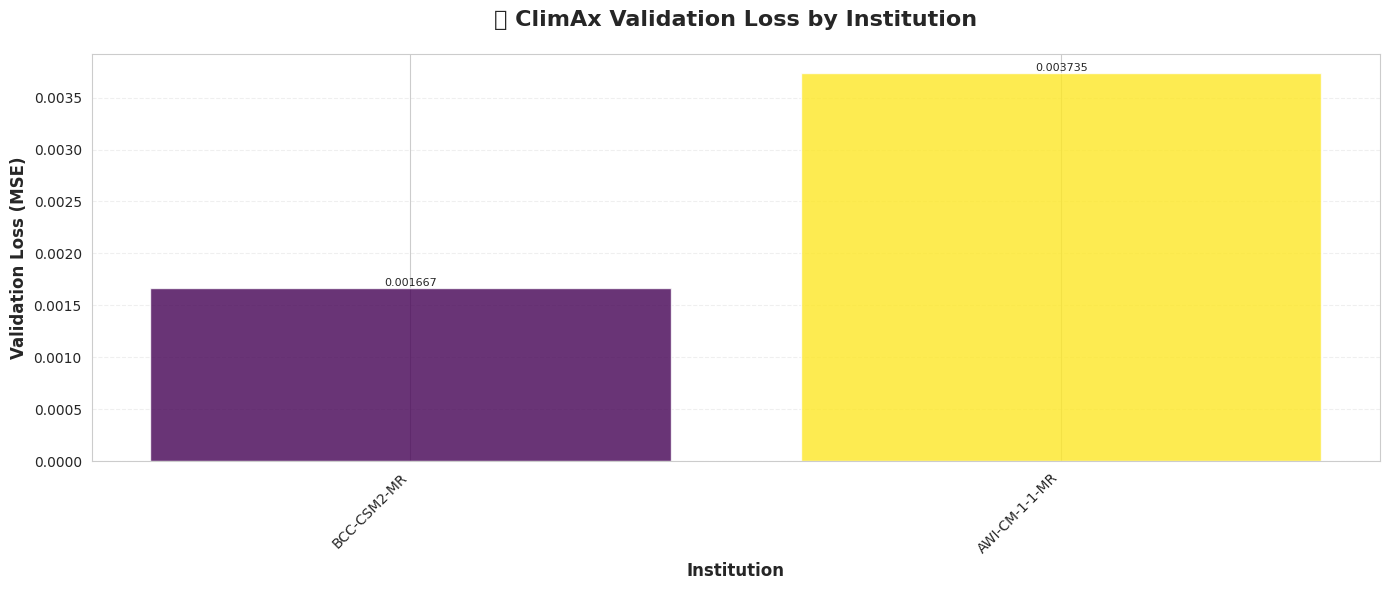

✅ Saved: 01_validation_loss_comparison.png


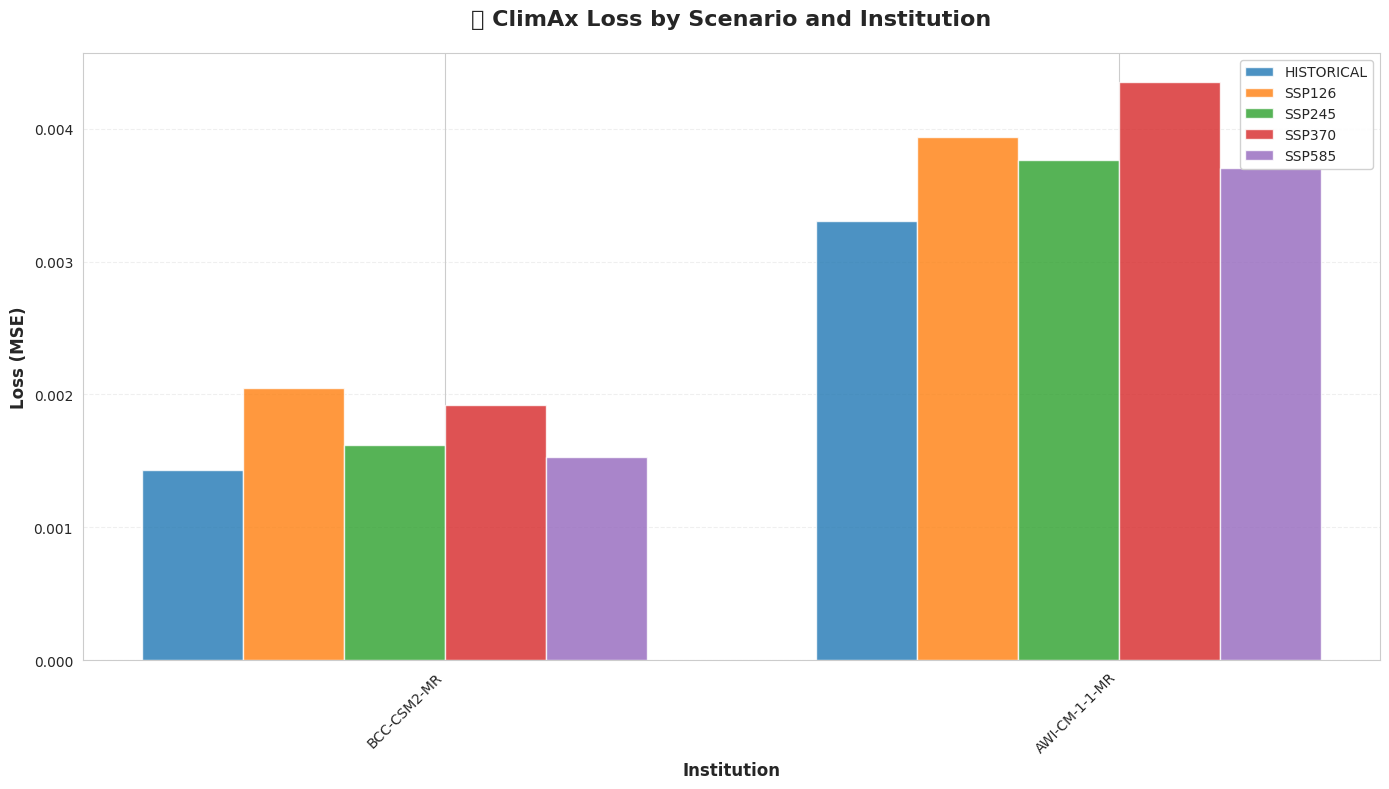

✅ Saved: 02_scenario_losses.png


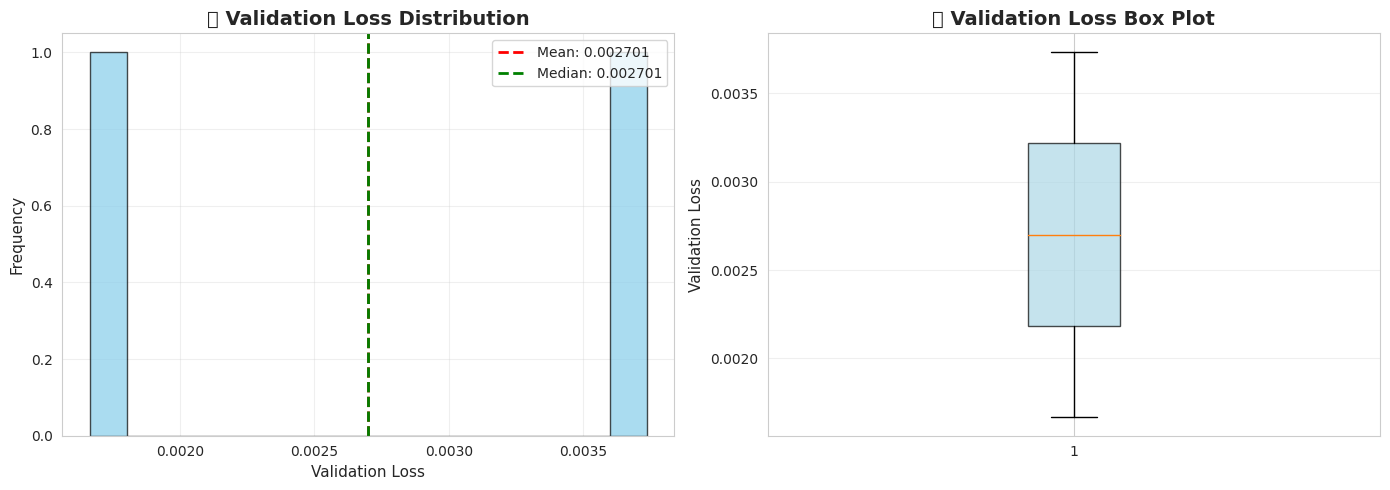

✅ Saved: 03_distribution_analysis.png


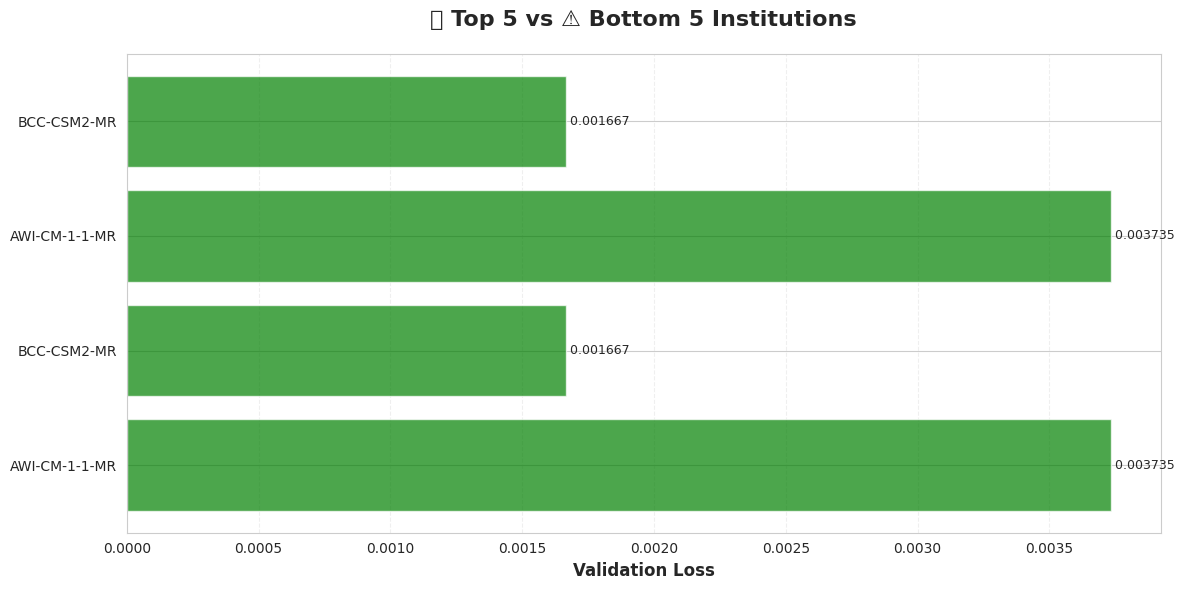

✅ Saved: 04_top_vs_bottom.png

✅ All visualizations saved to: /kaggle/working/climax_phase4_results/plots/

Step 3/6: Plotting top-K training curves...

📉 Generating training curves for top 3 institutions...


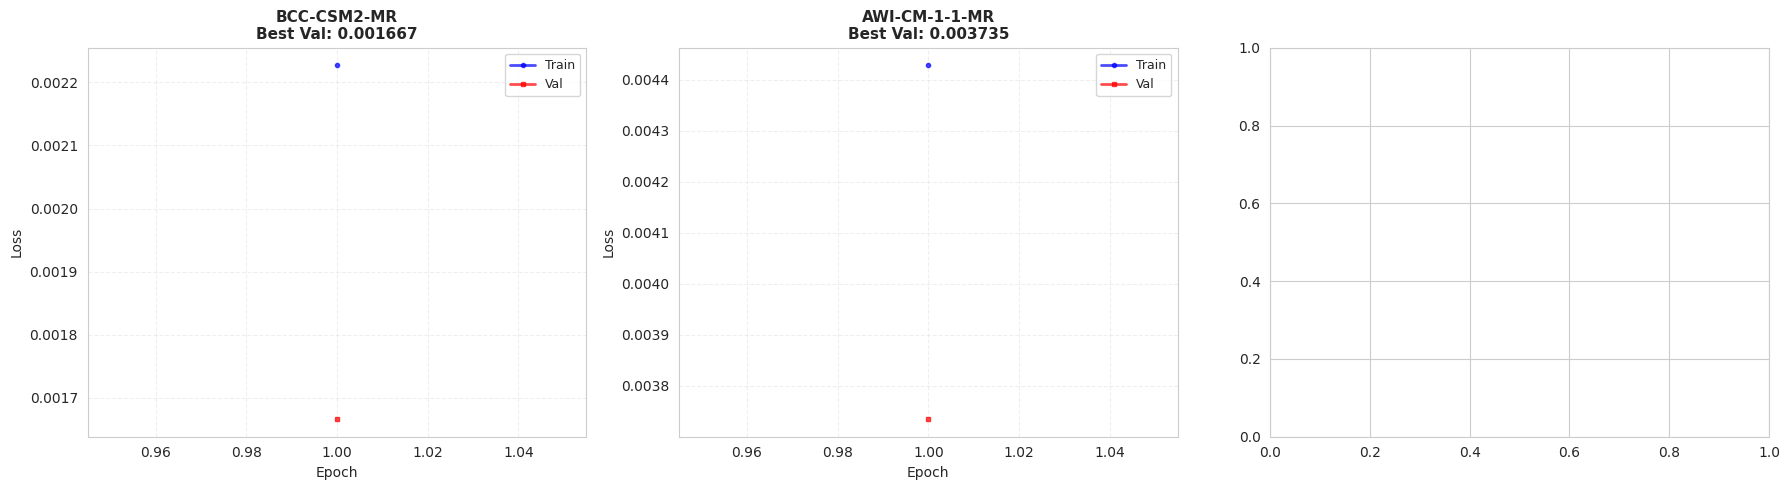

✅ Saved top 3 training curves

Step 4/6: Creating ensemble configuration...

🤝 Creating Ensemble Configuration (Top 5 institutions)
🏆 Top 5 institutions for ensemble:
  1. BCC-CSM2-MR
     Val Loss: 0.001667 | Weight: 0.6915
  2. AWI-CM-1-1-MR
     Val Loss: 0.003735 | Weight: 0.3085

💾 Ensemble configuration saved to: /kaggle/working/climax_phase4_results/climax_ensemble_config.json

Step 5/6: Generating comprehensive report...

📋 Generating comprehensive report...
✅ Report saved to: /kaggle/working/climax_phase4_results/climax_training_report.txt

📊 ClimAx Phase 4 - Comprehensive Training Report
Generated: 2025-10-23 18:17:44

📈 SUMMARY STATISTICS
--------------------------------------------------------------------------------
Total Institutions Trained: 2
Best Validation Loss: 0.00166657
Worst Validation Loss: 0.00373496
Mean Validation Loss: 0.00270076
Std Validation Loss: 0.00146257
Median Validation Loss: 0.00270076

🏆 TOP 5 PERFORMING INSTITUTIONS
-------------------------------

In [11]:
print("="*80)
print("🎯 ClimAx Phase 4 - Post-Training Analysis")
print("="*80)

# Check if training is complete
summary_path = os.path.join(OUTPUT_DIR, "logs", "phase4_training_summary.json")

if not os.path.exists(summary_path):
    print("⚠️ Training summary not found!")
    print(f"Expected path: {summary_path}")
    print("\nPlease complete training first (Section 6) before running analysis.")
else:
    print("✅ Training summary found!")
    print("\n🔄 Starting comprehensive analysis...\n")
    
    # ========================================
    # 📊 Step 1: Analyze Results
    # ========================================
    print("Step 1/6: Analyzing results...")
    df_sorted = analyze_climax_results(
        results_summary_path=summary_path,
        output_dir=OUTPUT_DIR
    )
    
    if df_sorted is not None:
        # ========================================
        # 📈 Step 2: Generate Visualizations
        # ========================================
        print("\nStep 2/6: Generating visualizations...")
        visualize_climax_results(df_sorted, output_dir=OUTPUT_DIR)
        
        # ========================================
        # 📉 Step 3: Top K Training Curves
        # ========================================
        print("\nStep 3/6: Plotting top-K training curves...")
        plot_top_k_training_curves(df_sorted, k=3, output_dir=OUTPUT_DIR)
        
        # ========================================
        # 🤝 Step 4: Create Ensemble Config
        # ========================================
        print("\nStep 4/6: Creating ensemble configuration...")
        ensemble_config = create_climax_ensemble_config(
            df_sorted, 
            top_k=5, 
            output_dir=OUTPUT_DIR
        )
        
        # ========================================
        # 📋 Step 5: Generate Report
        # ========================================
        print("\nStep 5/6: Generating comprehensive report...")
        generate_comprehensive_report(df_sorted, output_dir=OUTPUT_DIR)
        
        # ========================================
        # 💾 Step 6: Save Analysis Summary
        # ========================================
        print("\nStep 6/6: Saving analysis summary...")
        
        analysis_summary = {
            'analysis_timestamp': datetime.now().isoformat(),
            'total_institutions_analyzed': len(df_sorted),
            'best_institution': df_sorted.iloc[0]['Institution'],
            'best_val_loss': float(df_sorted.iloc[0]['Val_Loss']),
            'worst_institution': df_sorted.iloc[-1]['Institution'],
            'worst_val_loss': float(df_sorted.iloc[-1]['Val_Loss']),
            'mean_val_loss': float(df_sorted['Val_Loss'].mean()),
            'std_val_loss': float(df_sorted['Val_Loss'].std()),
            'ensemble_config': ensemble_config,
            'output_files': {
                'csv': 'climax_results_analysis.csv',
                'ensemble_config': 'climax_ensemble_config.json',
                'report': 'climax_training_report.txt',
                'plots': [
                    '01_validation_loss_comparison.png',
                    '02_scenario_losses.png',
                    '03_distribution_analysis.png',
                    '04_top_vs_bottom.png',
                    '05_top3_training_curves.png'
                ]
            }
        }
        
        analysis_path = os.path.join(OUTPUT_DIR, "climax_analysis_summary.json")
        with open(analysis_path, 'w') as f:
            json.dump(analysis_summary, f, indent=2)
        
        print(f"✅ Analysis summary saved to: {analysis_path}")
        
        # ========================================
        # 🎉 Final Summary
        # ========================================
        print("\n" + "="*80)
        print("🎉 ANALYSIS COMPLETE!")
        print("="*80)
        print(f"📁 All outputs saved to: {OUTPUT_DIR}/")
        print("\n📊 Generated Files:")
        print(f"  ├─ 📄 climax_results_analysis.csv")
        print(f"  ├─ 📄 climax_ensemble_config.json")
        print(f"  ├─ 📄 climax_training_report.txt")
        print(f"  ├─ 📄 climax_analysis_summary.json")
        print(f"  └─ 📂 plots/")
        print(f"      ├─ 01_validation_loss_comparison.png")
        print(f"      ├─ 02_scenario_losses.png")
        print(f"      ├─ 03_distribution_analysis.png")
        print(f"      ├─ 04_top_vs_bottom.png")
        print(f"      └─ 05_top3_training_curves.png")
        
        print("\n✅ You can now:")
        print("  1. Review the comprehensive report")
        print("  2. Examine the visualizations")
        print("  3. Use the ensemble config for inference")
        print("  4. Compare with ConvLSTM Phase 4 results")
        print("="*80)
        
    else:
        print("❌ Analysis failed - no valid results found!")

In [12]:
# =============================================================================
# 💾 CREATE ZIP FOR DOWNLOAD
# =============================================================================
import os
import shutil
from IPython.display import FileLink

print("="*80)
print("📦 CREATING DOWNLOADABLE ZIP ARCHIVE")
print("="*80)

# Check if output directory exists
if not os.path.exists(OUTPUT_DIR):
    print(f"❌ ERROR: Output directory not found!")
    print(f"   Path: {OUTPUT_DIR}")
    print(f"   Make sure training completed successfully.")
else:
    # Count files and calculate size
    file_count = 0
    total_size = 0
    
    for root, dirs, files in os.walk(OUTPUT_DIR):
        file_count += len(files)
        for f in files:
            try:
                total_size += os.path.getsize(os.path.join(root, f))
            except:
                pass
    
    print(f"📊 Directory Stats:")
    print(f"   Files: {file_count}")
    print(f"   Size: {total_size/(1024**2):.2f} MB")
    
    if file_count == 0:
        print(f"\n⚠️  No files to archive!")
    else:
        # Create ZIP archive
        print(f"\n🔄 Creating ZIP archive...")
        zip_base = '/kaggle/working/climax_results'
        zip_file = zip_base + '.zip'
        
        try:
            # Remove old ZIP if exists
            if os.path.exists(zip_file):
                os.remove(zip_file)
                print(f"   🗑️  Removed old ZIP")
            
            # Create new ZIP
            shutil.make_archive(zip_base, 'zip', OUTPUT_DIR)
            
            # Verify creation
            if os.path.exists(zip_file):
                zip_size = os.path.getsize(zip_file) / (1024**2)
                print(f"   ✅ ZIP created successfully!")
                print(f"\n📦 Archive Details:")
                print(f"   Location: {zip_file}")
                print(f"   Size: {zip_size:.2f} MB")
                print(f"   Files: {file_count}")
                
                # Display download link
                print(f"\n⬇️  DOWNLOAD LINK:")
                print("="*80)
                display(FileLink(zip_file))
                print("="*80)
                
            else:
                print(f"   ❌ ZIP file not found after creation")
                
        except Exception as e:
            print(f"   ❌ Error creating ZIP: {e}")
            print(f"\n💡 Alternative: Use Kaggle's 'Save Version' to commit outputs")

print("\n" + "="*80)
print("💡 REMEMBER TO SAVE PERMANENTLY:")
print("="*80)
print("Option 1: Click 'Save Version' → 'Save & Run All' (RECOMMENDED)")
print("Option 2: Download the ZIP file using the link above")
print("="*80)

📦 CREATING DOWNLOADABLE ZIP ARCHIVE
📊 Directory Stats:
   Files: 17
   Size: 10.95 MB

🔄 Creating ZIP archive...
   ✅ ZIP created successfully!

📦 Archive Details:
   Location: /kaggle/working/climax_results.zip
   Size: 9.83 MB
   Files: 17

⬇️  DOWNLOAD LINK:


/kaggle/working/climax_results.zip


💡 REMEMBER TO SAVE PERMANENTLY:
Option 1: Click 'Save Version' → 'Save & Run All' (RECOMMENDED)
Option 2: Download the ZIP file using the link above


In [13]:
# Diagnostic: Check what's in your output directory
import os

print("🔍 Directory Contents:")
print("="*80)

if os.path.exists(OUTPUT_DIR):
    for root, dirs, files in os.walk(OUTPUT_DIR):
        level = root.replace(OUTPUT_DIR, '').count(os.sep)
        indent = ' ' * 2 * level
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 2 * (level + 1)
        for file in files[:5]:  # Show first 5 files per directory
            size = os.path.getsize(os.path.join(root, file)) / (1024**2)
            print(f'{subindent}├─ {file} ({size:.2f} MB)')
        if len(files) > 5:
            print(f'{subindent}└─ ... and {len(files)-5} more files')
else:
    print(f"❌ Directory not found: {OUTPUT_DIR}")

🔍 Directory Contents:
climax_phase4_results/
  ├─ climax_analysis_summary.json (0.00 MB)
  ├─ climax_results_analysis.csv (0.00 MB)
  ├─ climax_training_report.txt (0.00 MB)
  ├─ climax_ensemble_config.json (0.00 MB)
  metrics/
  logs/
    ├─ phase4_training_summary.json (0.00 MB)
    ├─ BCC-CSM2-MR_phase4_results.json (0.00 MB)
    ├─ AWI-CM-1-1-MR_phase4_results.json (0.00 MB)
    ├─ phase4_progress.json (0.00 MB)
  checkpoints/
    ├─ BCC-CSM2-MR_final.pt (2.55 MB)
    ├─ AWI-CM-1-1-MR_multiscenario_best.pt (2.55 MB)
    ├─ AWI-CM-1-1-MR_final.pt (2.55 MB)
    ├─ BCC-CSM2-MR_multiscenario_best.pt (2.55 MB)
  plots/
    ├─ 02_scenario_losses.png (0.16 MB)
    ├─ 05_top3_training_curves.png (0.17 MB)
    ├─ 03_distribution_analysis.png (0.13 MB)
    ├─ 01_validation_loss_comparison.png (0.15 MB)
    ├─ 04_top_vs_bottom.png (0.13 MB)
  visualizations/


## 🎉 Done!

Your models are now trained and saved in the `climax_phase4_results/` directory.

### 📁 Output Files:
- **Models**: `climax_phase4_results/checkpoints/*.pt`
- **Logs**: `climax_phase4_results/logs/*.json`
- **Summary**: `climax_phase4_results/logs/phase4_training_summary.json`

### 🔄 Next Steps:
1. Load trained models for inference
2. Evaluate on test set
3. Generate predictions for different scenarios
4. Visualize results